## 1. Introduction
This notebook analyzes the functional and sequence relationships from the study on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
The notebook start by importing libraries, preparing the directories paths in section 1, section 2 prepares the data for the picrust pipeline on fasta, biom formates. Section 3-6 shows the process utilising directly algoritm for advance computer capabilities. The author approach utilises the Galaxy platform, where the original product files are found https://usegalaxy.eu/u/magicalex238/h/picrust2-functional. The results are imported on section 7 where a broad analysis is done on the global data exploring pathways,algoritm implementation, top general pathways and reactions. Section 8 involves retrieving the protein names for the granular data (EC contribution, ECcontri) from Galaxy results and for that utilises Uniprot Database. ECcontri_Uniprot data is analysed for the point of cutoff where the protein abundance has biological activity (Knee_abundance) for later use. Section 9 import several known and autoritative databases that are use to compile a new database (EC_records) comprising enzyme_names, mechanisms, pathways, metal_involved, protein hierarchi, reactions, amongst others. Then enriches the granular data with the newly created EC_records, put identifiers idx and introduce Sites and Categories. Section 10 is dedicated to the Filtering of protein-genus pairs pipeline on ECcontri_Uniprot_enriched. The data is classified by patterns, pathways (housekeeping, niche and mixed), separated between increasing, decreasing and mixed patterns, and the increasing patterns pairs are taken to the next step. The data is then prioritized by biological and statistical significance (prioritized_markers). Lastly is filtered with the knee abundance for biological activity (balanced_markers) and divided on marker_groups.
Then Section 11 visualise the results, made some clustering between related pairs and choses the top 10 markers to bring into the machine learning compendium repository where is join with the physicochemical data for a more comprensive prediction on corrosion by microbiologically induced corrosion.

### Directory Structure:
``` text
Sequence Analysis and Functional Prediction Pipeline
├── Introduction  
│   ├── 16S rRNA Data (bootstrap-validated)
│   └── imports, paths, preparation data
└── Analysis Approaches  
    ├── Direct Algorithm (Sections 3-6)  
    └── Galaxy Platform Analysis                             
         ├── Section 7: Broad Analysis (pathways, reactions)
         ├── Section 8: Protein Name Retrieval, data preparation
         ├── Section 9: Database Creation and Data enrichment
         │       ├──  EC_records: enzyme_names, mechanisms, pathways,
         │       └──  metal_involved, reactions, hierarchy...
         ├── Section 10: Filtering Protein-Genus Pairs pipeline
         │       ├── patterns_data, classified_results,
         │       └── prioritized_results...
         └── Section 11:Visualization & Machine Learning  
                 ├── Clustering related pairs  
                 ├── Top 10 markers  
                 └── further to ML (corrosion prediction)   

Picrust2 works using its reference database that was installed with the package   ~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf



# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [2]:
'''#os.path.exists('/content/drive/MyDrive')
from google.colab import drive
#drive.flush_and_unmount()

# Colab specific
from google.colab import files
drive.mount('/content/drive')
#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')'''

"#os.path.exists('/content/drive/MyDrive')\nfrom google.colab import drive\n#drive.flush_and_unmount()\n\n# Colab specific\nfrom google.colab import files\ndrive.mount('/content/drive')\n#change the path\nos.chdir('/content/drive/MyDrive/MIC/data_picrust')"

## 2.2. Installing Software Kaggle / Colab

In [3]:
'''# kernel in local is 3_combined python 3.12.3
# Making sure to use same python version for compatibility 3.12, Kaggle is very insufferable
!sudo apt-get update -y
!sudo apt-get install python3.12
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12
!python --version'''

'# kernel in local is 3_combined python 3.12.3\n# Making sure to use same python version for compatibility 3.12, Kaggle is very insufferable\n!sudo apt-get update -y\n!sudo apt-get install python3.12\n!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12\n!python --version'

In [4]:
'''import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # Further suppress TF warnings
# Making sure to use same python version for compatibility
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
from IPython.display import display
!pip install umap-learn
!pip install lxml pandas
!pip install pyarrow
!pip install openpyxl
!pip install scipy
!pip install python-Levenshtein
!pip install -U kaleido
!pip install statsmodels

!pip install natsort
!python3 --version
!pip install adjustText
!pip install psutil
import psutil
!pip install biopython
!pip install biom-format
!pip install fuzzywuzzy
!pip install dash dash-bootstrap-components plotly'''

"import os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings\nimport logging\nlogging.getLogger('tensorflow').setLevel(logging.ERROR)  # Further suppress TF warnings\n# Making sure to use same python version for compatibility\n!sudo apt-get update -y\n!sudo apt-get install python3.10\n!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1\nfrom IPython.display import display\n!pip install umap-learn\n!pip install lxml pandas\n!pip install pyarrow\n!pip install openpyxl\n!pip install scipy\n!pip install python-Levenshtein\n!pip install -U kaleido\n!pip install statsmodels\n\n!pip install natsort\n!python3 --version\n!pip install adjustText\n!pip install psutil\nimport psutil\n!pip install biopython\n!pip install biom-format\n!pip install fuzzywuzzy\n!pip install dash dash-bootstrap-components plotly"

In [5]:
import os
import sys
from pathlib import Path

if Path("/kaggle").exists():
    
    # Create directory structure
    !mkdir -p corrosion_scoring
    
    # Download only the necessary files
    !wget -O corrosion_scoring/__init__.py https://raw.githubusercontent.com/MagicAlex238/3_combined/main/corrosion_scoring/__init__.py
    !wget -O corrosion_scoring/global_terms.py https://raw.githubusercontent.com/MagicAlex238/3_combined/main/corrosion_scoring/global_terms.py
    !wget -O corrosion_scoring/scoring_system.py https://raw.githubusercontent.com/MagicAlex238/3_combined/main/corrosion_scoring/scoring_system.py
    
    # Add current directory to path
    import sys
    sys.path.append(os.getcwd())
    
    # Import package
    import corrosion_scoring as cs
else:
    print("Running in local (VSCode) environment")
    
    ## When in vscode local env
    #!pip install git+https://github.com/MagicAlex238/3_combined.git

Running in local (VSCode) environment


In [6]:
# Standard library imports
import os
import sys
from pathlib import Path
import ast
import subprocess
import logging
import time
from datetime import datetime
import shutil
from io import StringIO
import re
from collections import defaultdict
# Data processing and analysis
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import networkx as nx
import community as community_louvain
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib
#matplotlib.use('Agg') # For saving no for displaying
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import display
import kaleido

# Machine learning and statistical analysis
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import umap
import scipy
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, kruskal, mannwhitneyu
from scipy.signal import savgol_filter

from joblib import Parallel, delayed
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, fcluster
# Utility libraries
import gzip
import random
from natsort import natsorted
from typing import Dict, List, Tuple, Set, Optional
import gc
import joblib
import os
import json
import pyarrow.parquet as pq

os.environ['DISPLAY'] = ':0'

# Dash
import dash
from dash import dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
import plotly.express as px
import umap
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from collections import Counter
import dash
from dash import dcc, html, Input, Output, callback, State
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import umap
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s')
# Own Scoring system
import corrosion_scoring as cs

## 2.3. Importing Libraries,  Making Directories and Loading Data

In [7]:
# Determine the environment
if "google.colab" in sys.modules:
    print("Running in Google Colab environment")
    # for colab
    base_dir = Path("/content/drive/MyDrive/MIC")
    abundance_excel = base_dir / "data_picrust/merged_to_sequence.xlsx"
    output_large = base_dir / "output_large"
    output_base = base_dir
    market_dir = base_dir / "output_large" 
    #Directory to keep some Results
    large_dir = base_dir / "2_Micro/data_visual"
    large_dir.mkdir(parents=True, exist_ok=True)

elif Path("/kaggle").exists():
    print("Running in Kaggle environment")
    # For Kaggle work# Input datasets (read-only in Kaggle) 
    base_dir = Path("/kaggle/input/")  
    abundance_excel = base_dir / "new-picrust/merged_to_sequence.xlsx" 
    #Input market groups
    market_dir = base_dir / "markers/"
    data_physicochemical = base_dir / "physicochemical-parameters/Physicochemical.xlsx"
    #Directory to keep  Results
    output_base = Path("/kaggle/working/")
    shared_dir = output_base/"Visualisations"
    shared_dir.mkdir(parents=True, exist_ok=True)
    combined_path = output_base / "combined_markers.xlsx"
else:
    print("Running in local (VSCode) environment")
    base_dir = Path("data")
    base_dir.mkdir(parents=True, exist_ok=True)
    # Base Paths for local environment
    abundance_excel = base_dir / "merged_to_sequence.xlsx"
    # This files are too large for github and are store on Kaggle for educational purposes
    output_large = Path("/home/beatriz/MIC/output_large")
    output_base = output_large
    #Input market groups
    market_dir = output_large / "Markers/"  # Directory
    #Directory to keep some Results
    shared_dir= Path("/home/beatriz/SharedFolder/Visualisations/")
    combined_path = base_dir / "combined_markers.xlsx"
   
parquet_files = list(market_dir.glob("*.parquet"))
print(f"Found {len(parquet_files)} parquet files")

# Load all files into a dictionary of DataFrames
corrosion_report = {file.stem: pd.read_parquet(file) for file in parquet_files}

# Check available DataFrames
for name, df in corrosion_report.items():
    print(f"{name}: {df.shape}")

# Print confirmation of which paths are being used
print(f"Base directory: {base_dir}")
print(f"Abundance Excel: {abundance_excel}")
print(f"Output base: {output_base}")
print(f"Shared Directory: {shared_dir}")
print(f"Combined path: {combined_path}")

Running in local (VSCode) environment
Found 25 parquet files
group_mechanism_all: (840, 38)
group_top_markers: (211, 38)
integrated_results: (1442859, 43)
group_metal_iron_sulfur: (837, 38)
group_high_synergy_markers: (840, 38)
group_significant_markers: (680, 38)
classified_results: (1442859, 46)
prioritized_markers: (1047183, 58)
inverse_markers: (395676, 46)
group_high_prevalence: (0, 38)
group_metals_consolidated: (840, 38)
balanced_markers: (840, 56)
group_high_metals_relevance: (292, 38)
group_high_mechanism_relevance: (699, 38)
group_high_biological_relevance: (462, 38)
group_pathways_all: (831, 38)
group_high_pathway_relevance: (439, 38)
group_corrosion_critical: (211, 38)
increasing_markers: (1047183, 46)
group_functional_categories: (840, 38)
group_high_corrosion_relevance: (213, 38)
group_organic_metal_synergy: (840, 38)
group_high_tier_relevance: (348, 38)
group_very_high_specificity: (840, 38)
pattern_data: (1442859, 21)
Base directory: data
Abundance Excel: data/merged_to

In [8]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

## 2.4. Extracting Dictionary and Dataframes

In [9]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [10]:
# Main analysis dataframes (core pipeline)
pattern_data = corrosion_report["pattern_data"] # Sites 70, Genus 85
integrated_results = corrosion_report["integrated_results"] # Sites 70, Genus 85
classified_results = corrosion_report["classified_results"] # Sites 70, Genus 85
increasing_markers = corrosion_report["increasing_markers"] # Sites 53, Genus 84
prioritized_markers = corrosion_report["prioritized_markers"] # Sites 53, Genus 84
balanced_markers = corrosion_report["balanced_markers"] # Sites 50, Genus 84
inverse_markers = corrosion_report["inverse_markers"] # Sites 17, Genus 80

# Top marker groups (overall rankings)
top_markers = corrosion_report["group_top_markers"] # 21 sites, 48 Genus
significant_markers = corrosion_report["group_significant_markers"] # 21 sites, 78 Genus
high_prevalence = corrosion_report["group_high_prevalence"] # 0
very_high_specificity = corrosion_report["group_very_high_specificity"] #Sites 50, Genus 84
# Relevance-based groups
high_metals_relevance = corrosion_report["group_high_metals_relevance"] # Sites 36, Genus 49
high_mechanism_relevance = corrosion_report["group_high_mechanism_relevance"] # 46 sites, 79 genus
high_pathway_relevance = corrosion_report["group_high_pathway_relevance"] # Sites 50, Genus 74
high_tier_relevance = corrosion_report["group_high_tier_relevance"] # Sites 49, Genus 67
high_corrosion_relevance = corrosion_report["group_high_corrosion_relevance"] # Sites 45, Genus 57
high_biological_relevance = corrosion_report["group_high_biological_relevance"] # Sites 44, Genus 66

# Consolidated groups
mechanism_all = corrosion_report["group_mechanism_all"] # Sites 50, Genus 84
metals_consolidated = corrosion_report["group_metals_consolidated"] # Sites 50, Genus 84
pathways_all = corrosion_report["group_pathways_all"] # Sites 50, Genus 84
functional_categories = corrosion_report["group_functional_categories"]#  Sites 50, Genus 84

# Special groups
metal_iron_sulfur = corrosion_report["group_metal_iron_sulfur"] # Sites 50, Genus 84
high_synergy_markers = corrosion_report["group_high_synergy_markers"] # Sites 50, Genus 84
organic_metal_synergy = corrosion_report["group_organic_metal_synergy"] # Sites 50, Genus 84
corrosion_critical = corrosion_report["group_corrosion_critical"] # Sites 21, Genus 48

In [11]:
print(f"Sites {len(pathways_all['Sites'].unique())}, Genus {len(pathways_all['Genus'].unique())}")

Sites 50, Genus 84


# 3. General Visualising Corrosion Protein-Genus Pairs Analysis

## 3.1. Multiple Visualizations of Functional Data across Risk Categories
Please help me with this visualisation, the first plot is mean to have the three categories but however only have 1 and 3. The third plot is men fold change right? no get why it says system failure : normal, perhaps you wanted to say it more human? Plot number 4 ony show cat  2 and 3 and I am sure the data has all 3 more over legend should say 1. normal operation, 2 Early warning 3. System Failure. Here is the code 

In [12]:
def plot_multiview_functional_landscape(data_df, name, top_n=25, score_col='combined_score'):
    """
    Creates multiple visualizations of functional data across risk categories,
    with improved genus-level aggregation and better category representation.
    """
   
    # Make a copy to avoid warnings
    df = data_df.copy()
    
    # Define colors and categories
    category_colors = {1: '#2E7D32', 2: '#F57C00', 3: '#D32F2F'}
    categories_labels = {1: 'Normal Operation', 2: 'Early Warning', 3: 'System Failure'}
    
    # Ensure Category is integer type
    if 'Category' in df.columns:
        df.loc[:, 'Category'] = df['Category'].astype(int)
    
    # Aggregate by genus first to get diverse representation
    genus_agg = df.groupby('Genus').agg({
        score_col: 'mean',
        'mean_cat1': 'mean', 
        'mean_cat2': 'mean',
        'mean_cat3': 'mean'
    }).reset_index()
    
    # Get top genera by score
    top_genera = genus_agg.nlargest(top_n, score_col)['Genus'].tolist()
    
    # Get representative data for these genera (best scoring protein per genus)
    top_markers = df.loc[df.groupby('Genus')[score_col].idxmax()]
    top_markers = top_markers[top_markers['Genus'].isin(top_genera)]
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Corrosion Mechanisms Distribution (top left)
    mech_by_cat = []
    
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            norm_abund = row.get('norm_abund_contri', 1.0) if pd.notna(row.get('norm_abund_contri')) else 1.0
            
            cat1_val = row.get('mean_cat1', 0) if pd.notna(row.get('mean_cat1')) else 0
            cat2_val = row.get('mean_cat2', 0) if pd.notna(row.get('mean_cat2')) else 0
            cat3_val = row.get('mean_cat3', 0) if pd.notna(row.get('mean_cat3')) else 0
            
            for mech in mechanisms:
                if mech:
                    mech_by_cat.extend([
                        {'Mechanism': mech, 'Category': 'Normal Operation', 'Abundance': cat1_val * norm_abund, 'CategoryID': 1},
                        {'Mechanism': mech, 'Category': 'Early Warning', 'Abundance': cat2_val * norm_abund, 'CategoryID': 2},
                        {'Mechanism': mech, 'Category': 'System Failure', 'Abundance': cat3_val * norm_abund, 'CategoryID': 3}
                    ])
    
    if mech_by_cat:
        mech_df = pd.DataFrame(mech_by_cat)
        agg_mech = mech_df.groupby(['Mechanism', 'Category', 'CategoryID'])['Abundance'].sum().reset_index()
        
        # Get top mechanisms and ensure we show some variety
        top_mechanisms = agg_mech.groupby('Mechanism')['Abundance'].sum().nlargest(8).index
        filtered_mech = agg_mech[agg_mech['Mechanism'].isin(top_mechanisms)]
        
        sns.barplot(
            data=filtered_mech,
            x='Abundance',
            y='Mechanism',
            hue='Category',
            palette=[category_colors[1], category_colors[2], category_colors[3]],
            ax=axes[0, 0]
        )
        axes[0, 0].set_title("Top Corrosion Mechanisms by Risk Category", fontsize=14)
        axes[0, 0].set_xlabel("Abundance", fontsize=12)
        axes[0, 0].set_ylabel("Mechanism", fontsize=12)
    else:
        axes[0, 0].text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        axes[0, 0].set_title('Top Corrosion Mechanisms', fontsize=14)
    
    # 2. Protein Abundance Heatmap (top right) - Individual proteins with genus info
    required_cols = ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name']
    has_required_cols = all(col in top_markers.columns for col in required_cols)
    
    if has_required_cols and not top_markers.empty:
        # Sort by Category 3 values - individual proteins
        sorted_markers = top_markers.sort_values(by='mean_cat3', ascending=False).head(15)
        
        # Create descriptive row labels with protein names
        protein_labels = []
        for _, row in sorted_markers.iterrows():
            genus = row.get('Genus', 'Unknown')
            protein_name = row.get('protein_name', 'Unknown')
            
            if isinstance(protein_name, str) and len(protein_name) > 20:
                protein_name = protein_name[:20] + "..."
                
            label = f"{genus} - {protein_name}"
            protein_labels.append(label)
        
        # Prepare heat map data
        heatmap_data = pd.DataFrame({
            'Normal Op': sorted_markers['mean_cat1'],
            'Early Warning': sorted_markers['mean_cat2'],
            'System Failure': sorted_markers['mean_cat3']
        }).reset_index(drop=True)
        
        # Scale rows to percentages for better comparison
        for idx in heatmap_data.index:
            row_max = heatmap_data.loc[idx].max()
            if row_max > 0:
                heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)
        
        sns.heatmap(
            heatmap_data,
            cmap='Reds',
            annot=True,
            fmt='.1f',
            linewidths=0.5,
            yticklabels=protein_labels,
            ax=axes[0, 1],
            vmin=0,
            vmax=100
        )
        
        axes[0, 1].set_title('Protein Abundance Patterns (%)', fontsize=14)
    else:
        axes[0, 1].text(0.5, 0.5, "Insufficient data for heatmap", ha='center', va='center', fontsize=14)
        axes[0, 1].set_title('Genus Abundance Patterns', fontsize=14)
    
    # 3. Functional Category Enrichment (bottom left) - Fixed calculation
    if 'functional_categories_present' in top_markers.columns and not top_markers.empty:
        func_categories = []
        
        for _, row in top_markers.iterrows():
            if isinstance(row.get('functional_categories_present'), str) and row['functional_categories_present']:
                categories = [c.strip() for c in row['functional_categories_present'].split(';')]
                
                cat1_val = row.get('mean_cat1', 0) if pd.notna(row.get('mean_cat1')) else 0
                cat3_val = row.get('mean_cat3', 0) if pd.notna(row.get('mean_cat3')) else 0
                
                for cat in categories:
                    if cat:
                        func_categories.append({
                            'Functional_Category': cat,
                            'Cat1': cat1_val,
                            'Cat3': cat3_val
                        })
        
        if func_categories:
            func_df = pd.DataFrame(func_categories)
            agg_func = func_df.groupby('Functional_Category').agg({
                'Cat1': 'mean',  # Changed from sum to mean
                'Cat3': 'mean'   # Changed from sum to mean
            }).reset_index()
            
            # Calculate enrichment with better handling
            agg_func['Enrichment'] = agg_func.apply(
                lambda x: (x['Cat3'] + 0.01) / (x['Cat1'] + 0.01),  # Add small constant to avoid division issues
                axis=1
            )
            
            # Filter for meaningful enrichment (not just noise)
            meaningful_func = agg_func[
                (agg_func['Cat1'] > 0.01) | (agg_func['Cat3'] > 0.01)
            ].sort_values('Enrichment', ascending=False).head(8)
            
            if not meaningful_func.empty:
                sns.barplot(
                    data=meaningful_func,
                    x='Enrichment',
                    y='Functional_Category',
                    color='steelblue',
                    ax=axes[1, 0]
                )
                
                axes[1, 0].axvline(x=1, color='gray', linestyle='--', alpha=0.7)
                
                for i, p in enumerate(axes[1, 0].patches):
                    enrichment = meaningful_func.iloc[i]['Enrichment']
                    axes[1, 0].annotate(
                        f"{enrichment:.1f}x", 
                        (p.get_width() + 0.05, p.get_y() + p.get_height()/2),
                        ha='left', 
                        va='center',
                        fontsize=10
                    )
                
                axes[1, 0].set_title('Functional Category Enrichment', fontsize=14)
                axes[1, 0].set_xlabel('Enrichment (System Failure : Normal)', fontsize=12)
                axes[1, 0].set_ylabel('Functional Category', fontsize=12)
            else:
                axes[1, 0].text(0.5, 0.5, "No significant enrichment patterns", ha='center', va='center', fontsize=14)
                axes[1, 0].set_title('Functional Category Enrichment', fontsize=14)
        else:
            axes[1, 0].text(0.5, 0.5, "No functional categories available", ha='center', va='center', fontsize=14)
            axes[1, 0].set_title('Functional Category Enrichment', fontsize=14)
    else:
        axes[1, 0].text(0.5, 0.5, "No functional category data", ha='center', va='center', fontsize=14)
        axes[1, 0].set_title('Functional Category Enrichment', fontsize=14)
    
    # 4. Top Genera Distribution (bottom right) - Improved version
    if all(col in df.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus']):
        # Use all data for genus analysis, not just top_markers
        genus_summary = df.groupby('Genus').agg({
            'mean_cat1': 'mean',
            'mean_cat2': 'mean',
            'mean_cat3': 'mean',
            score_col: 'mean'
        }).reset_index()
        
        # Get top genera by score
        top_genera_viz = genus_summary.nlargest(12, score_col)
        
        # Melt for plotting
        melt_genera = top_genera_viz.melt(
            id_vars=['Genus'],
            value_vars=['mean_cat1', 'mean_cat2', 'mean_cat3'],
            var_name='Category',
            value_name='Abundance'
        )
        
        # Clean category names
        melt_genera['Category'] = melt_genera['Category'].map({
            'mean_cat1': 'Normal Operation',
            'mean_cat2': 'Early Warning', 
            'mean_cat3': 'System Failure'
        })
        
        sns.barplot(
            data=melt_genera,
            x='Genus',
            y='Abundance',
            hue='Category',
            palette=[category_colors[1], category_colors[2], category_colors[3]],
            ax=axes[1, 1]
        )
        
        axes[1, 1].set_title(f'Top Genera by {score_col}', fontsize=14)
        axes[1, 1].set_xlabel('Genus', fontsize=12)
        axes[1, 1].set_ylabel('Mean Abundance', fontsize=12)
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        axes[1, 1].text(0.5, 0.5, "Insufficient genus data", ha='center', va='center', fontsize=14)
        axes[1, 1].set_title('Top Genera Distribution', fontsize=14)
    
    # Overall title
    plt.suptitle(f"Functional MIC Landscape: {name}", fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

In [13]:
'''fig = plot_multiview_functional_landscape(balanced_markers, "balanced_markers", top_n=25, score_col = "overall_corrosion_score") 
output_path = shared_dir / "1_land.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')
fig.show()'''

'fig = plot_multiview_functional_landscape(balanced_markers, "balanced_markers", top_n=25, score_col = "overall_corrosion_score") \noutput_path = shared_dir / "1_land.png"\nfig.savefig(output_path, dpi=300, bbox_inches=\'tight\')\nfig.show()'

In [14]:
'''plot_multiview_functional_landscape(high_biological_relevance,"high_biological_relevance",  top_n=50, score_col="combined_score")

output_path = shared_dir / "2_land.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')'''

'plot_multiview_functional_landscape(high_biological_relevance,"high_biological_relevance",  top_n=50, score_col="combined_score")\n\noutput_path = shared_dir / "2_land.png"\nplt.savefig(output_path, dpi=300, bbox_inches=\'tight\')'

The prominence of acid production, direct eet, H2 consumption and sulphate production is expected on the the top mechanism at the granular level gives good consistency to the filtering pipeline. The plot for very_high_specificity group shows that the H2 consumption mechanism and the acid production predominate for that group.

## 3.2. Comparison of Mechanism by Category methodology

In [15]:
def corrosion_mechanism_original_vs_mean(top_markers, name="Comparison", top_n=10):
    """
    Create a comparison plot showing corrosion mechanisms using:
    1. Original Category (left subplot)
    2. Mean categories (right subplot)
    
    Parameters:     top_markers : DataFrame   containing the data with columns:   Category, corrosion_mechanisms, norm_abund_contri, mean_cat1, mean_cat2, mean_cat3
    name : str, optional to include in the plot title, by default "Comparison"
    top_n : int, optional    Number of top mechanisms to display, by default 10
    save_path : str, optional    Path to save the output figure, by default None
        
    Returns:  fig : matplotlib.figure.Figure  
    """
    # Define colors and categories for original Category
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green
        'mean_cat2': '#FF8C00',  # Dark orange
        'mean_cat3': '#FF0000'   # Red
    }
    
    # Mean category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    # Select top markers by score
    top_markers = top_markers.copy(deep=False)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # 1. FIRST PLOT: Original Category (left)
    mech_by_category = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    mech_by_category.append({
                        'Mechanism': mech,
                        'Category': int(row['Category']),  # Ensure integer type
                        'norm_abund_contri': row['norm_abund_contri']
                    })
    
    # Convert to DataFrame and aggregate
    mech_df = pd.DataFrame(mech_by_category)
    
    # Check if we have mechanisms data to plot
    if not mech_df.empty:
        # Group by mechanism and original category, summing abundance
        agg_mech = mech_df.groupby(['Mechanism', 'Category'])['norm_abund_contri'].sum().reset_index(name='Abundance')
        
        # Sort by abundance and get top mechanisms
        top_mechanisms = agg_mech.groupby('Mechanism')['Abundance'].sum().nlargest(top_n).index
        agg_mech = agg_mech[agg_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with consistent category colors
        sns.barplot(
            data=agg_mech,
            x='Abundance',
            y='Mechanism',
            hue='Category',
            palette=category_colors,
            ax=ax1
        )
        
        # Ensure legend shows categories with proper labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[categories_labels[int(label)] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms - {name}\nBy Original Category", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=14)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Original Category', fontsize=14)
    
    # 2. SECOND PLOT: Mean categories (right)
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Get mean values
            mean_cat1 = row.get('mean_cat1', 0)
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame for mean categories
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Second plot - mean categories
    if not mean_mech_df.empty:
        # Use the same top mechanisms as in the first plot for consistency
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Filter to the same top mechanisms from the first plot for consistency
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax2
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        
        ax2.set_title(f"Top Corrosion Mechanisms - {name}\nBy Mean Categories", fontsize=14)
        ax2.set_xlabel('Abundance', fontsize=14)
        ax2.set_ylabel('', fontsize=14)  
    else:
        ax2.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax2.set_title('Top Corrosion Mechanisms by Mean Categories', fontsize=14)
    
    plt.tight_layout(pad=2)
    
    return fig


In [16]:
'''#Calling the function:
fig = corrosion_mechanism_original_vs_mean(high_synergy_markers, "high_synergy_markers",  top_n=150)

output_path = shared_dir / "3_mech.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()'''

'#Calling the function:\nfig = corrosion_mechanism_original_vs_mean(high_synergy_markers, "high_synergy_markers",  top_n=150)\n\noutput_path = shared_dir / "3_mech.png"\nplt.savefig(output_path, dpi=300, bbox_inches=\'tight\')\nplt.show()'

The use of the original column of category and the mean shows that the mean actually try to homogenise the data on a way, however the main metabolisms remain to be the same first the H2 consumption , followed by direct electron transference, acid production and sulfur metabolism on top markers. 

## 3.3 Pathway Data across Risk Categories

### MultiPathway Analysis

In [17]:
def plot_pathway_analysis(prioritized_markers, name, top_n=100):
    """
    Creates comprehensive visualizations of pathway data across risk categories,
    using pre-existing categorized data in the dataframe.
    """
    # Select top markers based on combined score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    
    # Extract unique pathway categories from pathway_matches column
    # This uses the existing pathway categories 
    pathway_categories_count = {}
    for matches in top_markers['pathway_matches'].dropna():
        if isinstance(matches, str):
            # Split categories which are separated by semicolons
            categories = [cat.strip() for cat in matches.split(';')]
            for category in categories:
                if category:  # Skip empty strings
                    pathway_categories_count[category] = pathway_categories_count.get(category, 0) + 1
    
    # Convert to DataFrame for plotting
    category_df = pd.DataFrame({
        'Category': list(pathway_categories_count.keys()), 
        'Count': list(pathway_categories_count.values())
    }).sort_values('Count', ascending=False)
    
    # Prepare data for pathway analysis using existing category data
    pathway_data = []
    for _, row in top_markers.iterrows():
        if pd.notna(row['pathway_matches']) and row['pathway_matches']:
            categories = [cat.strip() for cat in row['pathway_matches'].split(';')]
            for category in categories:
                if category:
                    pathway_data.append({
                        'Pathway': category,  # Using the match as a pathway identifier
                        'Category': category, # The category is the same as the pathway in this case
                        'Category 1': row['mean_cat1'] if pd.notna(row['mean_cat1']) else 0,
                        'Category 2': row['mean_cat2'] if pd.notna(row['mean_cat2']) else 0,
                        'Category 3': row['mean_cat3'] if pd.notna(row['mean_cat3']) else 0,
                    })
    
    pathway_df = pd.DataFrame(pathway_data)
    
    # Aggregate pathway data by category (using existing categorization)
    agg_pathway = pathway_df.groupby('Category').agg({
        'Category 1': 'mean', 
        'Category 2': 'mean', 
        'Category 3': 'mean'
    }).reset_index()
    
    # Use existing fold_change_3vs1 where possible, otherwise calculate
    # Calculate Category 3 to Category 1 ratio with protection against zero division
    agg_pathway['Cat3_to_Cat1_Ratio'] = agg_pathway.apply(
        lambda x: x['Category 3'] / x['Category 1'] if x['Category 1'] > 0 else 
                (10 if x['Category 3'] > 0 else 1), 
        axis=1
    )
    
    # Sort by ratio (high to low)
    agg_pathway = agg_pathway.sort_values('Cat3_to_Cat1_Ratio', ascending=False)
    
    # Create visualization subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Plot 1: Category Distribution (same as before)
    sns.barplot(data=category_df, x='Count', y='Category', color='skyblue', ax=axes[0, 0])
    for i, bar in enumerate(axes[0, 0].patches):
        axes[0, 0].text(
            bar.get_width() + 0.3, 
            bar.get_y() + bar.get_height() / 2, 
            f"{int(bar.get_width())}", 
            ha='left', va='center', fontsize=12
        )
    axes[0, 0].set_title('Distribution of Pathway Categories', fontsize=18)
    axes[0, 0].tick_params(axis='both', labelsize=14)
    
    # Build network graph using existing category data
    G = nx.Graph()
    
    # Add category nodes using existing pathway categories
    for category, count in pathway_categories_count.items():
        G.add_node(category, size=count, group=1)
    
    # Add genus nodes (top 10)
    genera_counts = top_markers['Genus'].value_counts().head(10)
    for genus, count in genera_counts.items():
        G.add_node(genus, size=count * 3, group=2)
    
    # Add edges between genera and categories using functional_categories_present
    for _, row in top_markers.iterrows():
        genus = row['Genus']
        if genus not in genera_counts:
            continue
        # functional_categories_present: provides the relationships between genera and functional categories for the network graph    
        if isinstance(row['functional_categories_present'], str) and row['functional_categories_present']:
            categories = [cat.strip() for cat in row['functional_categories_present'].split(';')]
            categories_added = set()
            
            for category in categories:
                if category in pathway_categories_count and category not in categories_added:
                    if not G.has_edge(genus, category):
                        G.add_edge(genus, category, weight=1)
                    else:
                        G[genus][category]['weight'] += 1
                    categories_added.add(category)
    
    # Plot 2: Category enrichment ratio (same as before)
    sns.barplot(data=agg_pathway, x='Cat3_to_Cat1_Ratio', y='Category', color='steelblue', ax=axes[1, 0])
    for i, bar in enumerate(axes[1, 0].patches):
        ratio_value = agg_pathway.iloc[i]['Cat3_to_Cat1_Ratio']
        axes[1, 0].text(
            bar.get_width() + 0.02, 
            bar.get_y() + bar.get_height() / 2, 
            f"{ratio_value:.2f}x", 
            ha='left', va='center', fontsize=12
        )
    axes[1, 0].axvline(x=1, color='gray', linestyle='--')
    axes[1, 0].set_title('Pathway Category Enrichment in High Risk (Cat3:Cat1 Ratio)', fontsize=18)
    axes[1, 0].tick_params(axis='both', labelsize=14)
    
    # Plot 3: Heatmap of category abundance (same as before)
    heatmap_data = agg_pathway.set_index('Category')[['Category 1', 'Category 2', 'Category 3']].fillna(0)
    for idx in heatmap_data.index:
        row_max = heatmap_data.loc[idx].max()
        if row_max > 0:
            heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)
    
    sns.heatmap(
        heatmap_data, 
        cmap='Blues', 
        annot=True, 
        fmt=".1f", 
        linewidths=0.5, 
        ax=axes[0, 1], 
        vmin=0, 
        vmax=100, 
        annot_kws={"size": 12}
    )
    axes[0, 1].set_title('Pathway Category Abundance Patterns (% of max)', fontsize=18)
    axes[0, 1].tick_params(axis='both', labelsize=14)
    
    # Plot 4: Network visualization (same as before)
    pos = nx.spring_layout(G, k=1.2, seed=42)
    
    category_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 1]
    genera_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 2]
    
    node_sizes_cat = [G.nodes[node].get('size', 10) * 20 for node in category_nodes]
    node_sizes_gen = [G.nodes[node].get('size', 10) * 20 for node in genera_nodes]
    
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color='lightblue', 
                          node_size=node_sizes_cat, alpha=0.8, ax=axes[1, 1])
    nx.draw_networkx_nodes(G, pos, nodelist=genera_nodes, node_color='lightgreen', 
                          node_size=node_sizes_gen, alpha=0.8, ax=axes[1, 1])
    
    edge_weights = [G[u][v].get('weight', 1) / 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, ax=axes[1, 1])
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', ax=axes[1, 1])
    
    axes[1, 1].set_title('Genus-Pathway Category Network', fontsize=18)
    axes[1, 1].axis('off')
    
    # Overall layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"Pathways Categories for {name}", fontsize=18, y=0.98)
    
    return fig, category_df, agg_pathway

In [18]:
'''fig, category_df, agg_pathway = plot_pathway_analysis(high_corrosion_relevance, "high_corrosion_relevance", top_n=500) 
plt.show()

output_path = shared_dir / "4_pathw.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')'''

'fig, category_df, agg_pathway = plot_pathway_analysis(high_corrosion_relevance, "high_corrosion_relevance", top_n=500) \nplt.show()\n\noutput_path = shared_dir / "4_pathw.png"\nplt.savefig(output_path, dpi=300, bbox_inches=\'tight\')'

### MultiPathway 2

In [19]:
def plot_pathway_analysis(data_df, name, top_n=100, score_col='combined_score'):
    """
    Comprehensive pathway analysis with improved visualizations and flexible scoring.
    Creates four complementary views of pathway patterns across corrosion risk categories.
    """
    # Make copy and select top markers
    df = data_df.copy()
    
    # Handle different scoring scenarios
    if score_col in df.columns:
        top_markers = df.sort_values(score_col, ascending=False).head(top_n)
    else:
        # Fallback to mean_cat3 if score column doesn't exist
        top_markers = df.sort_values('mean_cat3', ascending=False).head(top_n)
        print(f"Warning: {score_col} not found, using mean_cat3 for sorting")
    
    # Define colors for consistency
    category_colors = {1: '#2E7D32', 2: '#F57C00', 3: '#D32F2F'}
    risk_labels = ['Normal Operation', 'Early Warning', 'System Failure']
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # === PLOT 1: Pathway Category Distribution ===
    pathway_data = []
    
    # Extract pathway information from multiple possible columns
    pathway_cols = ['pathway_matches', 'pathways', 'functional_categories_present']
    pathway_col = None
    
    for col in pathway_cols:
        if col in top_markers.columns and not top_markers[col].isna().all():
            pathway_col = col
            break
    
    if pathway_col:
        for _, row in top_markers.iterrows():
            if pd.notna(row[pathway_col]) and str(row[pathway_col]).strip():
                # Parse pathways/categories
                categories = [cat.strip() for cat in str(row[pathway_col]).split(';')]
                
                for category in categories:
                    if category and len(category) > 2:  # Filter out very short entries
                        pathway_data.append({
                            'Category': category,
                            'Genus': row.get('Genus', 'Unknown'),
                            'Cat1': row.get('mean_cat1', 0),
                            'Cat2': row.get('mean_cat2', 0), 
                            'Cat3': row.get('mean_cat3', 0),
                            'Score': row.get(score_col, 0)
                        })
    
    if pathway_data:
        pathway_df = pd.DataFrame(pathway_data)
        
        # Count occurrences and get top categories
        category_counts = pathway_df['Category'].value_counts().head(12)
        
        # Create horizontal bar plot
        sns.barplot(
            x=category_counts.values,
            y=category_counts.index,
            palette='viridis',
            ax=axes[0, 0]
        )
        
        # Add count labels
        for i, (cat, count) in enumerate(category_counts.items()):
            axes[0, 0].text(count + 0.5, i, str(count), 
                           va='center', ha='left', fontweight='bold')
        
        axes[0, 0].set_title('Most Frequent Pathway Categories', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Frequency', fontsize=12)
        axes[0, 0].set_ylabel('Pathway Category', fontsize=12)
    else:
        axes[0, 0].text(0.5, 0.5, 'No pathway data available', 
                       ha='center', va='center', fontsize=14)
        axes[0, 0].set_title('Pathway Categories', fontsize=14)
    
    # === PLOT 2: Risk Category Progression ===
    if pathway_data:
        # Aggregate by pathway category across risk levels
        risk_progression = pathway_df.groupby('Category')[['Cat1', 'Cat2', 'Cat3']].mean()
        
        # Get top categories by Cat3 abundance
        top_categories = risk_progression.sort_values('Cat3', ascending=False).head(8)
        
        # Prepare data for line plot
        progression_data = []
        for category in top_categories.index:
            for i, (col, label) in enumerate(zip(['Cat1', 'Cat2', 'Cat3'], risk_labels)):
                progression_data.append({
                    'Category': category,
                    'Risk_Level': label,
                    'Risk_Level_Num': i+1,
                    'Abundance': top_categories.loc[category, col]
                })
        
        prog_df = pd.DataFrame(progression_data)
        
        # Create line plot showing progression
        for category in top_categories.index[:6]:  # Limit to 6 for readability
            cat_data = prog_df[prog_df['Category'] == category]
            axes[0, 1].plot(cat_data['Risk_Level_Num'], cat_data['Abundance'], 
                           marker='o', linewidth=2, markersize=6, 
                           label=category[:25] + ('...' if len(category) > 25 else ''))
        
        axes[0, 1].set_xticks([1, 2, 3])
        axes[0, 1].set_xticklabels(risk_labels, rotation=45)
        axes[0, 1].set_ylabel('Mean Abundance', fontsize=12)
        axes[0, 1].set_title('Pathway Progression Across Risk Levels', fontsize=14, fontweight='bold')
        axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No progression data available', 
                       ha='center', va='center', fontsize=14)
        axes[0, 1].set_title('Risk Progression', fontsize=14)
    
    # === PLOT 3: Enrichment Analysis ===
    if pathway_data:
        # Calculate enrichment ratios
        enrichment_data = pathway_df.groupby('Category').agg({
            'Cat1': 'mean',
            'Cat3': 'mean',
            'Score': 'mean'
        }).reset_index()
        
        # Calculate enrichment (Cat3:Cat1 ratio)
        enrichment_data['Enrichment'] = enrichment_data.apply(
            lambda x: (x['Cat3'] + 0.01) / (x['Cat1'] + 0.01), axis=1
        )
        
        # Filter for meaningful enrichment and get top enriched
        significant_enrichment = enrichment_data[
            (enrichment_data['Cat1'] > 0.01) | (enrichment_data['Cat3'] > 0.01)
        ].sort_values('Enrichment', ascending=False).head(10)
        
        if not significant_enrichment.empty:
            # Create enrichment plot
            colors = ['#d62728' if x > 2 else '#ff7f0e' if x > 1.5 else '#2ca02c' 
                     for x in significant_enrichment['Enrichment']]
            
            bars = axes[1, 0].barh(range(len(significant_enrichment)), 
                                  significant_enrichment['Enrichment'],
                                  color=colors, alpha=0.7)
            
            # Add enrichment value labels
            for i, (idx, row) in enumerate(significant_enrichment.iterrows()):
                axes[1, 0].text(row['Enrichment'] + 0.05, i, 
                               f"{row['Enrichment']:.1f}x",
                               va='center', ha='left', fontweight='bold')
            
            axes[1, 0].set_yticks(range(len(significant_enrichment)))
            axes[1, 0].set_yticklabels([cat[:30] + ('...' if len(cat) > 30 else '') 
                                       for cat in significant_enrichment['Category']])
            axes[1, 0].axvline(x=1, color='gray', linestyle='--', alpha=0.7)
            axes[1, 0].set_xlabel('Enrichment Ratio (System Failure : Normal)', fontsize=12)
            axes[1, 0].set_title('Pathway Enrichment in High Risk', fontsize=14, fontweight='bold')
        else:
            axes[1, 0].text(0.5, 0.5, 'No significant enrichment patterns', 
                           ha='center', va='center', fontsize=14)
            axes[1, 0].set_title('Pathway Enrichment', fontsize=14)
    else:
        axes[1, 0].text(0.5, 0.5, 'No enrichment data available', 
                       ha='center', va='center', fontsize=14)
        axes[1, 0].set_title('Pathway Enrichment', fontsize=14)
    
    # === PLOT 4: Genus-Pathway Network ===
    if pathway_data and len(pathway_df) > 10:
        # Create network graph
        G = nx.Graph()
        
        # Get top genera and pathways
        top_genera = pathway_df['Genus'].value_counts().head(8).index
        top_pathways = pathway_df['Category'].value_counts().head(10).index
        
        # Add nodes
        for genus in top_genera:
            genus_score = pathway_df[pathway_df['Genus'] == genus]['Score'].mean()
            G.add_node(f"G_{genus}", node_type='genus', score=genus_score)
        
        for pathway in top_pathways:
            pathway_score = pathway_df[pathway_df['Category'] == pathway]['Score'].mean()
            G.add_node(f"P_{pathway[:20]}", node_type='pathway', score=pathway_score)
        
        # Add edges based on co-occurrence
        edge_weights = defaultdict(int)
        for _, row in pathway_df.iterrows():
            if row['Genus'] in top_genera and row['Category'] in top_pathways:
                genus_node = f"G_{row['Genus']}"
                pathway_node = f"P_{row['Category'][:20]}"
                edge_weights[(genus_node, pathway_node)] += 1
        
        # Add edges to graph
        for (u, v), weight in edge_weights.items():
            if weight > 1:  # Only show significant connections
                G.add_edge(u, v, weight=weight)
        
        if len(G.nodes()) > 0 and len(G.edges()) > 0:
            # Layout
            pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
            
            # Draw nodes
            genus_nodes = [n for n in G.nodes() if n.startswith('G_')]
            pathway_nodes = [n for n in G.nodes() if n.startswith('P_')]
            
            if genus_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=genus_nodes, 
                                     node_color='lightcoral', node_size=800,
                                     alpha=0.8, ax=axes[1, 1])
            
            if pathway_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=pathway_nodes,
                                     node_color='lightblue', node_size=600,
                                     alpha=0.8, ax=axes[1, 1])
            
            # Draw edges
            edges = G.edges()
            if edges:
                weights = [G[u][v]['weight'] for u, v in edges]
                nx.draw_networkx_edges(G, pos, width=[w/2 for w in weights],
                                     alpha=0.6, ax=axes[1, 1])
            
            # Draw labels
            labels = {n: n[2:15] + ('...' if len(n) > 17 else '') for n in G.nodes()}
            nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=axes[1, 1])
            
            axes[1, 1].set_title('Genus-Pathway Network\n(Red=Genera, Blue=Pathways)', 
                               fontsize=14, fontweight='bold')
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient connections for network', 
                           ha='center', va='center', fontsize=14)
            axes[1, 1].set_title('Genus-Pathway Network', fontsize=14)
        
        axes[1, 1].axis('off')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data for network analysis', 
                       ha='center', va='center', fontsize=14)
        axes[1, 1].set_title('Genus-Pathway Network', fontsize=14)
        axes[1, 1].axis('off')
    
    # Overall styling
    plt.suptitle(f"Pathway Analysis: {name}", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Return results
    results = {}
    if pathway_data:
        results['pathway_df'] = pathway_df
        results['category_counts'] = category_counts if 'category_counts' in locals() else None
        results['enrichment_data'] = enrichment_data if 'enrichment_data' in locals() else None
    
    return fig, results

/tmp/ipykernel_10129/4155111285.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


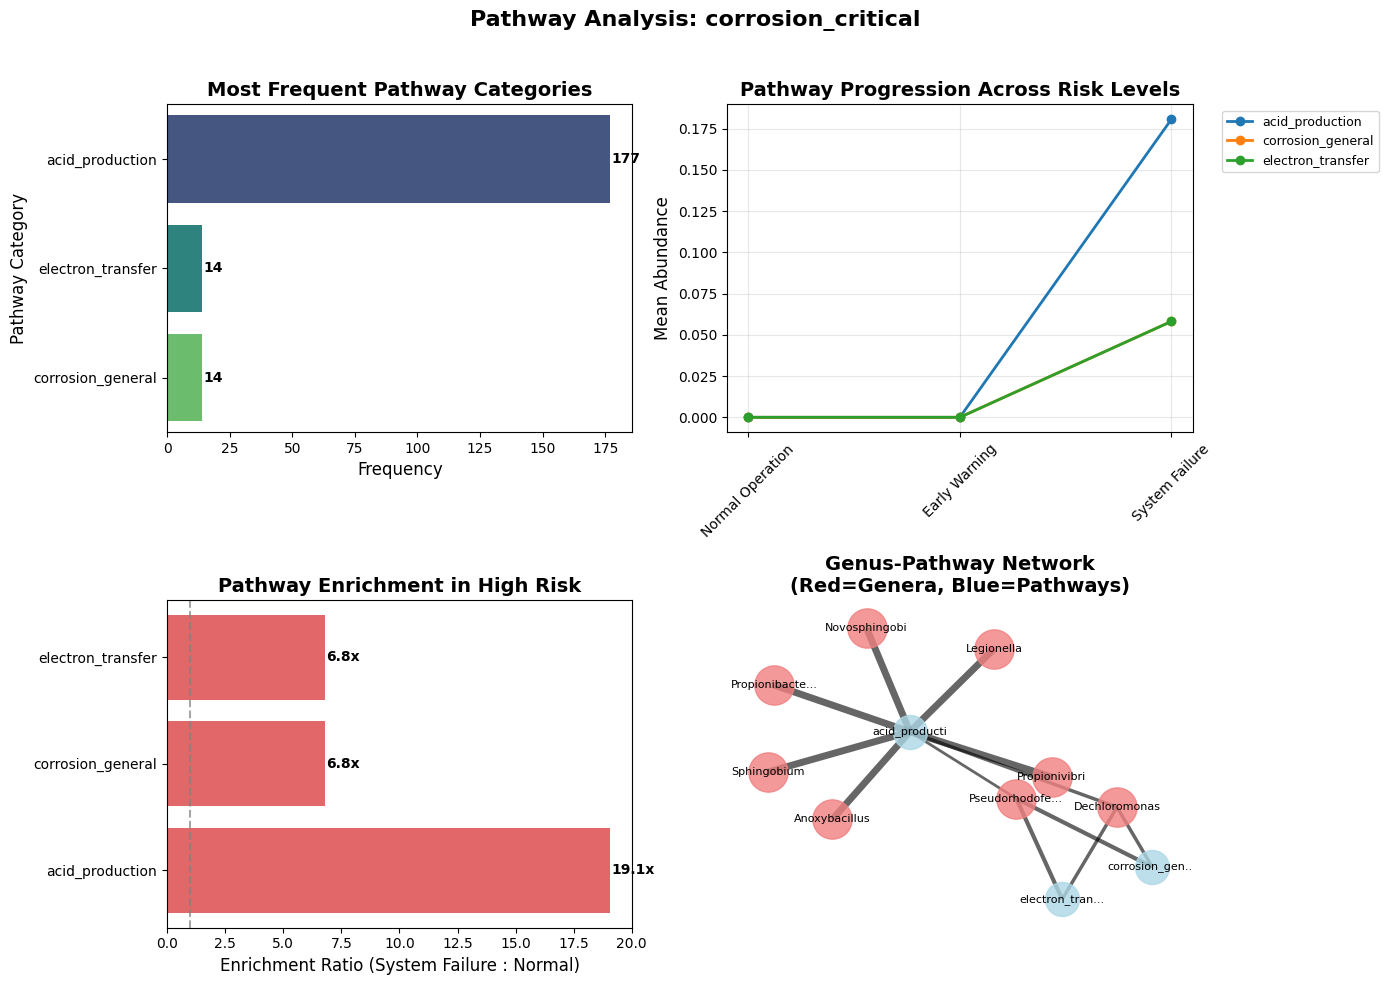

In [20]:
fig, results = plot_pathway_analysis(corrosion_critical, "corrosion_critical", top_n=200) 
plt.show() 

output_path = shared_dir / "5_pathw.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')

In [21]:
'''fig2, results2 = plot_pathway_analysis(very_high_specificity, "very_high_specificity", top_n=150) 
#plt.show() 

output_path = shared_dir / "6_pathw.png"
fig2.savefig(output_path, dpi=300, bbox_inches='tight')'''

'fig2, results2 = plot_pathway_analysis(very_high_specificity, "very_high_specificity", top_n=150) \n#plt.show() \n\noutput_path = shared_dir / "6_pathw.png"\nfig2.savefig(output_path, dpi=300, bbox_inches=\'tight\')'

For the top markers group, the dominance of lipid metabolism is interesting...
for the high prevalence has the genera that prevale on each category, so the major metabolism is the biofilm formation which is also the one when it get enrich, that is because the biofilm produce an specialise environment where the bacteria thrive and prevail. It follows the protein metabolism with is important for survival, the degradation pathway which involves using the substrates from the env

## 3.4. Temporal Transition and Mechanisms Distribution by Risk Categories
### Temporal Transition by Risk Categories

In [22]:
def temporal_transition(prioritized_markers, name):
    """
    Creates a Sankey diagram showing the flow of proteins between risk categories.
    Preserves your existing naming convention using 'Category'.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import rgb2hex
    import numpy as np
    import plotly.graph_objects as go
    
    # Make a copy to avoid modifying the original dataframe
    sig_results = prioritized_markers.copy(deep=False)
    
    # Normalize mechanism names while preserving original column
    if 'corrosion_mechanisms' in sig_results.columns and sig_results['corrosion_mechanisms'].notna().any():
        sig_results['_mech_temp'] = sig_results['corrosion_mechanisms'].copy()
        sig_results['_mech_temp'] = sig_results['_mech_temp'].str.replace('o2_consumption', 'O2_consumption')
        sig_results['_mech_temp'] = sig_results['_mech_temp'].str.replace('h2_consumption', 'H2_consumption')
    else:
        print("Warning: No 'corrosion_mechanisms' column found or all values are NaN")
        return None

    # Create category dominance for each protein-genus pair
    # Using mean_cat columns to determine dominance
    if all(col in sig_results.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3']):
        sig_results['dominant_category'] = sig_results[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
        sig_results['dominant_category'] = sig_results['dominant_category'].map({
            'mean_cat1': 'Category 1',
            'mean_cat2': 'Category 2',
            'mean_cat3': 'Category 3'
        })
        
        print(f"Distribution by dominant category: {sig_results['dominant_category'].value_counts().to_dict()}")
    else:
        print("Warning: Missing required mean_cat columns")
        return None

    # Determine the best separator for corrosion mechanisms
    flow_data = []
    mechanisms_set = set()
    best_separator = ';'  # Default separator
    
    # Try different separators and use the one that finds the most mechanisms
    for separator in [';', ',', '|']:
        test_count = sum(
            [len([m for m in str(mech).split(separator) if m.strip()]) 
             for mech in sig_results['_mech_temp'] if isinstance(mech, str)]
        )
        
        if test_count > 0:
            best_separator = separator
            break
    
    # Use the best separator to extract mechanisms
    for _, row in sig_results.iterrows():
        if isinstance(row['_mech_temp'], str) and row['_mech_temp']:
            mechanisms = [m.strip() for m in row['_mech_temp'].split(best_separator) if m.strip()]

            for m in mechanisms:
                mechanisms_set.add(m)  # Track all unique mechanisms

                # Add a flow from mechanism to dominant category
                flow_data.append({
                    'source': m,
                    'target': row['dominant_category'],
                    'value': 1,  # Count each protein once
                    'genus': row['Genus'] if 'Genus' in row else 'Unknown',
                    'protein': row['protein_name'] if 'protein_name' in row else 'Unknown'
                })

    # Convert to DataFrame
    flow_df = pd.DataFrame(flow_data)

    # Print some diagnostic info
    print(f"\nNumber of unique mechanisms: {len(mechanisms_set)}")
    print(f"Number of flows: {len(flow_df)}")

    # Check if we have any data before proceeding
    if len(flow_df) == 0:
        print("No flows found. Check the corrosion_mechanisms data format.")
        return None

    # Define the order of mechanisms according to energy requirements
    mechanism_order = [
        "O2_consumption",           # +820 mV, highest energy yield
        "nitrogen_metabolism",      # +750 to +420 mV (NO3- → NO2- → N2O → N2)
        "iron_metabolism",          # +770 mV (Fe3+ → Fe2+), but lower than N compounds
        "sulfur_metabolism",        # +150 to -240 mV (SO4^2- → SO3^2- → S0 → H2S)
        "H2_consumption",           # -420 mV (H+ → H2), but couples with other acceptors
        "direct_eet",              # Variable, depends on terminal acceptor
        "carbon_metabolism",        # -240 to -280 mV (CO2 → organics)
        "indirect_eet",            # Lower than direct, requires mediators
        "acid_production",         # Metabolic byproduct, not primary energy
        "metal_chelation",         # Binding process, minimal energy requirement
        "biofilm_formation",       # Structural process, energy cost not yield
    ]

    # Filter to only include mechanisms that exist in the data
    mechanisms = [m for m in mechanism_order if m in mechanisms_set]

    # Add any mechanisms that weren't in the predefined order
    other_mechanisms = sorted(list(mechanisms_set - set(mechanism_order)))
    mechanisms.extend(other_mechanisms)

    # Categories in order - using your original naming
    categories = ['Category 1', 'Category 2', 'Category 3']
    all_nodes = mechanisms + categories

    # Map source and target to indices
    node_indices = {node: i for i, node in enumerate(all_nodes)}

    flow_df['source_idx'] = flow_df['source'].map(node_indices)
    flow_df['target_idx'] = flow_df['target'].map(node_indices)

    # Aggregate flows by source and target
    agg_flows = flow_df.groupby(['source_idx', 'target_idx']).size().reset_index(name='value')

    # Define node colors - use specified category colors
    category_colors = {
        'Category 1': '#2E7D32',  # Darker green for better visibility
        'Category 2': '#F57C00',  # Darker orange 
        'Category 3': '#D32F2F'   # Darker red
    }

    # Generate mechanism colors using a more distinct colormap
    cmap = plt.cm.get_cmap('viridis', len(mechanisms))
    mechanism_colors = {m: rgb2hex(cmap(i)[:3]) for i, m in enumerate(mechanisms)}

    # Combine all colors
    node_colors = [mechanism_colors.get(node, '#9467bd') if node in mechanisms
                  else category_colors.get(node, '#1f77b4') for node in all_nodes]

    # Create labels with proper formatting
    labels = []
    for node in all_nodes:
        if node in mechanisms:
            # Format mechanism names for readability
            labels.append(node.replace('_', ' ').title())
        else:
            # Keep category names as is
            labels.append(node)

    # Create Sankey diagram with improved layout
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",  # Help prevent overlapping
        node=dict(
            pad=20,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
            hovertemplate="<b>%{label}</b><br>Count: %{value}<extra></extra>"
        ),
        link=dict(
            source=agg_flows['source_idx'],
            target=agg_flows['target_idx'],
            value=agg_flows['value'],
            hovertemplate="<b>%{source.label}</b> → <b>%{target.label}</b><br>Count: %{value}<extra></extra>"
        )
    )])

    fig.update_layout(
        title_text=f"Flow of Corrosion Mechanisms to Risk Categories: {name}",
        title_font_size=16,
        font_size=14,
        height=800,
        width=1200,
        margin=dict(l=50, r=50, t=80, b=50)
    )
    
    # Add annotation explaining the diagram
    fig.add_annotation(
        x=0.5, y=1.05,
        xref="paper", yref="paper",
        text="Mechanisms are arranged by energy efficiency",
        showarrow=False,
        font=dict(size=12),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        borderpad=4
    )

    return fig

In [23]:
'''fig = temporal_transition(classified_results, "classified_results")
fig.show()
san_path = shared_dir / "9_sankey.png"
plt.savefig(san_path, dpi=300, bbox_inches='tight')'''

'fig = temporal_transition(classified_results, "classified_results")\nfig.show()\nsan_path = shared_dir / "9_sankey.png"\nplt.savefig(san_path, dpi=300, bbox_inches=\'tight\')'

In [24]:
'''fig = temporal_transition(mechanism_all, "mechanism_all")
fig.show()
san_path = shared_dir / "10_sankey.png"
plt.savefig(san_path, dpi=300, bbox_inches='tight')'''

'fig = temporal_transition(mechanism_all, "mechanism_all")\nfig.show()\nsan_path = shared_dir / "10_sankey.png"\nplt.savefig(san_path, dpi=300, bbox_inches=\'tight\')'

## 3.5 Mechanism Distribution across Risk Category

In [25]:
def plot_mechanism_distribution(prioritized_markers, name, corrosion_mechanisms):
    """
    Creates stacked bar charts showing mechanism distribution across risk categories.
    Uses existing columns instead of recalculating.
    """
    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Work directly with the existing data - no recalculation needed
    # The corrosion_mechanisms column already contains categorized mechanisms
    mechanism_data = []
    
    for _, row in prioritized_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            # Split mechanisms if they're in a single cell, semicolon-separated
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            for mech in mechanisms:
                mechanism_data.append({
                    'mechanism': mech,
                    'mean_cat1': row['mean_cat1'],
                    'mean_cat2': row['mean_cat2'],
                    'mean_cat3': row['mean_cat3']
                })
    
    # Convert to DataFrame and group by mechanism
    mechanism_df = pd.DataFrame(mechanism_data)
    
    # Aggregate abundance values by mechanism
    grouped = mechanism_df.groupby('mechanism').agg({
        'mean_cat1': 'sum',
        'mean_cat2': 'sum',
        'mean_cat3': 'sum'
    }).reset_index()
    
    # Calculate total abundance and get top 10
    grouped['total'] = grouped['mean_cat1'] + grouped['mean_cat2'] + grouped['mean_cat3']
    grouped = grouped.sort_values('total', ascending=False).head(10)
    
    # Prepare data for stacked bar chart
    data = []
    for risk_category, color in category_colors.items():
        column_name = f'mean_cat{risk_category}'
        data.append(
            go.Bar(
                name=f'Risk Category {risk_category}',
                x=grouped['mechanism'],
                y=grouped[column_name],
                text=grouped[column_name].round(2),
                textposition='auto',
                marker_color=color
            )
        )
    
    # Create figure
    fig = go.Figure(data=data)
    
    # Update layout
    fig.update_layout(
        barmode='stack',
        title=f"Top 10 Corrosion Mechanisms for Group {name} by Risk Category",
        xaxis_title='Corrosion Mechanisms',
        yaxis_title='Total Abundance',
        legend_title='Risk Category',
        hovermode='x',
        height=600,
        width=1000.
    )
    
    return fig

In [26]:
'''fig1= plot_mechanism_distribution(classified_results , "classified_results", cs.corrosion_mechanisms)
fig1.show()
mech_path = shared_dir / "11_mech.png"
plt.savefig(str(mech_path), dpi=300, bbox_inches='tight')'''

'fig1= plot_mechanism_distribution(classified_results , "classified_results", cs.corrosion_mechanisms)\nfig1.show()\nmech_path = shared_dir / "11_mech.png"\nplt.savefig(str(mech_path), dpi=300, bbox_inches=\'tight\')'

This plot corresponds to the whole data which has no been yet filtered just classified. The most of the data is annotated with H2 consumption followed by direct eet. Which is also related to the high presence of proteins that are known for doing extracellular electrical transference from metal surfaces. 

## 3.6 A  Dinamic Cluster Analysis UMAP visualizations colored by protein metadata

In [27]:
def create_enhanced_umap_visualization(marker_data, name):
    """
    Creates an enhanced Dash application with biological context and functional analysis
    """
    import dash
    from dash import dcc, html, Input, Output, State
    import dash_bootstrap_components as dbc
    import plotly.graph_objects as go
    import plotly.express as px
    import umap
    import pandas as pd
    import numpy as np
    from sklearn.cluster import DBSCAN
    from collections import Counter
    
    app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
    
    # Prepare data
    exclude_cols = ['protein_name', 'Genus', 'idx', 'Sites']
    numerical_cols = [col for col in marker_data.columns 
                     if marker_data[col].dtype in ['int64', 'float64'] and col not in exclude_cols]
    
    # Color schemes
    risk_colors = {1: '#2E7D32', 2: '#F57C00', 3: '#D32F2F'}
    mechanism_colors = px.colors.qualitative.Set3
    
    app.layout = dbc.Container([
        html.H2("Enhanced Protein UMAP with Biological Context", className="text-center mb-4"),
        
        dbc.Tabs([
            # Main UMAP Tab
            dbc.Tab(label="UMAP Visualization", tab_id="umap-tab"),
            # Cluster Analysis Tab
            dbc.Tab(label="Cluster Analysis", tab_id="cluster-tab"),
            # Functional Enrichment Tab
            dbc.Tab(label="Functional Analysis", tab_id="functional-tab")
        ], id="tabs", active_tab="umap-tab"),
        
        html.Div(id="tab-content", className="mt-4")
    ], fluid=True)
    
    @app.callback(Output("tab-content", "children"), Input("tabs", "active_tab"))
    def render_tab_content(active_tab):
        if active_tab == "umap-tab":
            return create_umap_tab()
        elif active_tab == "cluster-tab":
            return create_cluster_tab()
        elif active_tab == "functional-tab":
            return create_functional_tab()
    
    def create_umap_tab():
        return dbc.Row([
            # Controls
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("UMAP Controls"),
                    dbc.CardBody([
                        html.Label("Feature Selection:"),
                        dcc.Dropdown(
                            id='feature-dropdown',
                            options=[
                                {'label': 'Risk Categories (mean_cat)', 'value': 'risk_cats'},
                                {'label': 'Fold Changes', 'value': 'fold_changes'},
                                {'label': 'Mechanism Scores', 'value': 'mechanisms'},
                                {'label': 'All Scores', 'value': 'all_scores'},
                                {'label': 'Custom', 'value': 'custom'}
                            ],
                            value='risk_cats'
                        ),
                        html.Br(),
                        
                        html.Label("Color Points By:"),
                        dcc.Dropdown(
                            id='color-dropdown',
                            options=[
                                {'label': 'Risk Category', 'value': 'risk'},
                                {'label': 'Genus', 'value': 'genus'},
                                {'label': 'Dominant Mechanism', 'value': 'mechanism'},
                                {'label': 'Combined Score', 'value': 'score'}
                            ],
                            value='risk'
                        ),
                        html.Br(),
                        
                        html.Label("Point Size By:"),
                        dcc.Dropdown(
                            id='size-dropdown',
                            options=[
                                {'label': 'Fixed Size', 'value': 'fixed'},
                                {'label': 'Combined Score', 'value': 'score'},
                                {'label': 'Category 3 Abundance', 'value': 'cat3'},
                                {'label': 'Max Fold Change', 'value': 'max_fc'}
                            ],
                            value='score'
                        ),
                        html.Br(),
                        
                        html.Label("UMAP Parameters:"),
                        html.P("n_neighbors:"),
                        dcc.Slider(id='n-neighbors', min=5, max=50, value=15, step=5,
                                  marks={i: str(i) for i in range(5, 51, 10)}),
                        
                        html.P("min_dist:"),
                        dcc.Slider(id='min-dist', min=0.0, max=0.9, value=0.1, step=0.1,
                                  marks={i/10: f"{i/10:.1f}" for i in range(0, 10, 2)}),
                        
                        html.Br(),
                        dbc.Button("Update UMAP", id="update-umap", color="primary", className="mb-2"),
                        dbc.Button("Find Clusters", id="find-clusters", color="success")
                    ])
                ])
            ], width=3),
            
            # Main plot
            dbc.Col([
                dcc.Loading(
                    dcc.Graph(id='main-umap', style={'height': '70vh'})
                ),
                
                # Selected point info
                dbc.Card([
                    dbc.CardHeader("Selected Point Information"),
                    dbc.CardBody(id="point-info")
                ], className="mt-3")
            ], width=9)
        ])
    
    def create_cluster_tab():
        return dbc.Row([
            dbc.Col([
                dcc.Loading(
                    dcc.Graph(id='cluster-plot', style={'height': '50vh'})
                )
            ], width=6),
            dbc.Col([
                html.H4("Cluster Characteristics"),
                html.Div(id="cluster-analysis")
            ], width=6)
        ])
    
    def create_functional_tab():
        return dbc.Row([
            dbc.Col([
                dcc.Loading(
                    dcc.Graph(id='functional-plot', style={'height': '60vh'})
                )
            ], width=8),
            dbc.Col([
                html.H4("Functional Enrichment"),
                html.Div(id="functional-analysis")
            ], width=4)
        ])
    
    @app.callback(
        [Output('main-umap', 'figure'),
         Output('point-info', 'children')],
        [Input('update-umap', 'n_clicks'),
         Input('main-umap', 'clickData')],
        [State('feature-dropdown', 'value'),
         State('color-dropdown', 'value'),
         State('size-dropdown', 'value'),
         State('n-neighbors', 'value'),
         State('min-dist', 'value')]
    )
    def update_main_umap(n_clicks, click_data, features, color_by, size_by, n_neighbors, min_dist):
        # Select features
        if features == 'risk_cats':
            feature_cols = [col for col in marker_data.columns if col.startswith('mean_cat')]
        elif features == 'fold_changes':
            feature_cols = [col for col in marker_data.columns if 'fold_change' in col or 'log2fc' in col]
        elif features == 'mechanisms':
            feature_cols = [col for col in marker_data.columns if 'score' in col and col != 'combined_score']
        elif features == 'all_scores':
            feature_cols = [col for col in numerical_cols if 'score' in col or 'mean_cat' in col]
        else:
            feature_cols = numerical_cols[:10]  # Default fallback
        
        # Ensure we have valid features
        valid_features = [col for col in feature_cols if col in marker_data.columns]
        if not valid_features:
            return go.Figure().update_layout(title="No valid features found"), "No data"
        
        # Prepare data for UMAP
        X = marker_data[valid_features].fillna(0).values
        
        # Run UMAP
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(X)
        
        # Create plotting DataFrame
        plot_df = marker_data.copy()
        plot_df['UMAP1'] = embedding[:, 0]
        plot_df['UMAP2'] = embedding[:, 1]
        
        # Determine colors
        if color_by == 'risk':
            # Dominant risk category
            cat_cols = ['mean_cat1', 'mean_cat2', 'mean_cat3']
            plot_df['color_val'] = plot_df[cat_cols].idxmax(axis=1).str[-1].astype(int)
            color_map = risk_colors
            color_title = "Risk Category"
        elif color_by == 'genus':
            plot_df['color_val'] = plot_df['Genus']
            color_map = None
            color_title = "Genus"
        elif color_by == 'mechanism':
            # Extract dominant mechanism
            plot_df['color_val'] = plot_df.get('corrosion_mechanisms', 'Unknown').fillna('Unknown')
            color_map = None
            color_title = "Mechanism"
        else:  # score
            plot_df['color_val'] = plot_df.get('combined_score', plot_df.get('overall_corrosion_score', 0))
            color_map = None
            color_title = "Score"
        
        # Determine sizes
        if size_by == 'fixed':
            plot_df['size_val'] = 8
        elif size_by == 'score':
            plot_df['size_val'] = (plot_df.get('combined_score', plot_df.get('overall_corrosion_score', 1)) / 
                                  plot_df.get('combined_score', plot_df.get('overall_corrosion_score', 1)).max() * 15 + 5)
        elif size_by == 'cat3':
            plot_df['size_val'] = (plot_df.get('mean_cat3', 0) / plot_df.get('mean_cat3', 1).max() * 15 + 5)
        else:  # max_fc
            fc_cols = [col for col in plot_df.columns if 'fold_change' in col or 'log2fc' in col]
            if fc_cols:
                plot_df['size_val'] = (plot_df[fc_cols].max(axis=1) / plot_df[fc_cols].max().max() * 15 + 5)
            else:
                plot_df['size_val'] = 8
        
        # Create figure
        fig = go.Figure()
        
        if color_by == 'risk' and color_map:
            for cat, color in color_map.items():
                mask = plot_df['color_val'] == cat
                if mask.any():
                    fig.add_trace(go.Scatter(
                        x=plot_df[mask]['UMAP1'],
                        y=plot_df[mask]['UMAP2'],
                        mode='markers',
                        name=f'Risk Category {cat}',
                        marker=dict(size=plot_df[mask]['size_val'], color=color, opacity=0.7),
                        hovertemplate="<b>%{text}</b><br>UMAP1: %{x:.2f}<br>UMAP2: %{y:.2f}<extra></extra>",
                        text=plot_df[mask]['Genus'] + ' - ' + plot_df[mask]['protein_name'].str[:20]
                    ))
        else:
            fig.add_trace(go.Scatter(
                x=plot_df['UMAP1'],
                y=plot_df['UMAP2'],
                mode='markers',
                marker=dict(
                    size=plot_df['size_val'],
                    color=plot_df['color_val'] if pd.api.types.is_numeric_dtype(plot_df['color_val']) else None,
                    colorscale='viridis' if pd.api.types.is_numeric_dtype(plot_df['color_val']) else None,
                    opacity=0.7,
                    colorbar=dict(title=color_title) if pd.api.types.is_numeric_dtype(plot_df['color_val']) else None
                ),
                hovertemplate="<b>%{text}</b><br>UMAP1: %{x:.2f}<br>UMAP2: %{y:.2f}<extra></extra>",
                text=plot_df['Genus'] + ' - ' + plot_df['protein_name'].str[:20]
            ))
        
        fig.update_layout(
            title=f"UMAP: {features} colored by {color_by}",
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            height=600,
            hovermode='closest'
        )
        
        # Handle click data for point info
        point_info = "Click on a point to see details"
        if click_data and 'points' in click_data:
            point_idx = click_data['points'][0]['pointIndex']
            if point_idx < len(plot_df):
                selected = plot_df.iloc[point_idx]
                point_info = dbc.ListGroup([
                    dbc.ListGroupItem(f"Genus: {selected.get('Genus', 'Unknown')}"),
                    dbc.ListGroupItem(f"Protein: {selected.get('protein_name', 'Unknown')[:50]}"),
                    dbc.ListGroupItem(f"Risk Scores: Cat1={selected.get('mean_cat1', 0):.3f}, "
                                    f"Cat2={selected.get('mean_cat2', 0):.3f}, "
                                    f"Cat3={selected.get('mean_cat3', 0):.3f}"),
                    dbc.ListGroupItem(f"Combined Score: {selected.get('combined_score', 'N/A')}"),
                    dbc.ListGroupItem(f"Mechanisms: {selected.get('corrosion_mechanisms', 'Unknown')[:100]}")
                ])
        
        return fig, point_info
    
    @app.callback(
        [Output('cluster-plot', 'figure'),
         Output('cluster-analysis', 'children')],
        Input('find-clusters', 'n_clicks'),
        prevent_initial_call=True
    )
    def analyze_clusters(n_clicks):
        if not n_clicks:
            return go.Figure(), "Click 'Find Clusters' to analyze"
        
        # Use current UMAP embedding (simplified for demo)
        feature_cols = [col for col in marker_data.columns if col.startswith('mean_cat')]
        X = marker_data[feature_cols].fillna(0).values
        
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        embedding = reducer.fit_transform(X)
        
        # Find clusters using DBSCAN
        clustering = DBSCAN(eps=0.5, min_samples=5).fit(embedding)
        cluster_labels = clustering.labels_
        
        # Create cluster plot
        fig = go.Figure()
        unique_labels = np.unique(cluster_labels)
        
        for label in unique_labels:
            mask = cluster_labels == label
            fig.add_trace(go.Scatter(
                x=embedding[mask, 0],
                y=embedding[mask, 1],
                mode='markers',
                name=f'Cluster {label}' if label != -1 else 'Noise',
                marker=dict(size=8, opacity=0.7)
            ))
        
        fig.update_layout(
            title="UMAP Clusters",
            xaxis_title="UMAP1",
            yaxis_title="UMAP2"
        )
        
        # Analyze cluster characteristics
        cluster_info = []
        for label in unique_labels:
            if label == -1:  # Skip noise
                continue
            
            mask = cluster_labels == label
            cluster_data = marker_data[mask]
            
            # Top genera in cluster
            top_genera = cluster_data['Genus'].value_counts().head(3)
            
            # Average risk scores
            avg_scores = cluster_data[['mean_cat1', 'mean_cat2', 'mean_cat3']].mean()
            
            # Dominant mechanisms
            all_mechanisms = []
            for mechs in cluster_data.get('corrosion_mechanisms', []):
                if pd.notna(mechs) and isinstance(mechs, str):
                    all_mechanisms.extend([m.strip() for m in mechs.split(';')])
            
            top_mechanisms = Counter(all_mechanisms).most_common(3)
            
            cluster_info.append(
                dbc.Card([
                    dbc.CardHeader(f"Cluster {label} ({mask.sum()} proteins)"),
                    dbc.CardBody([
                        html.P(f"Top Genera: {', '.join([f'{g}({c})' for g, c in top_genera.items()])}"),
                        html.P(f"Risk Profile: Cat1={avg_scores['mean_cat1']:.3f}, "
                              f"Cat2={avg_scores['mean_cat2']:.3f}, Cat3={avg_scores['mean_cat3']:.3f}"),
                        html.P(f"Top Mechanisms: {', '.join([f'{m}({c})' for m, c in top_mechanisms])}")
                    ])
                ], className="mb-2")
            )
        
        return fig, cluster_info
    
    @app.callback(
        [Output('functional-plot', 'figure'),
         Output('functional-analysis', 'children')],
        Input('tabs', 'active_tab')
    )
    def functional_analysis(active_tab):
        if active_tab != 'functional-tab':
            return go.Figure(), ""
        
        # Functional enrichment analysis
        mechanism_cols = [col for col in marker_data.columns if 'score' in col and col != 'combined_score']
        
        if not mechanism_cols:
            return go.Figure().update_layout(title="No mechanism scores available"), "No functional data"
        
        # Calculate correlation with risk progression
        correlations = []
        for col in mechanism_cols:
            if col in marker_data.columns:
                corr_with_cat3 = marker_data[col].corr(marker_data.get('mean_cat3', marker_data.get('Category', 0)))
                if not pd.isna(corr_with_cat3):
                    correlations.append({'Mechanism': col.replace('_score', ''), 'Correlation': corr_with_cat3})
        
        if correlations:
            corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
            
            fig = go.Figure(data=go.Bar(
                x=corr_df['Correlation'],
                y=corr_df['Mechanism'],
                orientation='h',
                marker_color=['red' if x > 0.5 else 'orange' if x > 0.2 else 'lightblue' 
                             for x in corr_df['Correlation']]
            ))
            
            fig.update_layout(
                title="Mechanism Correlation with System Failure",
                xaxis_title="Correlation with Category 3",
                yaxis_title="Mechanism"
            )
            
            # Create analysis text
            analysis = [
                html.H5("Key Findings:"),
                html.Ul([
                    html.Li(f"{row['Mechanism']}: {row['Correlation']:.3f} correlation") 
                    for _, row in corr_df.head(5).iterrows()
                ])
            ]
        else:
            fig = go.Figure().update_layout(title="No correlation data available")
            analysis = "No functional analysis possible"
        
        return fig, analysis
    
    return app

'''app = create_enhanced_umap_visualization(corrosion_critical, "Enhanced Analysis")
app.run(debug=True)'''

'app = create_enhanced_umap_visualization(corrosion_critical, "Enhanced Analysis")\napp.run(debug=True)'

## 3.6 B Static  Cluster Analysis UMAP visualizations colored by protein metadata- static

In [28]:
def create_simple_umap_visualization(marker_data, name, top_n=20, n_neighbors=15, min_dist=0.1, point_size=50, random_state=42):
    """
    Creates a basic UMAP visualization colored by dominant category
    Uses pre-calculated Category column from the DataFrame
    """   
    # Define the category colors as in original code
    category_colors = {1: '#008800',  2: '#FF8C00',   3: '#FF0000' }
    
    categories_labels = {1: 'Normal Operation',  2: 'Early Warning',  3: 'System Failure'}
    
    # Get top N entries
    marker_data = marker_data.head(top_n)
    
    # Extract numerical data for UMAP
    numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
    X = marker_data[numerical_cols].values
    
    # Create UMAP projection
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    embedding = umap_model.fit_transform(X)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Use the existing 'Category' column instead of calculating dominant category
    dominant_cats = marker_data['Category'].values
    
    # Create a list of colors based on the Category column
    colors = [category_colors.get(cat, '#000000') for cat in dominant_cats]
    
    # Create scatter plot
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=point_size, alpha=0.7)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
               label=label, markersize=10)
        for cat, (color, label) in enumerate(zip(
            [category_colors[1], category_colors[2], category_colors[3]],
            [categories_labels[1], categories_labels[2], categories_labels[3]]
        ), 1)
    ]
    
    ax.legend(handles=legend_elements, title="Risk Category",
              bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add basic labels
    for i, (_, row) in enumerate(marker_data.iterrows()):
        # Use the Genus and protein_name columns directly
        label = f"{row['Genus']}-{str(row['protein_name'])[:10]}"
        ax.text(embedding[i, 0], embedding[i, 1], label,
                fontsize=8, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=0.3, pad=0.6))
    
    # Set title and labels
    ax.set_title(f"UMAP Projection of Protein Data for group {name}", fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=14)
    ax.set_ylabel('UMAP Dimension 2', fontsize=14)
    
    plt.tight_layout()
    
    return fig

In [29]:
'''plot = create_simple_umap_visualization(corrosion_critical, "corrosion_critical", 50, n_neighbors=10, min_dist=0.1, point_size=50)
# Display the figure

umap_path = shared_dir / "13_umap.png"
plt.savefig(umap_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')'''

'plot = create_simple_umap_visualization(corrosion_critical, "corrosion_critical", 50, n_neighbors=10, min_dist=0.1, point_size=50)\n# Display the figure\n\numap_path = shared_dir / "13_umap.png"\nplt.savefig(umap_path, dpi=300, bbox_inches=\'tight\')\nplt.show()\nplt.close(\'all\')'

The group top_markers shows that the system failure markers (red) dominate the majority of the plot and appear in almost all bacterial genera, which is expected because those are the filtered pair genus-protein markers coming from the pipeline in which were classified, scored and separated according to the bacteria abundance, relationship to the risk label and biological relevance scoring, so it is no a surprise if only category 2 and 3 are present. In the system failure some protein-genus are associated such as propionibacterium and Propionivibrio proteins, most Pseudarthrobacter proteins and several Pseudomonas proteins. The category 2, early warning markers (orange) cluster prominently in the right side of the plot (Porphyrobacter proteins), appear in selected Pseudorhodeferax proteins and several instances in Prevotella markers.

The Porphyrobacter cluster (right side) is predominantly associated with early warning status
Propionibacterium/Propionivibrio clusters (upper left) primarily indicate system failure
Pseudarthrobacter markers in the middle regions consistently indicate system failure. There is biological coherence since those enzymatic functions align strongly with the operational indicators.

In [30]:
'''plot = create_simple_umap_visualization(high_biological_relevance, "high_biological_relevance", 50, n_neighbors=10, min_dist=0.1, point_size=50)
plt.show()

umap_path = shared_dir / "14_umap.png"
plt.savefig(umap_path, dpi=300, bbox_inches='tight')'''

'plot = create_simple_umap_visualization(high_biological_relevance, "high_biological_relevance", 50, n_neighbors=10, min_dist=0.1, point_size=50)\nplt.show()\n\numap_path = shared_dir / "14_umap.png"\nplt.savefig(umap_path, dpi=300, bbox_inches=\'tight\')'

The umap proyection on group mechanism_acid_production show several clusters, sytem failure markers dominated the plot, in the bottom left 
Propionibacterium acid-producing enzymes, Pseudomonas, Propionivibrio, psb-m-3 and prevotela metabolic enzymes.Category 2 early warning markers (orange) show functional patterns: Prevotella enzymes (thiamine, threonine, diaminopimelate metabolism), selected Pseudorhodeferax proteins and Porphyrobacter acyl-homos proteins. The acid production mechanisms appear to have predictive value for system states, with specific metagenomic signatures correlating with different operational conditions.
Genus-level patterns emerge: Porphyrobacter appears to be an early warning indicator genus, Propionibacterium/Propionivibrio markers consistently signal system failure
Prevotella shows mixed indicators between early warning and system failure. Acid production enzymes strongly correlate with system status, transferases and certain dehydrogenases appear to have early warning potential. The cytosol and cell division proteins show consistent system failure indications. This suggests these enzyme functions have genuine predictive value

## 3.7. Functional categories Mechanism/Pathway heatmaps

In [31]:
def plot_functional_group_heatmap(classified_results, name, top_n=100):
    """
    Create side-by-side heatmaps grouped by mechanisms and pathway classification
    
    Parameters:
        classified_results: DataFrame with classified pathways
        name: Name of the group for title
        top_n: Number of top pairs to use (default: 100)
    
    Returns:
        matplotlib figure
    """
    # Get top markers
    top_markers = classified_results.head(top_n)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # First subplot: Mechanisms
    if 'corrosion_mechanisms' in top_markers.columns:
        # Extract all mechanisms
        all_mechanisms = set()
        for mechs in top_markers['corrosion_mechanisms'].dropna():
            if isinstance(mechs, str):
                all_mechanisms.update([m.strip() for m in mechs.split(';')])
        
        # Create a matrix: rows=genera, columns=mechanisms
        genera = top_markers['Genus'].unique()
        mechanisms = sorted(list(all_mechanisms))
        matrix = np.zeros((len(genera), len(mechanisms)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for _, row in genus_markers.iterrows():
                if pd.notna(row['corrosion_mechanisms']) and isinstance(row['corrosion_mechanisms'], str):
                    marker_mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                    for mechanism in marker_mechanisms:
                        if mechanism in mechanisms:
                            j = mechanisms.index(mechanism)
                            matrix[i, j] += 1
        
        # Use a better colormap for mechanisms
        cmap1 = LinearSegmentedColormap.from_list('corrosion', ['#FFFFFF', '#FF9966', '#CC3300'])
        sns.heatmap(matrix, cmap=cmap1, linewidths=0.5, linecolor='gray',
                   xticklabels=mechanisms, yticklabels=genera, ax=ax1)
        ax1.set_title(f'Genus-Mechanism Relationship')
        ax1.set_xlabel('Corrosion Mechanism')
        ax1.set_ylabel('Genus')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Second subplot: Pathway classification
    if 'pathway_classification' in top_markers.columns:
        # Create a matrix: rows=genera, columns=classifications
        genera = top_markers['Genus'].unique()
        classifications = ['universal', 'mixed', 'niche-specific']
        matrix = np.zeros((len(genera), len(classifications)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for classification in classifications:
                j = classifications.index(classification)
                count = sum(genus_markers['pathway_classification'] == classification)
                matrix[i, j] = count
        
        # Plot
        cmap2 = LinearSegmentedColormap.from_list('pathways', ['#FFFFFF', '#66CCFF', '#003366'])
        sns.heatmap(matrix, cmap=cmap2, linewidths=0.5, linecolor='gray',
                   xticklabels=classifications, yticklabels=genera, ax=ax2)
        ax2.set_title(f"Genus-Pathway Classification Relationship")
        ax2.set_xlabel('Pathway Classification')
        ax2.set_ylabel('Genus')
    
    # Overall title
    plt.suptitle(f"Functional Relationships for {name} (Top {top_n} Proteins)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    return fig

In [32]:
'''plot_functional_group_heatmap(high_pathway_relevance , "high_pathway_relevance", top_n=100)
plt.show()
opath = shared_dir/"15_functional_mech.png"
plt.savefig(opath, dpi=300, bbox_inches='tight')'''

'plot_functional_group_heatmap(high_pathway_relevance , "high_pathway_relevance", top_n=100)\nplt.show()\nopath = shared_dir/"15_functional_mech.png"\nplt.savefig(opath, dpi=300, bbox_inches=\'tight\')'

# 4. Proteins 
## 4.1. Protein Abundance Trajectories across risk categories

Fold change thresholds are standard practice (Love et al., 2014; DESeq2) the idea is to calculate which and how much the protein have an increase when changing the risk category from one lower to a high category. 
Reference
Love, M. I., Huber, W., & Anders, S. (2014). Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biology, 15(12), 550. https://doi.org/10.1186/s13059-014-0550-8).

In [33]:
def plot_fold_change_increasing_only(marker_group, name, top_n=20, fold_change_type='3vs1'):
    """
    Creates a line chart showing only increasing protein abundance trajectories
    across risk categories with fold change hover details.
    """
    markers_df = marker_group.copy()
    
    required_cols = ['protein_name', 'Genus', 'mean_cat1', 'mean_cat2', 'mean_cat3']
    for col in required_cols:
        if col not in markers_df.columns:
            raise ValueError(f"Required column '{col}' not found in the data")
    
    min_threshold = 0.01

    if f'fold_change_{fold_change_type}' not in markers_df.columns:
        if fold_change_type == '3vs1':
            markers_df['fold_change_3vs1'] = (markers_df['mean_cat3'] + min_threshold) / (markers_df['mean_cat1'] + min_threshold)
            markers_df['log2fc_3vs1'] = np.log2(markers_df['fold_change_3vs1'])
        elif fold_change_type == '3vs2':
            markers_df['fold_change_3vs2'] = (markers_df['mean_cat3'] + min_threshold) / (markers_df['mean_cat2'] + min_threshold)
            markers_df['log2fc_3vs2'] = np.log2(markers_df['fold_change_3vs2'])
        elif fold_change_type == '2vs1':
            markers_df['fold_change_2vs1'] = (markers_df['mean_cat2'] + min_threshold) / (markers_df['mean_cat1'] + min_threshold)
            markers_df['log2fc_2vs1'] = np.log2(markers_df['fold_change_2vs1'])

    # Keep only increasing patterns
    markers_df = markers_df[
        (markers_df['mean_cat1'] < markers_df['mean_cat2']) &
        (markers_df['mean_cat2'] < markers_df['mean_cat3'])
    ]

    # Sort by fold change magnitude
    log2fc_col = f'log2fc_{fold_change_type}'
    markers_df['abs_log2fc'] = markers_df[log2fc_col].abs()
    top_markers = markers_df.sort_values('abs_log2fc', ascending=False).head(top_n)

    # Prepare trajectories
    trajectories = []
    for i, row in top_markers.iterrows():
        protein_name = row['protein_name']
        if isinstance(protein_name, str) and len(protein_name) > 30:
            protein_name = protein_name[:27] + "..."
        
        label = f"{row['Genus']} - {protein_name}"
        
        fold_change = row.get(f'fold_change_{fold_change_type}', 0)
        log2fc = row.get(log2fc_col, 0)

        trajectory = {
            'id': label,
            'Category 1': row['mean_cat1'],
            'Category 2': row['mean_cat2'],
            'Category 3': row['mean_cat3'],
            'fold_change': f"{fold_change:.2f}x",
            'log2fc': f"{log2fc:.2f}"
        }
        
        if 'combined_score' in row:
            trajectory['score'] = row['combined_score']
            
        trajectories.append(trajectory)

    traj_df = pd.DataFrame(trajectories)

    hover_data = ['fold_change', 'log2fc']
    if 'score' in traj_df.columns:
        hover_data.append('score')

    melted = pd.melt(
        traj_df,
        id_vars=['id'] + hover_data,
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='category',
        value_name='abundance'
    )

    melted['category_num'] = melted['category'].map({
        'Category 1': 1,
        'Category 2': 2,
        'Category 3': 3
    })

    fig = px.line(
        melted,
        x='category_num',
        y='abundance',
        color='id',
        line_group='id',
        hover_data=hover_data,
        markers=True,
        title=f'Protein Abundance Trajectories across risk categories Top {top_n} {name} by {fold_change_type} Fold Change',
        labels={'category_num': 'Risk Category', 'abundance': 'Mean Abundance'},
        height=600,
        width=1000
    )

    fig.update_xaxes(
        tickvals=[1, 2, 3],
        ticktext=['Category 1', 'Category 2', 'Category 3']
    )

    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.5,
            xanchor="center",
            x=0.5
        ),
        margin=dict(
            b=150
        )
    )

    return fig


In [34]:
fig = plot_fold_change_increasing_only(high_synergy_markers, "high_synergy_markers", top_n=20, fold_change_type='3vs1')
inc_path = shared_dir /"17_increase"
plt.savefig(inc_path, dpi=300, bbox_inches='tight')
fig.show()
plt.close('all')

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['id', 'fold_change', 'log2fc', 'Category 1', 'Category 2', 'Category 3']"

## 4.2. Protein Abundance Across Categories
Line plots showing how abundance changes across corrosion categories

In [35]:
def plot_abundance_across_categories(marker_group, name, top_n=25, sort_by='combined_score'):
    """
    Plot abundance patterns across corrosion categories for top markers.
    Uses global term dictionaries and pre-calculated fold change columns.
    
    Parameters:
        marker_group: DataFrame containing marker data
        name: Name of the group for the title
        top_n: Number of top markers to display
        sort_by: Column name to sort markers by (default: 'combined_score')
        
    Returns:
        Plotly figure object with the abundance plot
    """
    # Make a copy to avoid modifying the original
    markers_df = marker_group.copy()
    
    # Get mean columns
    mean_cols = [col for col in markers_df.columns if col.startswith('mean_cat')]
    if not mean_cols:
        raise ValueError("No mean abundance columns found (should start with 'mean_cat')")
    
    # Sort and get top markers
    if sort_by in markers_df.columns:
        top_markers = markers_df.sort_values(sort_by, ascending=False).head(top_n)
    else:
        # If sort column not found, try combined_score, otherwise sort by first mean column
        if 'combined_score' in markers_df.columns:
            top_markers = markers_df.sort_values('combined_score', ascending=False).head(top_n)
        else:
            top_markers = markers_df.sort_values(mean_cols[0], ascending=False).head(top_n)
    
    # Extract category numbers from column names
    categories = [col.replace('mean_cat', 'Category ') for col in mean_cols]
    category_nums = [int(col.replace('mean_cat', '')) for col in mean_cols]
    
    # Create a list to store traces for each marker
    traces = []
    
    # Add trace for each marker
    for i, (_, row) in enumerate(top_markers.iterrows()):
        # Create shorter, more readable labels
        protein_name = row['protein_name'] if 'protein_name' in row else row.get('Marker', 'Unknown')
        if isinstance(protein_name, str) and len(protein_name) > 20:
            protein_name = protein_name[:17] + "..."
        
        # Add genus for better identification
        label = f"{row.get('Genus', 'Unknown')} - {protein_name}"
        
        # Get abundance values
        values = [row[col] for col in mean_cols]
        
        # Add trace with hover information
        hover_text = []
        for i, cat in enumerate(categories):
            hover_info = f"Category: {cat}<br>Abundance: {values[i]:.4f}"
            if 'Genus' in row:
                hover_info += f"<br>Genus: {row['Genus']}"
            
            # Add fold changes to hover info if available
            if 'fold_change_3vs1' in row and i == 2:  # For category 3
                hover_info += f"<br>FC vs Cat1: {row['fold_change_3vs1']:.2f}"
            if 'fold_change_2vs1' in row and i == 1:  # For category 2
                hover_info += f"<br>FC vs Cat1: {row['fold_change_2vs1']:.2f}"
            if 'fold_change_3vs2' in row and i == 2:  # For category 3
                hover_info += f"<br>FC vs Cat2: {row['fold_change_3vs2']:.2f}"
                
            # Add additional hover information if available

            if 'combined_score' in row:
                hover_info += f"<br>Score: {row['combined_score']:.2f}"    
            if 'pattern' in row:
                hover_info += f"<br>Pattern: {row['pattern']}"

            hover_text.append(hover_info)
        
        # Create trace for this marker
        trace = go.Scatter(
            x=category_nums,
            y=values,
            mode='lines+markers',
            name=label,
            line=dict(width=2),
            marker=dict(size=8),
            hovertext=hover_text,
            hoverinfo='text'
        )
        
        traces.append(trace)
    
    # Create figure
    fig = go.Figure(data=traces) 
    fig.update_layout(title=f'Abundance Patterns of Group {name} Across Corrosion Categories (Top {top_n} Markers)', xaxis=dict(tickfont=dict(size=18, family="Arial"), tickmode='array', tickvals=category_nums, ticktext=categories, domain=[0, 1]), yaxis=dict(title=dict(text='Mean Abundance', font=dict(size=14))), legend=dict(orientation="h", yanchor="bottom", y=-0.8, xanchor="center", x=0.5), margin=dict(t=100, b=150, l=100, r=100), height=700, width=1000, hovermode='closest', annotations=[dict(x=0.5, y=1.05, xref="paper", yref="paper", text="Corrosion Category", showarrow=False, font=dict(size=14))])

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    return fig

In [36]:
abun= plot_abundance_across_categories(top_markers, "top_markers",  top_n=25, sort_by='combined_score')
output_path= shared_dir /"18_increase.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
abun.show()

<Figure size 640x480 with 0 Axes>

In [37]:
abun2=plot_abundance_across_categories(high_corrosion_relevance, "high_corrosion_relevance", top_n=30, sort_by='combined_score')
abun2.show()
output_path= shared_dir /"19_increase_across.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## 4.3. Top Protein Heatmap

In [38]:
def plot_top_protein_heatmap(df, name, top_proteins=20):
    # Sort by preferred significance metric
    top_proteins = df.sort_values(by='combined_score', ascending=False).head(top_proteins)

    # Select mean value columns for heatmap
    heatmap_data = top_proteins[['mean_cat1', 'mean_cat2', 'mean_cat3']]

    # Truncate long protein names for better visualization
    #truncated_names = top_proteins['protein_name'].apply(lambda x: x if len(x) <= 80 else x[:25] + '...')

    # Create heatmap
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        yticklabels=top_proteins['protein_name'], #truncated_names,  # Use truncated names
        xticklabels=['Category 1', 'Category 2', 'Category 3']
    )

    plt.title(f" {name} Top Protein Expression Heatmap across Risk Category")
    plt.ylabel("Proteins")
    plt.xlabel("Risk Category")

    # Use tight_layout to minimize empty space
    plt.tight_layout()

    return plt.gcf()


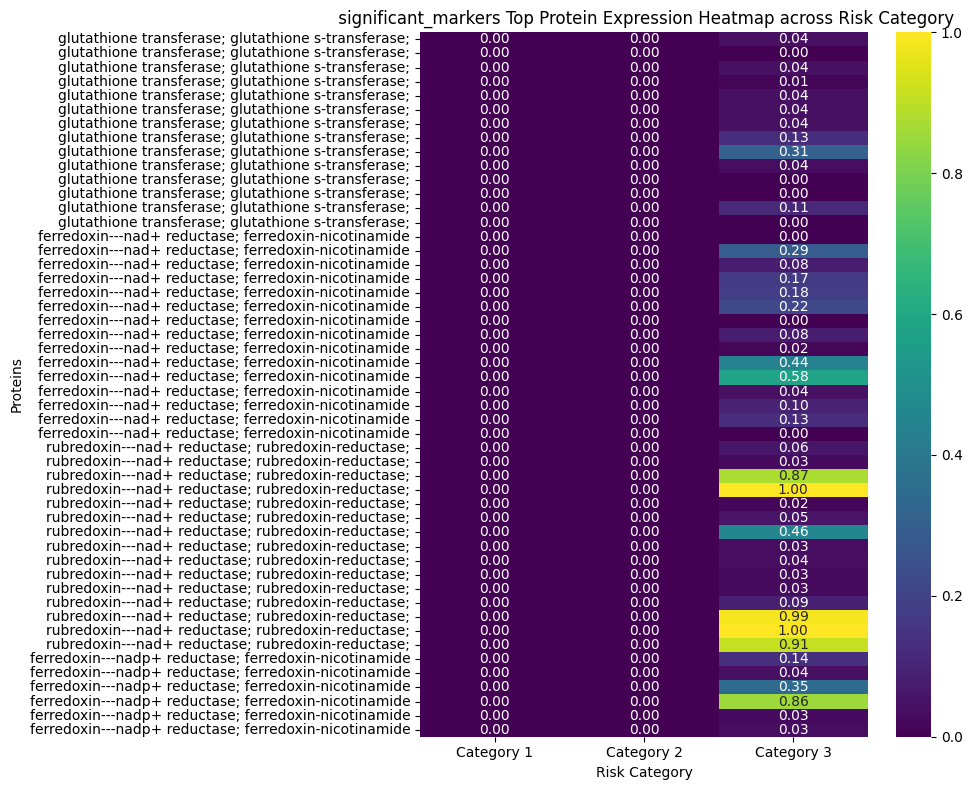

<Figure size 640x480 with 0 Axes>

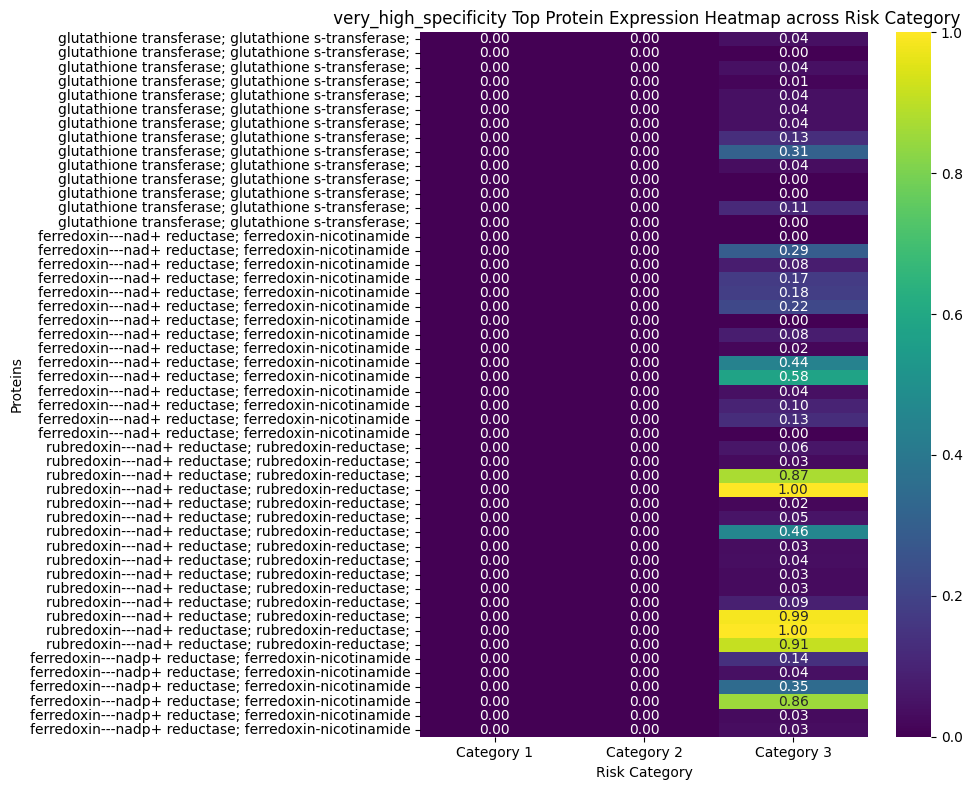

<Figure size 640x480 with 0 Axes>

In [39]:
plot_top_protein_heatmap(significant_markers, "significant_markers", 50)
plt.show()
output_path= shared_dir /"20_protein.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plot_top_protein_heatmap(very_high_specificity, "very_high_specificity", 50)
plt.show()

output_path= shared_dir /"21_protein.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

## 4.4. Top Markers by Score -
Bar chart showing the highest scoring markers

In [40]:
def plot_top_markers_by_score(prioritized_markers, name, top_n=20, figsize=(8, 6)):
    """
    Create a horizontal bar chart of top markers by score
    """
    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Create labels
    labels = [f"{row['Genus']} - {row['protein_name'][:100]}"
              for _, row in top_markers.iterrows()]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot horizontal bars
    plt.barh(range(len(labels)), top_markers['combined_score'], color='steelblue')

    # Add labels and title
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Combined Score')
    plt.title(f'{top_n} {name} Top Markers by Score')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return plt.gcf()

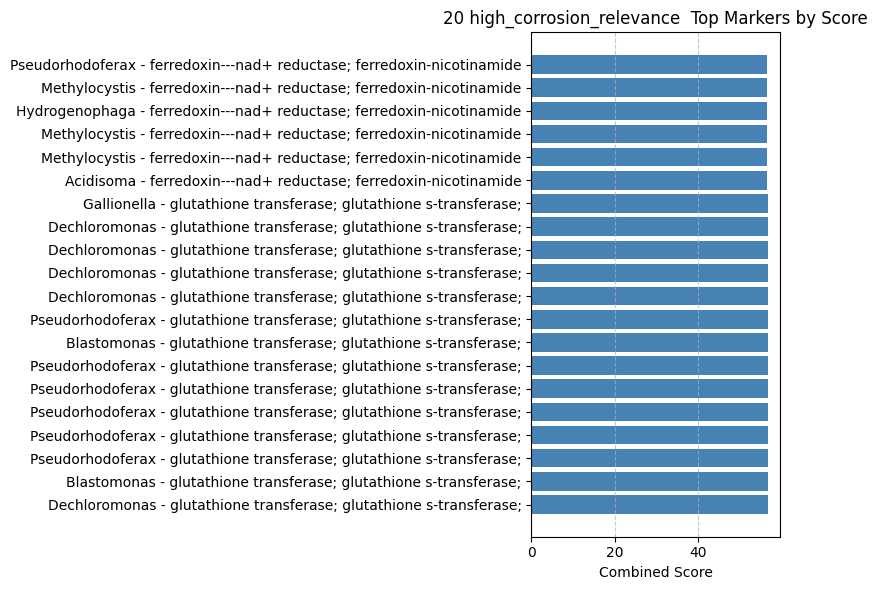

In [41]:
plot_top_markers_by_score(high_corrosion_relevance , "high_corrosion_relevance ", top_n=20, figsize=(8, 6))

prot_path = shared_dir/"22_prot-genus.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')

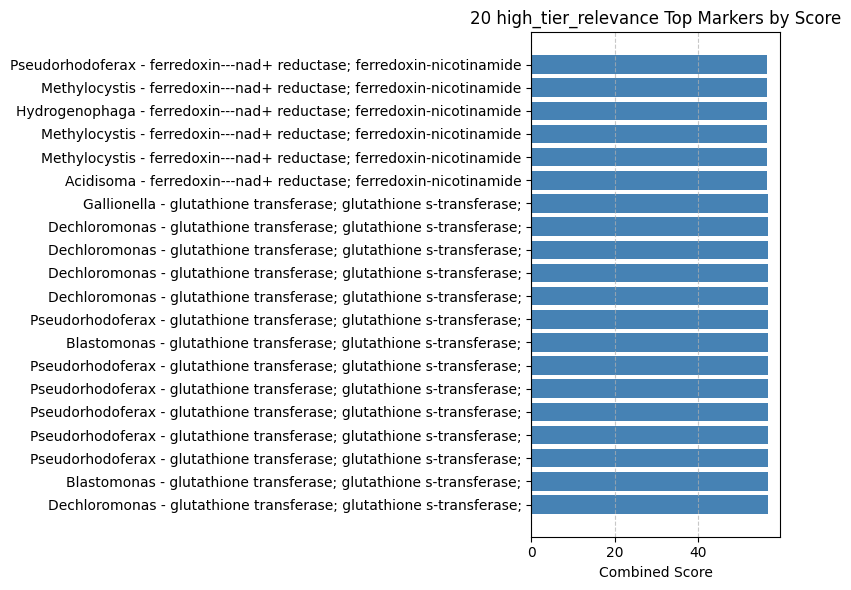

<Figure size 640x480 with 0 Axes>

In [42]:
plot_top_markers_by_score(high_tier_relevance , "high_tier_relevance", top_n=20, figsize=(8, 6))
plt.show()
prot_path = shared_dir/"23_prot-genus.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')

## 4.5. Top Proteins by Shared Genera

In [43]:
def plot_top_proteins_by_shared_genera(prioritized_markers, name, top_n=20, min_score=0, figsize=(12, 8)):
    """
    Create a horizontal bar plot showing proteins and all genera that express them.
    Sorted by combined score with better display of genera information.
    """
    # Filter by minimum score if needed
    if min_score > 0:
        prioritized_markers = prioritized_markers[prioritized_markers['combined_score'] >= min_score]
    
    # Create protein-genus mapping with ALL occurrences
    protein_genus_data = []
    
    for _, row in prioritized_markers.iterrows():
        protein_name = row['protein_name']
        genus = row['Genus']
        score = row['combined_score']
        
        # Standardize protein name
        if isinstance(protein_name, str):
            # Clean up protein names
            protein_name = protein_name.replace('[', '').replace(']', '').strip()
        
        protein_genus_data.append({
            'protein_name': protein_name,
            'genus': genus,
            'combined_score': score
        })
    
    df_mapping = pd.DataFrame(protein_genus_data)
    
    # Group by protein and aggregate ALL genera (don't limit to top_markers only)
    protein_analysis = df_mapping.groupby('protein_name').agg({
        'genus': lambda x: list(x.unique()),
        'combined_score': 'max'
    }).reset_index()
    
    # Add count of unique genera per protein
    protein_analysis['genus_count'] = protein_analysis['genus'].apply(len)
    
    # Sort by combined score and take top N
    protein_analysis = protein_analysis.sort_values('combined_score', ascending=False).head(top_n)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data for plotting
    y_positions = range(len(protein_analysis))
    scores = protein_analysis['combined_score']
    
    # Create horizontal bars
    bars = ax.barh(y_positions, scores, color='steelblue', alpha=0.7)
    
    # Create detailed labels
    labels = []
    for _, row in protein_analysis.iterrows():
        protein_name = row['protein_name']
        # Truncate very long protein names
        if len(protein_name) > 40:
            protein_name = protein_name[:37] + "..."
        
        # Format genera list
        genera = sorted(row['genus'])
        genus_count = row['genus_count']
        
        # Show all genera if 5 or less, otherwise show first 3 and count
        if genus_count <= 5:
            genera_display = ', '.join(genera)
        else:
            genera_display = f"{', '.join(genera[:3])}, ... (+{genus_count-3} more)"
        
        # Combine into label
        labels.append(f"{protein_name}\n({genus_count} genera: {genera_display})")
    
    # Set labels and formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Combined Score', fontsize=11)
    ax.set_title(f' Group {name}: Grouped Genera by Proteins Top {top_n}', fontsize=13)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}', 
                ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    return fig

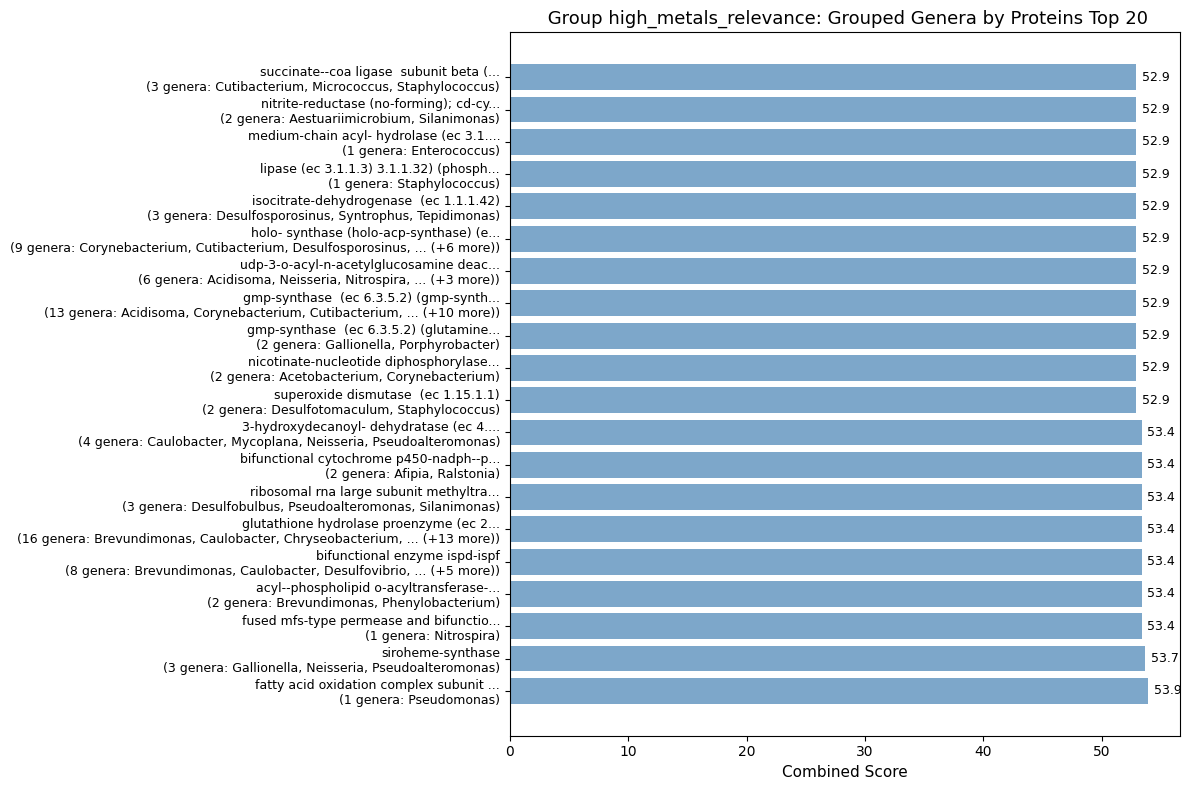

<Figure size 640x480 with 0 Axes>

In [44]:
fig1 = plot_top_proteins_by_shared_genera(high_metals_relevance,  "high_metals_relevance", top_n=20)
plt.figure(fig1.number)
plt.show()
prot_path = shared_dir/"24_prot-genus.png"
plt.savefig(prot_path, dpi=300, bbox_inches='tight')

## 4.6. Metal Involvement by Genus across Risk Categories
The plot_metal_involvement function creates a heatmap showing the relationship between bacterial genera and the specific metals they interact with, weighted by the combined score from prioritized markers.

In [45]:
def plot_metal_involvement_annotated(prioritized_markers):
    """
    Creates an annotated heatmap showing both presence and fold change.
    """
    metal_data = []
    
    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_consolidated'], str) and row['metals_consolidated']:
            for metal in cs.metal_terms:
                if any(term.lower() in str(row['metals_consolidated']).lower() 
                       for term in cs.metal_terms[metal]):
                    metal_data.append({
                        'Genus': row['Genus'],
                        'metal': metal,
                        'log2fc_3vs1': row['log2fc_3vs1'],
                        'prevalence': row['prevalence']
                    })
    
    metal_df = pd.DataFrame(metal_data)
    
    # Create pivot for fold change
    pivot_fc = metal_df.pivot_table(
        index='Genus',
        columns='metal',
        values='log2fc_3vs1',
        aggfunc='mean'
    ).fillna(0)
    
    # Create pivot for prevalence (for sizing)
    pivot_prev = metal_df.pivot_table(
        index='Genus',
        columns='metal',
        values='prevalence',
        aggfunc='mean'
    ).fillna(0)
    
    # Sort by absolute fold change
    genus_order = pivot_fc.abs().sum(axis=1).sort_values(ascending=False).index[:20]  # Top 20
    metal_order = pivot_fc.abs().sum().sort_values(ascending=False).index
    
    pivot_fc = pivot_fc.loc[genus_order, metal_order]
    pivot_prev = pivot_prev.loc[genus_order, metal_order]
    
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    ax = sns.heatmap(
        pivot_fc,
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'log2 Fold Change (Cat3 vs Cat1)'},
        vmin=-2, vmax=2,
        annot=True,  # Show values
        fmt='.1f',
        annot_kws={'size': 8}
    )
    
    # Add prevalence indicators (optional)
    for i, genus in enumerate(pivot_fc.index):
        for j, metal in enumerate(pivot_fc.columns):
            if pivot_prev.loc[genus, metal] > 0.5:  # High prevalence
                ax.add_patch(plt.Rectangle((j, i), 1, 1, 
                                         fill=False, edgecolor='black', 
                                         lw=2, alpha=0.5))
    
    plt.title('Metal Involvement: Fold Change with Prevalence Indicators', fontsize=16)
    plt.xlabel('Metal Category', fontsize=12)
    plt.ylabel('Genus (Top 20)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return plt.gcf()

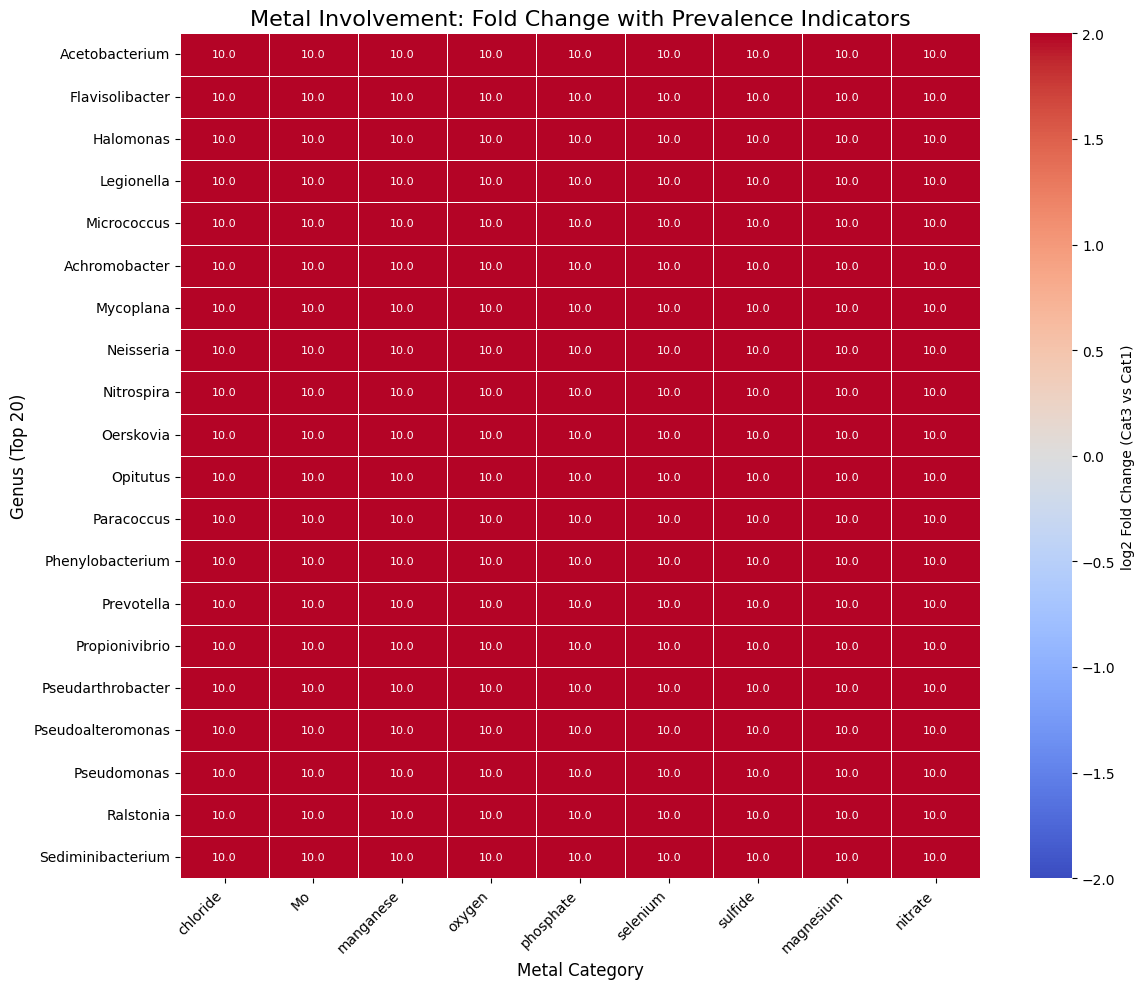

In [46]:

plot_metal_involvement_annotated(metal_iron_sulfur)
plt.show()

In [47]:
def plot_metal_involvement_by_category(prioritized_markers):
    """
    Creates multiple heatmaps showing metal involvement progression across categories.
    """
    metal_data = []
    
    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_consolidated'], str) and row['metals_consolidated']:
            metals = [m.strip() for m in row['metals_consolidated'].split(';')]
            
            for metal in cs.metal_terms:
                if any(term.lower() in str(row['metals_consolidated']).lower() 
                       for term in cs.metal_terms[metal]):
                    metal_data.append({
                        'Genus': row['Genus'],
                        'metal': metal,
                        'Category 1': row['mean_cat1'],
                        'Category 2': row['mean_cat2'],
                        'Category 3': row['mean_cat3'],
                        'fold_change_3vs1': row['fold_change_3vs1']
                    })
    
    metal_df = pd.DataFrame(metal_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    
    # Create heatmaps for each category
    for idx, (cat, ax) in enumerate(zip(['Category 1', 'Category 2', 'Category 3'], axes)):
        pivot = metal_df.pivot_table(
            index='Genus',
            columns='metal',
            values=cat,
            aggfunc='mean'
        ).fillna(0)
        
        # Sort consistently across all panels
        if idx == 0:
            genus_order = pivot.sum(axis=1).sort_values(ascending=False).index
            metal_order = pivot.sum().sort_values(ascending=False).index
        
        pivot = pivot.loc[genus_order, metal_order]
        
        sns.heatmap(
            pivot,
            cmap='viridis',
            linewidths=0.5,
            cbar_kws={'label': 'Mean Abundance'},
            ax=ax,
            vmin=0,  # Set consistent scale
            vmax=metal_df[cat].max()
        )
        
        ax.set_title(f'{cat}', fontsize=14)
        ax.set_xlabel('Metal Category' if idx == 1 else '', fontsize=12)
        ax.set_ylabel('Genus' if idx == 0 else '', fontsize=12)
        
        if idx > 0:
            ax.set_yticklabels([])
    
    plt.suptitle('Metal Involvement Progression Across Risk Categories', fontsize=16)
    plt.tight_layout()
    
    return fig

/tmp/ipykernel_10129/4114082912.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



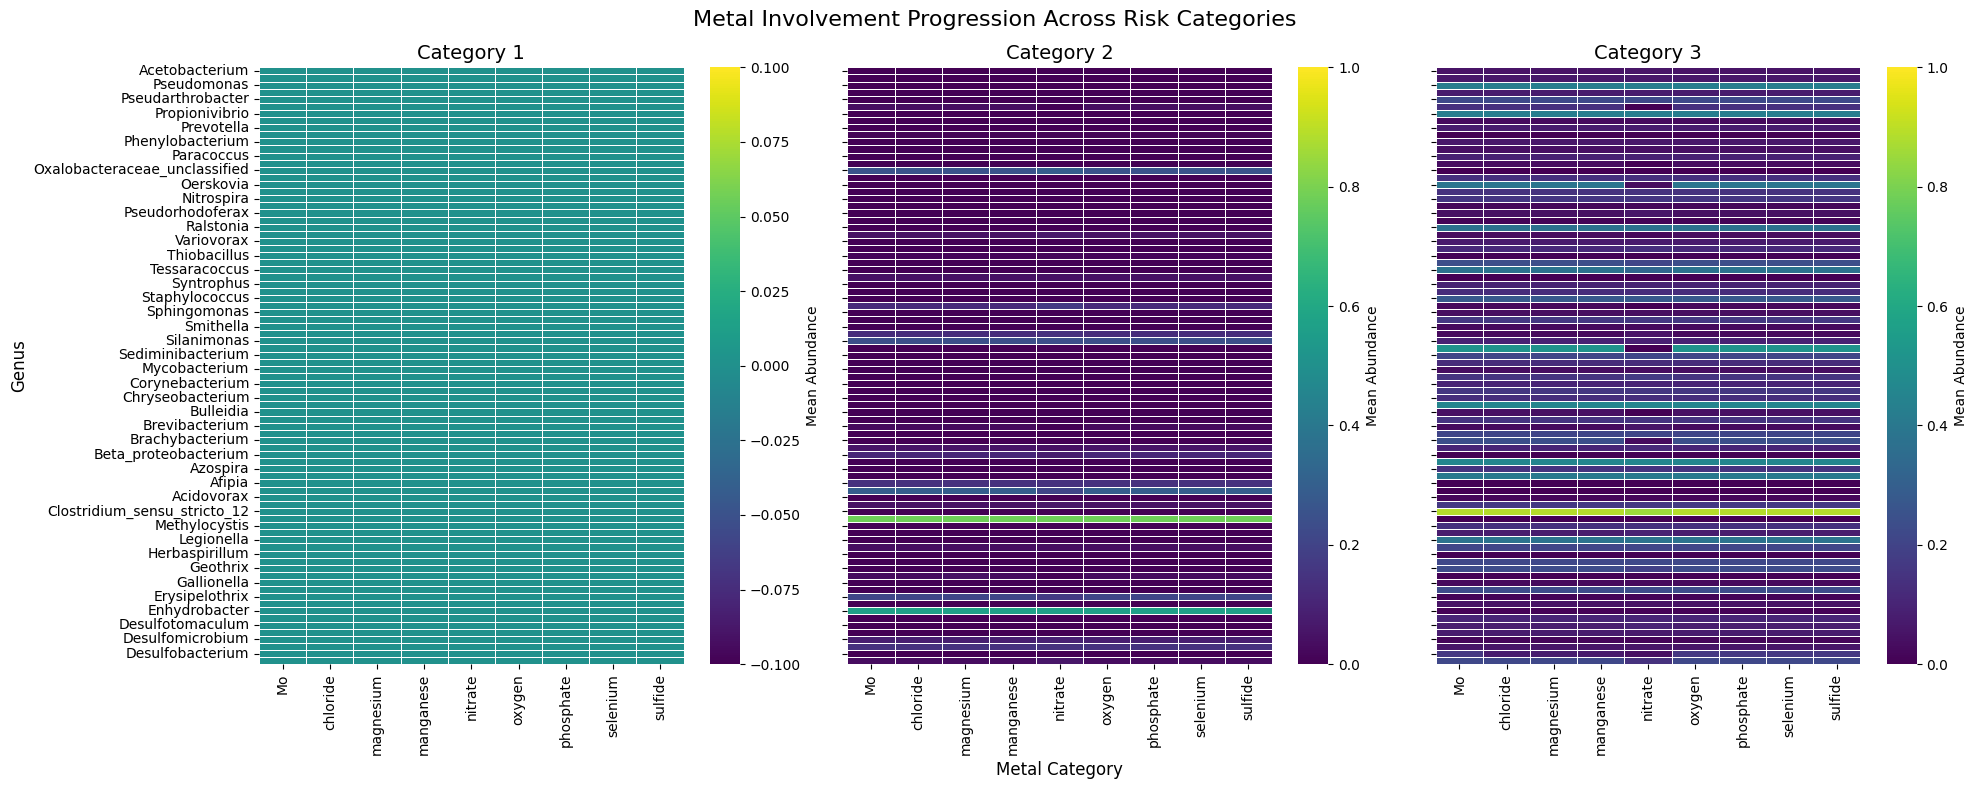

In [48]:
plot_metal_involvement_by_category(metals_consolidated)
fig.show()

# 5. Network Analysis

## 5.1 Network Analysis of Corrosion Mechanisms

In [49]:
def create_static_network(df, name, top_n=20, threshold=0.5):
    """
    Creates an improved static network visualization of genus-protein-mechanism relationships.
    
    Args: df: DataFrame containing marker data with required columns
          name: Name to include in plot title
          top_n: Number of top markers to include
          threshold: Edge weight threshold (0.0-1.0)
    Returns:  G: NetworkX graph object
    """
    # Define colors for node types with improved color scheme
    node_colors = {'genus': 'Blue', 'protein': 'Purple',  'mechanism': 'Brown' }
    
    # Check required columns
    required_cols = ['Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None
    
    # Create network
    G = nx.Graph()
    
    # Get top markers
    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)
    
    # Process rows and build network
    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])
        
        # Skip if missing data
        if pd.isna(genus) or pd.isna(protein):
            continue
            
        # Trim protein name if too long
        protein_short = protein[:27] + "..." if len(protein) > 30 else protein
        
        # Add nodes if they don't exist
        if not G.has_node(genus):
            G.add_node(genus, type='genus')
        
        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')
        
        # Add edge between genus and protein with weight from score
        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        # Normalize score for visualization if needed
        norm_score = min(score / 50, 1.0)  # Adjust divisor based on your score range
        G.add_edge(genus, protein_short, weight=norm_score)
        
        # Add mechanism nodes and edges
        mechanisms_col = row.get('corrosion_mechanisms', '')
        if isinstance(mechanisms_col, str) and mechanisms_col:
            mechanisms = [mech.strip() for mech in mechanisms_col.split(';') if mech.strip()]
            for mech in mechanisms:
                if not G.has_node(mech):
                    G.add_node(mech, type='mechanism')
                G.add_edge(protein_short, mech, weight=0.7)  # Set standard weight for mechanism connections
    
    # Detect communities for node coloring
    partition = community_louvain.best_partition(G)
    
    # Assign communities to nodes
    nx.set_node_attributes(G, partition, 'community')
    
    # Calculate node sizes based on degree centrality
    degree_dict = dict(G.degree())
    # Scale node sizes - genera larger than proteins larger than mechanisms
    node_sizes = {}
    for node in G.nodes():
        base_size = 800 if G.nodes[node].get('type') == 'genus' else (
                    500 if G.nodes[node].get('type') == 'protein' else 600)
        # Adjust size by degree with diminishing returns for very high degrees
        node_sizes[node] = base_size * (1 + np.log1p(degree_dict[node]) / 2)
    
    # Prepare for visualization with larger figure size
    plt.figure(figsize=(18, 14))
    
    # Position nodes using force-directed layout with increased separation
    pos = nx.spring_layout(G, k=0.5, seed=42, iterations=100)  # Increased k and iterations
    
    # Draw edges with width based on weight
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=edge_weights)
    
    # Draw nodes by type with different colors
    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, 
                              nodelist=nodes, 
                              node_color=color,
                              node_size=[node_sizes[node] for node in nodes],
                              alpha=0.85)
    # Genus labels - bold
    genera_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'}
    nx.draw_networkx_labels(G, pos, labels=genera_labels, font_size=12, font_weight='bold', 
                           font_color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # Protein labels - smaller, no bbox
    protein_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'protein'}
    nx.draw_networkx_labels(G, pos, labels=protein_labels, font_size=8, 
                           font_color='black')
    
    # Mechanism labels - medium size, with bbox
    mech_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'mechanism'}
    nx.draw_networkx_labels(G, pos, labels=mech_labels, font_size=10, 
                           font_color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))
    
    # Create legend with larger markers
    plt.plot([0], [0], 'o', color=node_colors['genus'], markersize=12, label='Genus')
    plt.plot([0], [0], 'o', color=node_colors['protein'], markersize=10, label='Protein')
    plt.plot([0], [0], 'o', color=node_colors['mechanism'], markersize=11, label='Mechanism')
    
    plt.legend(loc='upper right', frameon=True, fontsize=12)
    plt.title(f"{name} Network of Top {top_n} Corrosion Markers", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    
    # Add a white background to make the visualization more printable
    plt.gca().set_facecolor('white')
    plt.gcf().set_facecolor('white')
    
    return G

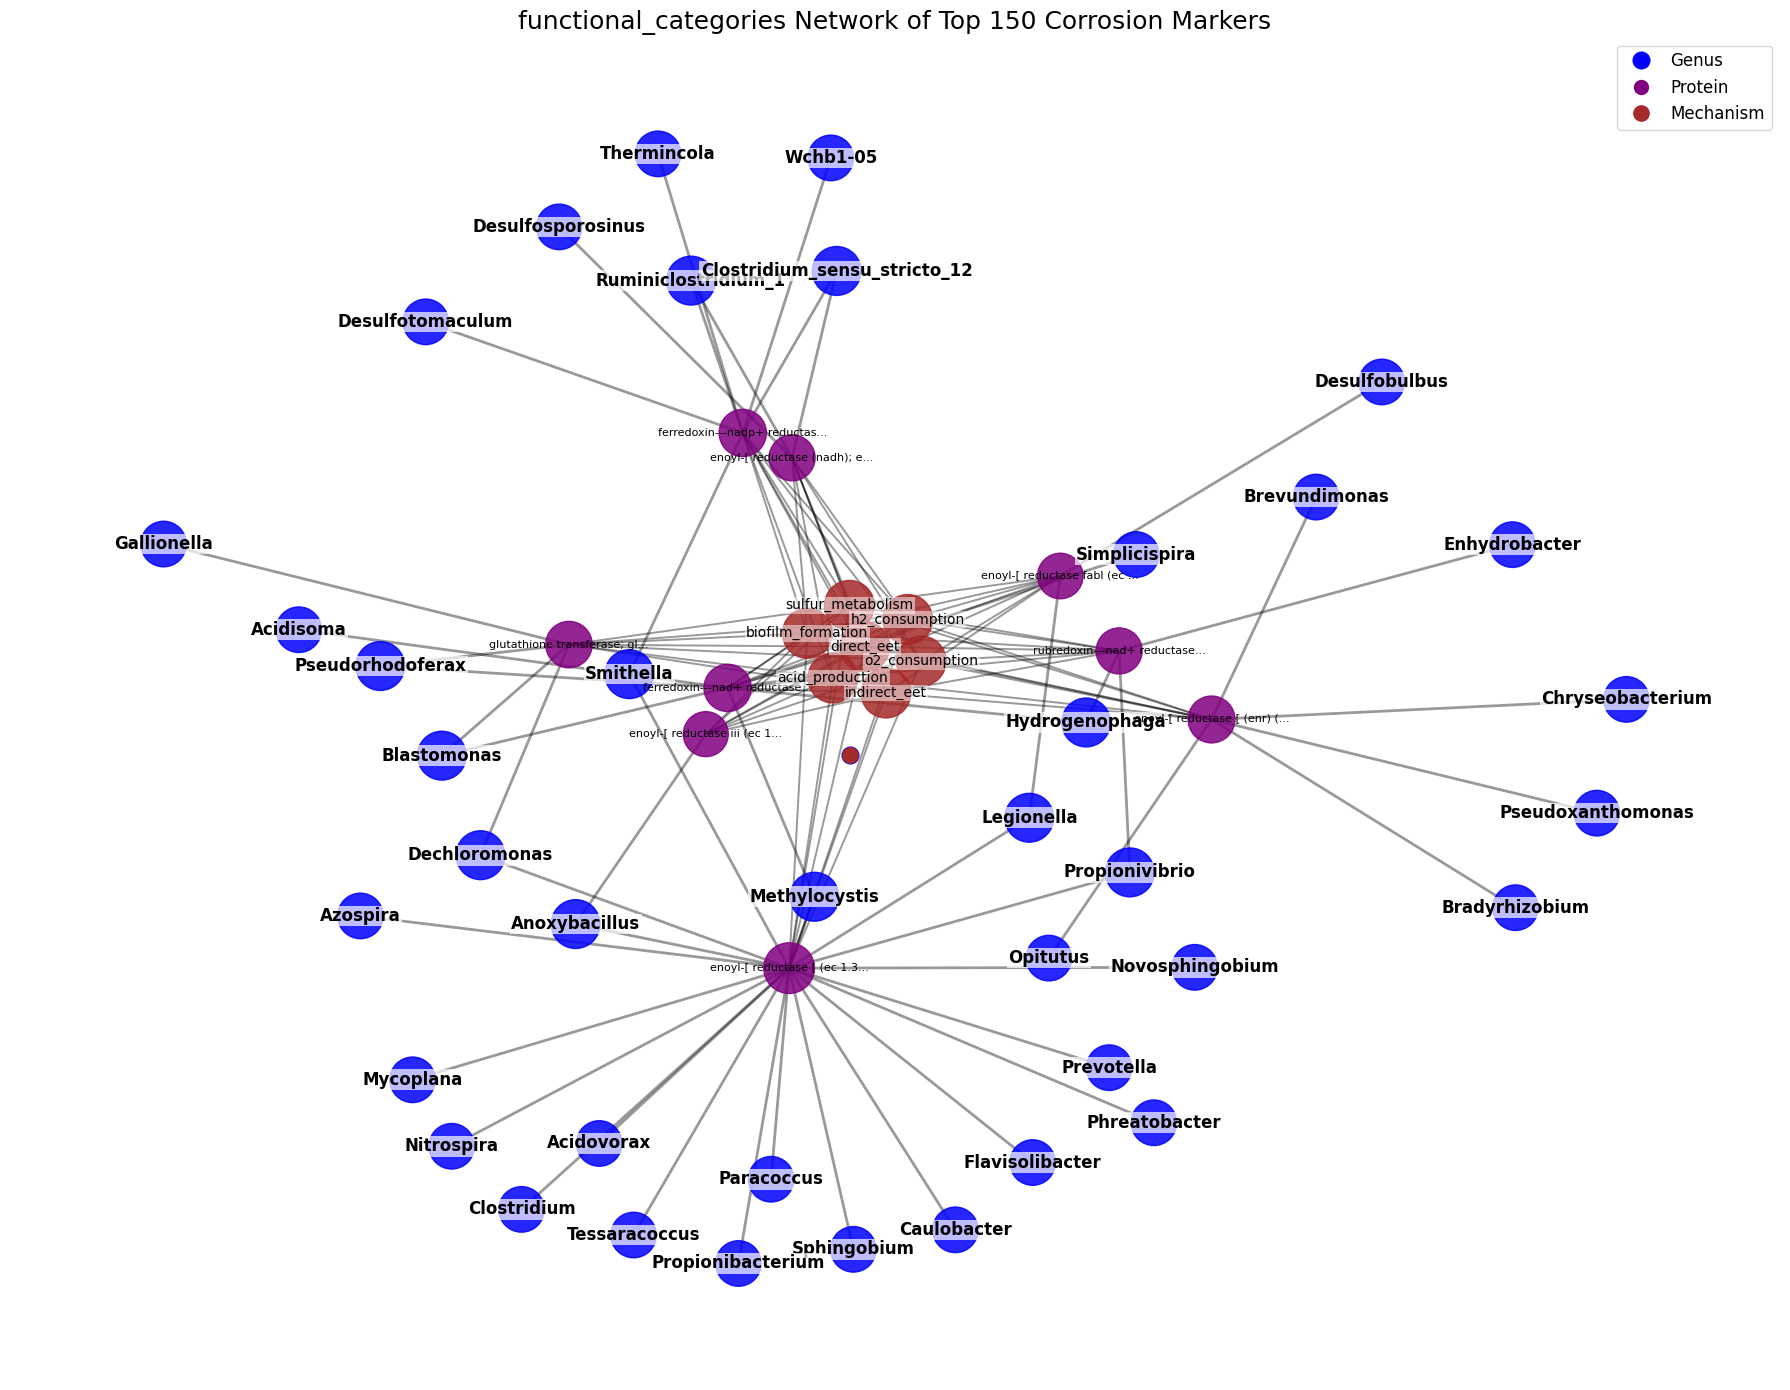

In [50]:
create_static_network(functional_categories,"functional_categories" ,top_n=150, threshold=0.5)
output_path = shared_dir / "7_network.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

This plot corresponds to the network of the group functional_categories which is the result of the filtration of the pipeline in the previous notebook and contain the genera and protein in the data associated by functional categories, that means no all the risk categories are present but mostly 2 and 3. The plot shows some important insides that reinforce the importance of the top proteins at this stage of filtration. First they are being expressed by multiple bacteria, for instance the enoyll reductasa and variants (there are 3 variants of that making it like 4 nodes) that connects to most of the genera and to all of the mechamismis.

The enoyl reductase variants (appearing as 3-4 nodes) are central hubs. These enzymes modify fatty acids in response to oxidative stress which enhances cellular membrane integrity that is a critical defense against metal surface colonization.  The multiple variants suggest evolutionary pressure to maintain this function across different bacterial species. Their universal connection to all mechanisms indicates they're part of a core stress response system.

The ferredoxin-NAD+ reductase proteins (appearing with slight name variations) are particularly important because they're directly involved in electron transfer processes. These proteins can shuttle electrons from metal surfaces to cellular metabolism. In order to mantain the reducing condition at the biofim metal interface the NAD+/NADH redox couple plays a crucial role. This redox conditions power other procesess that acelerate corrosion by creating electrochemical gradients.
The rubredoxin-NAD+ Reductase suggests an active iron-sulfur cluster metabolism near the metal surface. These clusters can act as electron shuttles in direct electron uptake from metals. This protein is particularly stable in harsh conditions (low pH, high metal concentrations) typical of corrosion sites.
Glutathione Transferase presence linking multiple bacteria indicates an active detoxification of metal ions released during corrosion. The bacteria protects itself from reactive oxygen species generated at corroding surfaces and in doing so play a role in biofilm matrix production (glutathione helps stabilize extracellular polymers)

Interestingly mechamisms cluster in the center while genera spread peripherally which suggests functional convergence. That is different bacteria employ similar mechanisms. That means this metabolic redundancy signify that the biofilm community has backup systems in which they biofilm nurture the bacteria through synergistic corrosion. Then multiple species contribute to the same corrosion processes.

In principle it could be understood that the initial colonization bacteria experience stress by oxidative environment from the metal surface. That is when the enoyl reductases modify the membrane for better adhesion and protection. The ferredoxin and rubredoxin proteins extract the electrons from the metal which could be as the last electron acceptor. Those electrons fuel several metabolic proceses amongst them the glutatione systems which protect the community from metal toxicity. 

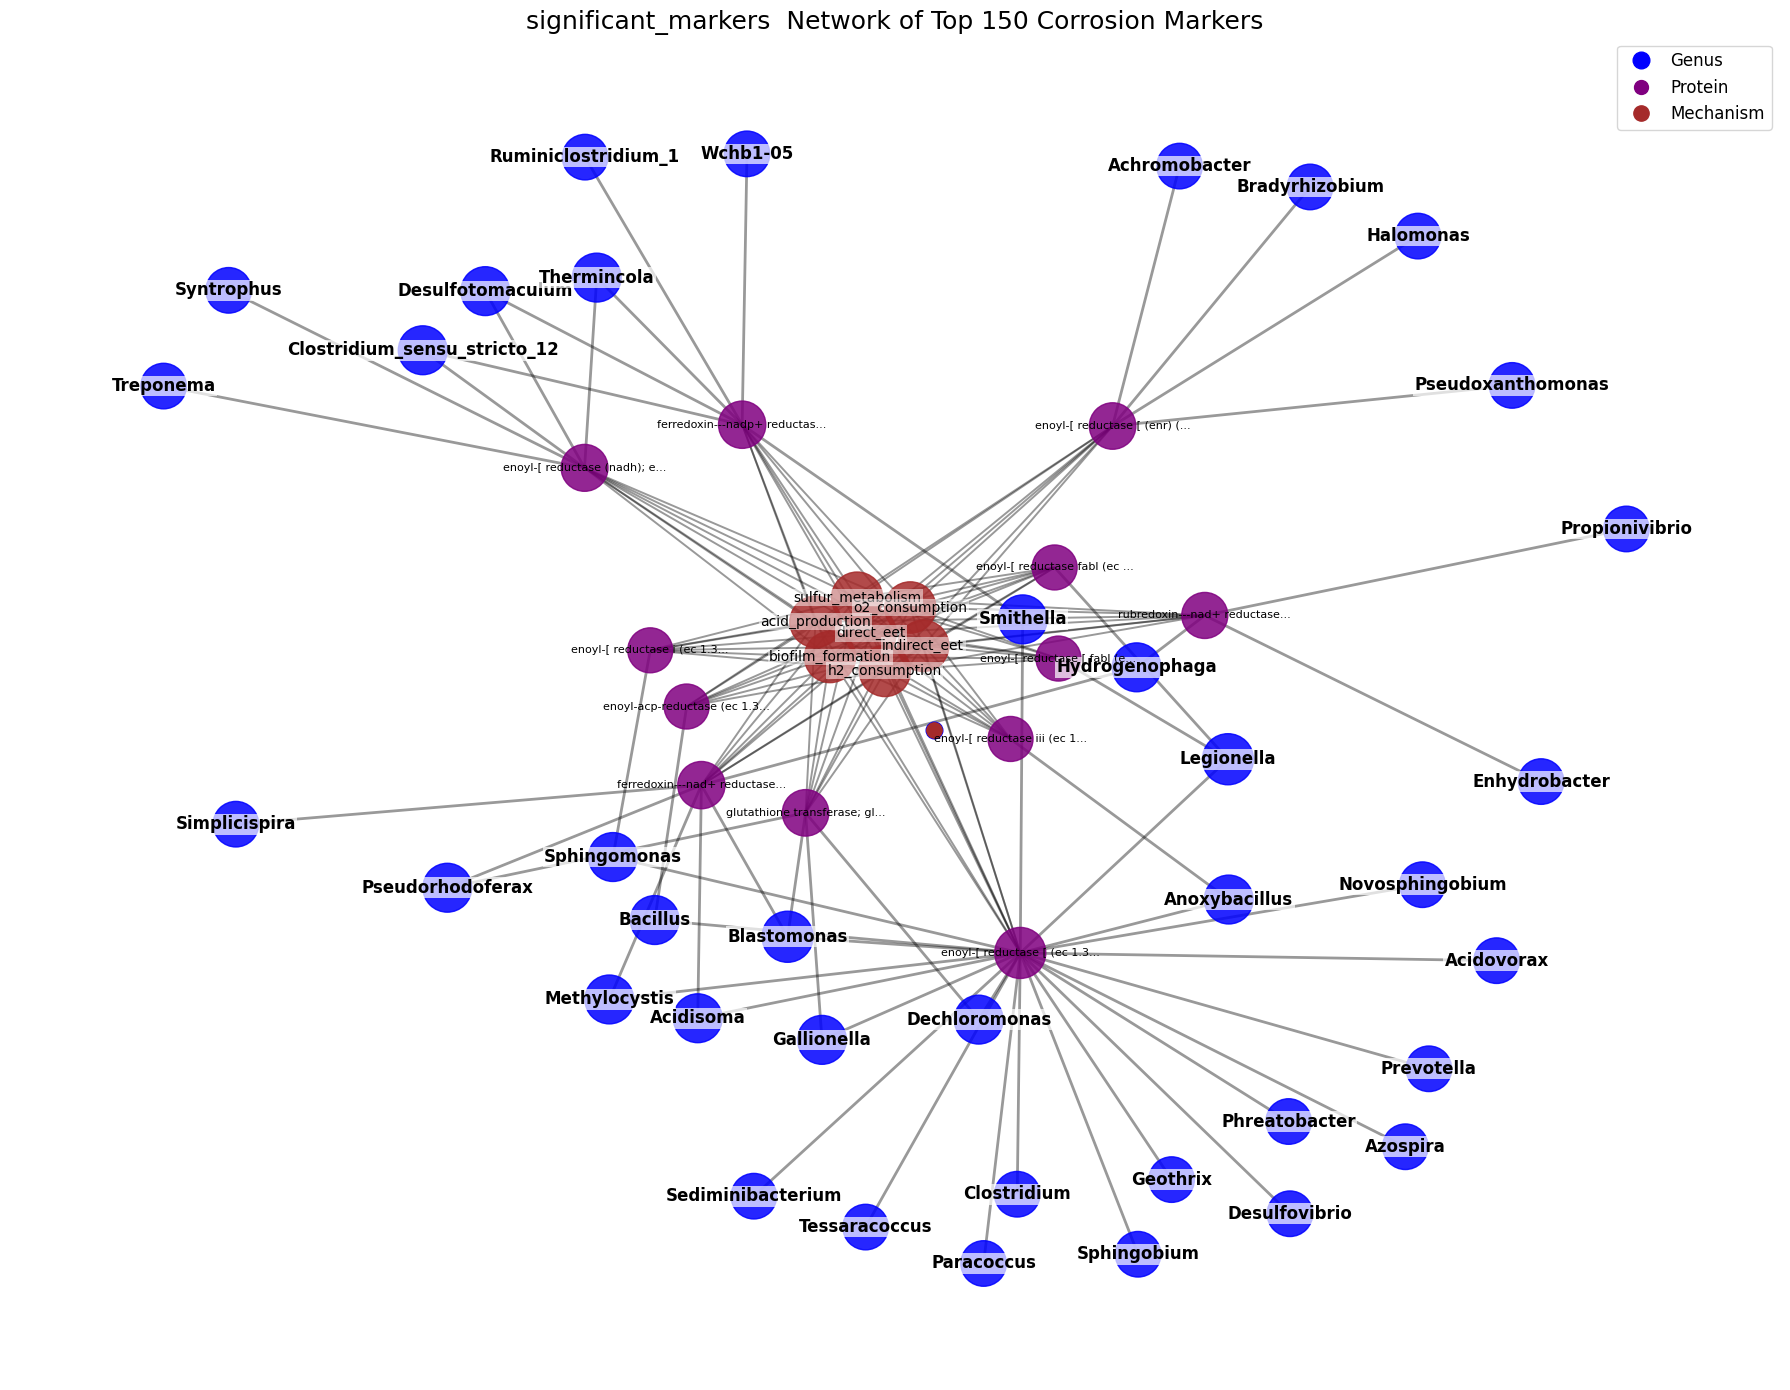

In [51]:
create_static_network(significant_markers,"significant_markers " ,top_n=150, threshold=0.5)
output_path = shared_dir / "8_network.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

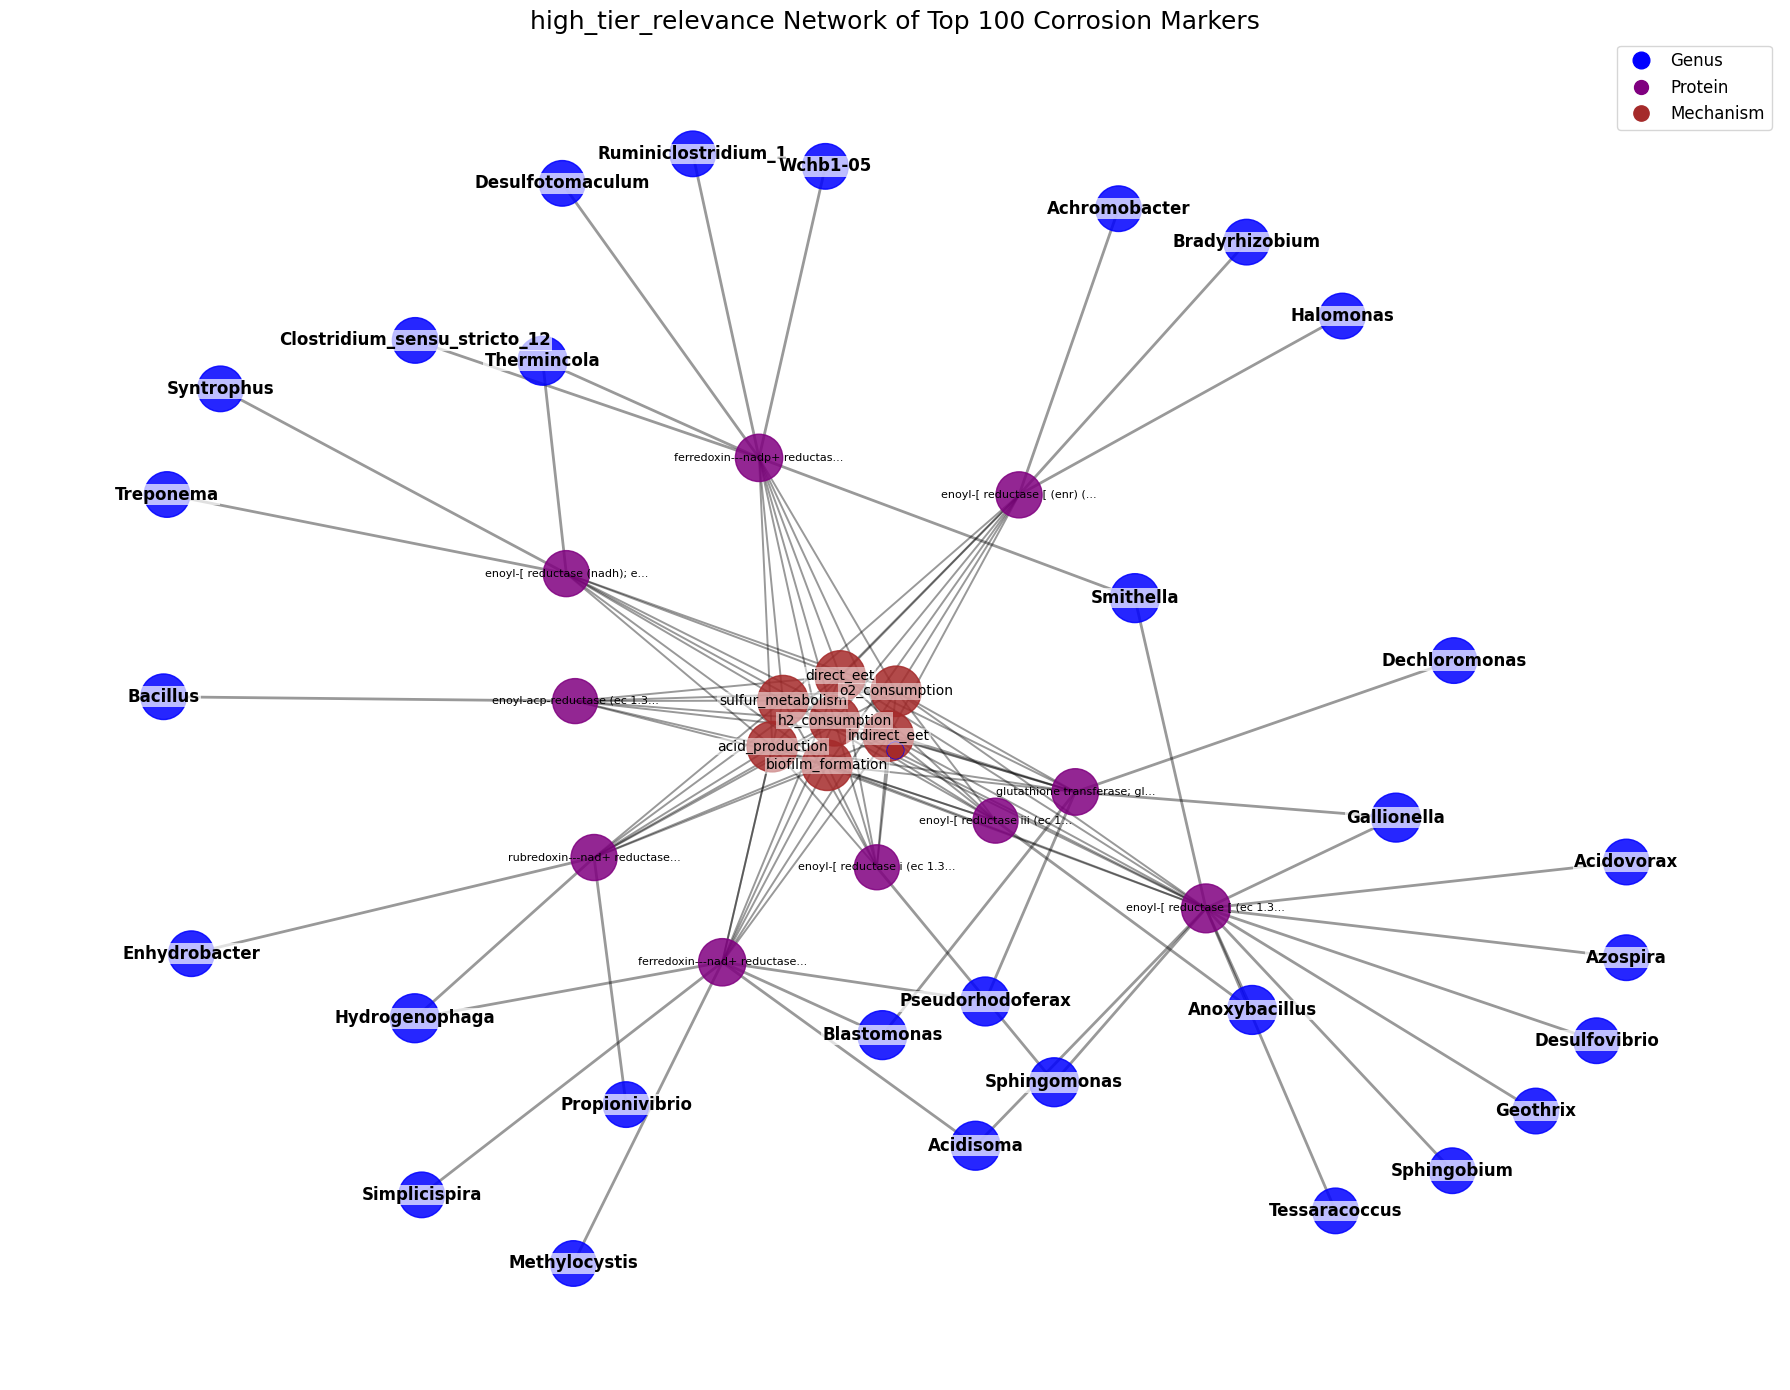

In [52]:
create_static_network(high_tier_relevance,"high_tier_relevance" ,top_n=100, threshold=0.5)
output_path = shared_dir / "9_network.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

## 5.2. Network Analysis Protein-Genus Pairs

In [53]:

def create_static_network(df, name, top_n=20, threshold=0.5, category_col='functional_categories',  protein_label_legend=True):
    """
    Creates a static network visualization of genus-protein-category relationships.

    Args:    df: DataFrame containing marker data
        name: Name for the network plot
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)
        category_col: Column name for functional categories (default 'corrosion_mechanisms')
        protein_label_legend: If True, shows proteins in legend instead of labeling nodes.

    Returns:        G: NetworkX graph object
    """

    node_colors = { 'genus': '#2196F3',     'protein': '#4CAF50',    'category': '#FF5722' }

    required_cols = ['Genus', 'protein_name', 'combined_score', category_col]
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None

    G = nx.Graph()

    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)
    
    protein_labels = {}

    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])

        if pd.isna(genus) or pd.isna(protein):
            continue

        protein_short = protein[:27] + "..." if len(protein) > 30 else protein

        if not G.has_node(genus):
            G.add_node(genus, type='genus')

        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')
            protein_labels[protein_short] = protein

        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        if score >= threshold:
            G.add_edge(genus, protein_short, weight=score)

        category_data = row.get(category_col, '')
        if isinstance(category_data, str) and category_data:
            for cat in category_data.split(';'):
                cat = cat.strip()
                if cat:
                    if not G.has_node(cat):
                        G.add_node(cat, type='category')
                    G.add_edge(protein_short, cat, weight=1.0)

    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, k=0.3, seed=42)

    nx.draw_networkx_edges(G, pos, alpha=0.4)

    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                               node_size=500 if node_type == 'genus' else 300)

    # Labels
    labels_to_draw = {}
    if not protein_label_legend:
        labels_to_draw.update({n: protein_labels.get(n, n) for n in G.nodes() if G.nodes[n].get('type') == 'protein'})

    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'})
    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'category'})

    nx.draw_networkx_labels(G, pos, labels=labels_to_draw, font_size=8)

    # Create legend
    genus_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'genus']
    protein_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'protein']
    category_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'category']

    # Draw with labels for legend
    nx.draw_networkx_nodes(G, pos, nodelist=genus_nodes, node_color=node_colors['genus'], 
                        node_size=500, label='Genus')
    nx.draw_networkx_nodes(G, pos, nodelist=protein_nodes, node_color=node_colors['protein'], 
                        node_size=300, label='Protein')
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color=node_colors['category'], 
                        node_size=300, label=category_col.replace('_', ' ').title())

    plt.legend()

    # If proteins are not labeled directly, print them
    if protein_label_legend:
        print("\nProtein nodes:")
        for short, full in protein_labels.items():
            print(f"{short}: {full}")

    plt.title(f"{name} Network of Top {top_n} Corrosion Markers")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G



Network statistics:
  Total nodes: 26
  Total edges: 80
  Network density: 0.246


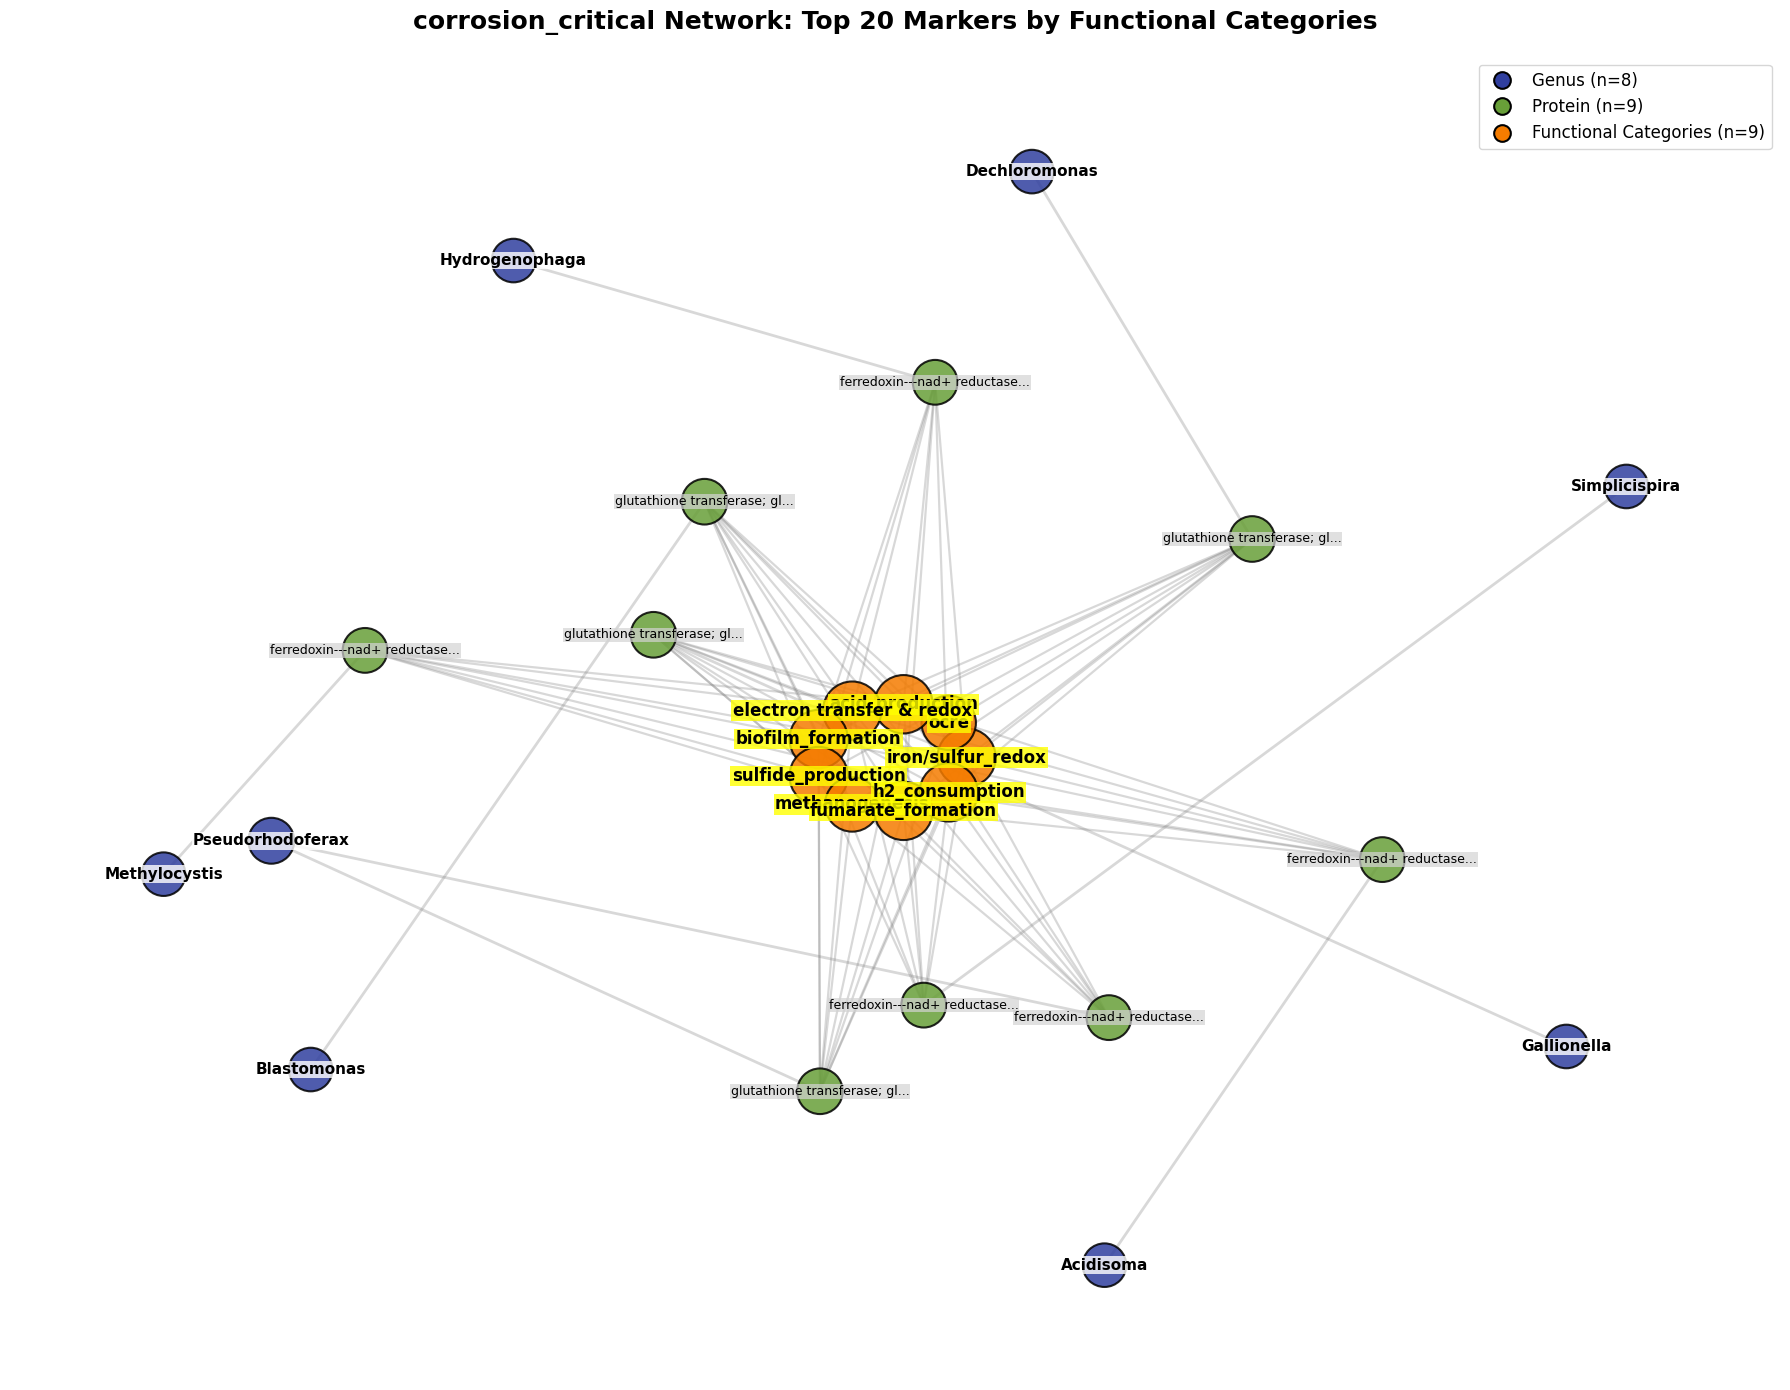

In [57]:
def create_dynamic_network(df, name, top_n=20, threshold=0.5, center_category='corrosion_mechanisms',
                                                        node_label_config=None):
    """
    Creates a dynamic network visualization where the center category can be changed.
    
    Args:  df: DataFrame containing marker data, name: Name for the network plot
        top_n: Number of top markers to include, threshold: Edge weight threshold (0.0-1.0)
        center_category: Column name for the category to show in center   (e.g., 'corrosion_mechanisms', 'functional_categories', 
                         'pathways', 'synergies', etc.)
        node_label_config: Dict specifying which node types to label: {'genus': True, 'protein': True, 'category': True}
    
    Returns:  G: NetworkX graph object
    """
    
    # Default label configuration
    if node_label_config is None:
        node_label_config = {
            'genus': True,
            'protein': True,
            'category': True
        }
    
    # Dynamic color scheme based on category type
    color_schemes = {
        'corrosion_mechanisms': {
            'genus': '#1976D2',      # Deep blue
            'protein': '#388E3C',    # Forest green  
            'category': '#D32F2F'    # Deep red
        },
        'functional_categories': {
            'genus': '#303F9F',      # Indigo
            'protein': '#689F38',    # Light green
            'category': '#F57C00'    # Orange
        },
        'pathways': {
            'genus': '#0288D1',      # Light blue
            'protein': '#7B1FA2',    # Purple
            'category': '#C2185B'    # Pink
        },
        'synergies': {
            'genus': '#00796B',      # Teal
            'protein': '#5D4037',    # Brown
            'category': '#FFA000'    # Amber
        }
    }
    
    # Use appropriate color scheme or default
    node_colors = color_schemes.get(center_category, color_schemes['corrosion_mechanisms'])
    
    # Check required columns
    required_cols = ['Genus', 'protein_name', 'combined_score', center_category]
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None
    
    # Create network
    G = nx.Graph()
    
    # Get top markers
    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)
    
    # Store full protein names for reference
    protein_full_names = {}
    protein_to_genera = {}  # Track which genera connect to which proteins
    
    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])
        
        if pd.isna(genus) or pd.isna(protein):
            continue
        
        # Create unique protein identifier to avoid merging different proteins
        protein_id = f"{protein}_{genus[:3]}"  # Add genus prefix for uniqueness
        
        # Store full name
        protein_full_names[protein_id] = protein
        
        # Add nodes
        if not G.has_node(genus):
            G.add_node(genus, type='genus', label=genus)
        
        if not G.has_node(protein_id):
            G.add_node(protein_id, type='protein', 
                      full_name=protein,
                      label=protein if len(protein) <= 30 else protein[:27] + "...")
        
        # Track genus-protein relationships
        if protein_id not in protein_to_genera:
            protein_to_genera[protein_id] = []
        protein_to_genera[protein_id].append(genus)
        
        # Add edge with weight
        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        norm_score = min(score / 50, 1.0)  # Normalize score
        G.add_edge(genus, protein_id, weight=norm_score)
        
        # Add category nodes and edges
        category_data = row.get(center_category, '')
        if isinstance(category_data, str) and category_data:
            categories = [cat.strip() for cat in category_data.split(';') if cat.strip()]
            for cat in categories:
                if not G.has_node(cat):
                    G.add_node(cat, type='category', label=cat)
                G.add_edge(protein_id, cat, weight=0.8)
    
    # Calculate layout with categories in center, position categories in a circle in the center
    category_nodes = [n for n in G.nodes() if G.nodes[n].get('type') == 'category']
    n_categories = len(category_nodes)
    
    # Create custom layout
    pos = {}
    
    # Place categories in center
    if n_categories > 0:
        angles = np.linspace(0, 2 * np.pi, n_categories, endpoint=False)
        for i, cat in enumerate(category_nodes):
            pos[cat] = (0.3 * np.cos(angles[i]), 0.3 * np.sin(angles[i]))
    
    # Use spring layout for other nodes with fixed category positions
    if category_nodes:
        other_pos = nx.spring_layout(G, k=1.5, pos=pos, fixed=category_nodes, 
                                    seed=42, iterations=100)
        pos.update(other_pos)
    else:
        pos = nx.spring_layout(G, k=1.0, seed=42, iterations=100)
    
    # Create figure
    plt.figure(figsize=(18, 14))
    
    # Draw edges with varying width
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_weights, edge_color='gray')
    
    # Calculate node sizes based on degree
    degree_dict = dict(G.degree())
    node_sizes = {}
    for node in G.nodes():
        node_type = G.nodes[node].get('type')
        base_size = {'genus': 800, 'protein': 600, 'category': 1000}.get(node_type, 500)
        node_sizes[node] = base_size * (1 + np.log1p(degree_dict[node]) / 3)
    
    # Draw nodes by type
    for node_type in ['genus', 'protein', 'category']:
        nodes = [n for n in G.nodes() if G.nodes[n].get('type') == node_type]
        if nodes:
            nx.draw_networkx_nodes(G, pos, 
                                  nodelist=nodes,
                                  node_color=node_colors[node_type],
                                  node_size=[node_sizes[n] for n in nodes],
                                  alpha=0.85,
                                  edgecolors='black',
                                  linewidths=1.5)
    
    # Draw labels based on configuration
    labels = {}
    font_configs = {
        'genus': {'size': 11, 'weight': 'bold', 'bbox': dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1)},
        'protein': {'size': 9, 'weight': 'normal', 'bbox': dict(facecolor='lightgray', alpha=0.7, edgecolor='none', pad=0.5)},
        'category': {'size': 12, 'weight': 'bold', 'bbox': dict(facecolor='yellow', alpha=0.8, edgecolor='none', pad=1)}
    }
    
    for node_type, should_label in node_label_config.items():
        if should_label:
            nodes = [n for n in G.nodes() if G.nodes[n].get('type') == node_type]
            node_labels = {n: G.nodes[n].get('label', n) for n in nodes}
            
            if node_labels:
                font_config = font_configs.get(node_type, {})
                nx.draw_networkx_labels(G, pos, 
                                       labels=node_labels,
                                       font_size=font_config.get('size', 10),
                                       font_weight=font_config.get('weight', 'normal'),
                                       bbox=font_config.get('bbox', None))
    
    # Create detailed legend
    legend_elements = []
    node_counts = {
        'genus': len([n for n in G.nodes() if G.nodes[n].get('type') == 'genus']),
        'protein': len([n for n in G.nodes() if G.nodes[n].get('type') == 'protein']),
        'category': len([n for n in G.nodes() if G.nodes[n].get('type') == 'category'])
    }
    
    # Add legend entries with counts
    legend_labels = {
        'genus': f'Genus (n={node_counts["genus"]})',
        'protein': f'Protein (n={node_counts["protein"]})',
        'category': f'{center_category.replace("_", " ").title()} (n={node_counts["category"]})'
    }
    
    for node_type, color in node_colors.items():
        if node_counts[node_type] > 0:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                            markerfacecolor=color, markersize=12,
                                            label=legend_labels[node_type],
                                            markeredgecolor='black', markeredgewidth=1.5))
    
    plt.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True)
    
    # Title with category info
    plt.title(f"{name} Network: Top {top_n} Markers by {center_category.replace('_', ' ').title()}", 
              fontsize=18, fontweight='bold', pad=20)
    
    plt.axis('off')
    plt.tight_layout()
    
    # Print protein information if not all are labeled
    if not node_label_config.get('protein', True):
        print(f"\n{'='*80}")
        print(f"PROTEIN INFORMATION (Full Names)")
        print(f"{'='*80}")
        
        # Sort proteins by number of connections
        protein_connections = {}
        for protein_id, full_name in protein_full_names.items():
            if protein_id in G:
                connections = degree_dict.get(protein_id, 0)
                genera = protein_to_genera.get(protein_id, [])
                protein_connections[protein_id] = (full_name, connections, genera)
        
        # Sort by number of connections
        sorted_proteins = sorted(protein_connections.items(), 
                               key=lambda x: x[1][1], reverse=True)
        
        for protein_id, (full_name, connections, genera) in sorted_proteins:
            print(f"\n{full_name}")
            print(f"  Connections: {connections}")
            print(f"  Expressed by: {', '.join(genera)}")
            
            # Get connected categories
            connected_cats = [n for n in G.neighbors(protein_id) 
                            if G.nodes[n].get('type') == 'category']
            if connected_cats:
                print(f"  {center_category.replace('_', ' ').title()}: {', '.join(connected_cats)}")
    
    print(f"\nNetwork statistics:")
    print(f"  Total nodes: {len(G.nodes())}")
    print(f"  Total edges: {len(G.edges())}")
    print(f"  Network density: {nx.density(G):.3f}")
    
    return G

# Helper function to create multiple networks for comparison
def compare_network_categories(df, name, categories_to_compare, top_n=20):
    """
    Creates multiple network plots to compare different category types
    """
    n_categories = len(categories_to_compare)
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for i, category in enumerate(categories_to_compare[:4]):  # Max 4 plots
        plt.sca(axes[i])
        
        # Create mini network for each category
        G = create_dynamic_network(df, name, top_n=top_n, 
                                 center_category=category,
                                 node_label_config={'genus': False, 
                                                   'protein': False, 
                                                   'category': True})
        
        axes[i].set_title(f"{category.replace('_', ' ').title()}", fontsize=14)
    
    # Hide unused subplots
    for i in range(len(categories_to_compare), 4):
        axes[i].axis('off')
    
    plt.suptitle(f"Network Comparison: {name}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

G = create_dynamic_network(corrosion_critical, "corrosion_critical", center_category='functional_categories')


# 6. Pathways
## 6.1 Bubble Pathway Enrichment across Risk Categories
Plot shows metabolic pathways present in the corrosion environment, how abundant each pathway is across different corrosion risk categories. The pathways increase/decrease with severity or specific conditions
Biological processes are identified, which be involved in corrosion mechanisms across different risk levels.The bubble chart visualization uses
Y-axis: Different metabolic pathways
X-axis: Risk categories (Normal Operation, Early Warning, System Failure)
Bubble size: Mean abundance of the pathway in that category
Bubble color: Pattern type (increasing, decreasing, or unique to a category)

In [ ]:
def plot_pathway_enrichment(classified_results, name):
    """
    Creates a bubble chart showing pathway enrichment by risk category,
    accounting for unique patterns in specific categories.
    """
    # Extract top pathways from the dataset
    pathway_data = []

    for _, row in classified_results.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            for pathway in pathways: 
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 1',
                    'mean_abundance': row['mean_cat1'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 2',
                    'mean_abundance': row['mean_cat2'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 3',
                    'mean_abundance': row['mean_cat3'],
                    'classification': row['pathway_classification']
                })

    # Convert to DataFrame
    pathway_df = pd.DataFrame(pathway_data)

    # Group by pathway and category, calculate mean abundance
    grouped = pathway_df.groupby(['pathway', 'category', 'classification'], as_index=False)['mean_abundance'].mean()

    # Add pattern detection: dominant category
    pivot = grouped.pivot_table(index='pathway', columns='category', values='mean_abundance').reset_index()

    # Identify dominant category for each pathway
    pivot['dominant_cat'] = pivot[['Category 1', 'Category 2', 'Category 3']].idxmax(axis=1)
    pivot['max_value'] = pivot[['Category 1', 'Category 2', 'Category 3']].max(axis=1)
    pivot['pattern'] = 'unique_' + pivot['dominant_cat'].str.replace('Category ', 'cat')

    # Calculate fold changes directly from pivot data
    epsilon = 1e-10  # CORRECTED: Using 10^-10 for biological data precision

    # Cat3 vs Cat1 fold change
    safe_cat1 = pivot['Category 1'].clip(lower=epsilon)
    safe_cat3 = pivot['Category 3'].clip(lower=epsilon)
    pivot['fold_change_3vs1'] = safe_cat3 / safe_cat1
    pivot['log2fc_3vs1'] = np.log2(pivot['fold_change_3vs1'])

    # Cat2 vs Cat1 fold change
    safe_cat2 = pivot['Category 2'].clip(lower=epsilon)
    pivot['fold_change_2vs1'] = safe_cat2 / safe_cat1
    pivot['log2fc_2vs1'] = np.log2(pivot['fold_change_2vs1'])

    # Cat3 vs Cat2 fold change
    pivot['fold_change_3vs2'] = safe_cat3 / safe_cat2
    pivot['log2fc_3vs2'] = np.log2(pivot['fold_change_3vs2'])

    # Identify increasing or decreasing patterns
    # Pattern is "increasing" if Cat1 < Cat2 < Cat3
    pivot['is_increasing'] = (
        (pivot['Category 1'] < pivot['Category 2']) &
        (pivot['Category 2'] < pivot['Category 3'])
    )

    # Pattern is "decreasing" if Cat1 > Cat2 > Cat3
    pivot['is_decreasing'] = (
        (pivot['Category 1'] > pivot['Category 2']) &
        (pivot['Category 2'] > pivot['Category 3'])
    )

    # Update pattern label based on trend
    pivot.loc[pivot['is_increasing'], 'pattern'] = 'increasing'
    pivot.loc[pivot['is_decreasing'], 'pattern'] = 'decreasing'

    # Handle infinity and NaN values with more moderate caps
    for col in ['log2fc_3vs1', 'log2fc_2vs1', 'log2fc_3vs2']:
        pivot[col] = pivot[col].replace([np.inf, -np.inf], [5, -5])  # More moderate caps
        pivot[col] = pivot[col].fillna(0)
    
    # Merge back the pattern information
    enrichment = pd.merge(
        grouped,
        pivot[['pathway', 'fold_change_3vs1', 'log2fc_3vs1', 'pattern', 'dominant_cat']],
        on='pathway'
    )

    # Get top pathways for each pattern type
    pattern_types = pivot['pattern'].unique()
    top_pathways = []

    for pattern in pattern_types:
        # Get top 5 pathways for this pattern
        pattern_data = enrichment[enrichment['pattern'] == pattern].copy(deep=False)
        if len(pattern_data) > 0:
            if pattern == 'increasing':
                # For increasing, get highest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=False).head(5)
            elif pattern == 'decreasing':
                # For decreasing, get lowest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=True).head(5)
            else:
                # For unique patterns, get highest mean abundance
                top = pattern_data.sort_values('mean_abundance', ascending=False).head(5)
            top_pathways.append(top)

    # Combine all top pathways
    plot_data = pd.concat(top_pathways)

    plot_data = plot_data.dropna(subset=['mean_abundance'])

    # Create a bubble chart
    fig = px.scatter(
        plot_data,
        x='category',
        y='pathway',
        size='mean_abundance',
        size_max=15,
        color='pattern',
        hover_data=['classification', 'mean_abundance'],
        height=400,
        width=800,
        title=(f" Pathway Enrichment for {name} group across Risk Categories"),
        labels={
            'category': 'Risk Category',
            'pathway': 'Metabolic Pathway',
            'mean_abundance': 'Mean Abundance',
            'pattern': 'Abundance Pattern'
        },
        color_discrete_map={
            'increasing': '#4CAF50',  # Green
            'decreasing': '#F44336',  # Red
            'unique_cat1': '#2196F3',  # Blue
            'unique_cat2': '#FF9800',  # Orange
            'unique_cat3': '#9C27B0'   # Purple
        }, category_orders={"category": ["Category 1", "Category 2", "Category 3"]}
    )

    # Update layout for better readability
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        legend_title_text='Abundance Pattern',
        xaxis_title='Risk Category',
        yaxis_title='Metabolic Pathway'
    )

    return fig, pivot

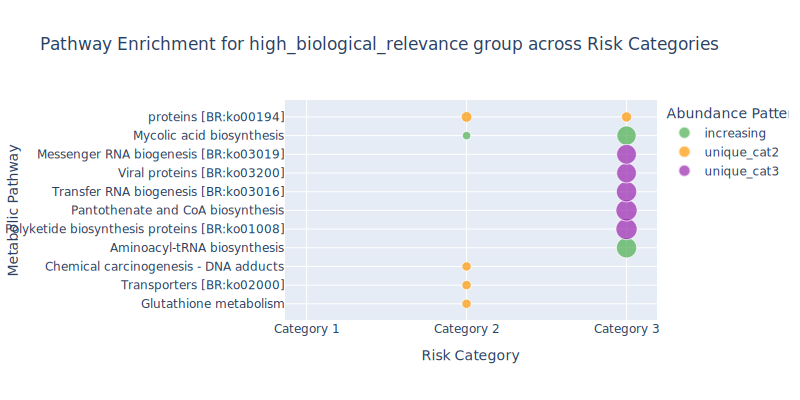

In [ ]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(high_biological_relevance, "high_biological_relevance")
Pathway_enrichment.show(renderer="svg")
output_path = shared_dir/"28_buble.png"
Pathway_enrichment.write_image(output_path)

The group high confidence is the largest one of the selected after balanced markers, the category 3 patterns are marked by prokaryotic defense system which increased drastically from cat1 to cat3. The lipid biosyntesis, aminoacid and cyano amino acid metabolism, nitrotoluene degradation and other fixation pathways only are present on cat3 as well as the quorum sensing which corelates with biofilm stablishement on corroded environments. Markers for early warning cat2 are fatty acids, lipids metabolism, together with flavonoids degradataion which are a bridge to more deteriorated environments.

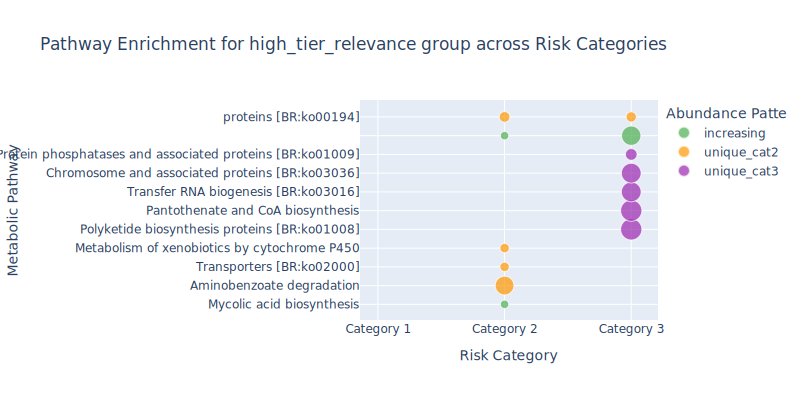

In [ ]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(high_tier_relevance , "high_tier_relevance")
Pathway_enrichment.show(renderer="svg")
output_path = shared_dir/"29_buble.png"
Pathway_enrichment.write_image(output_path)

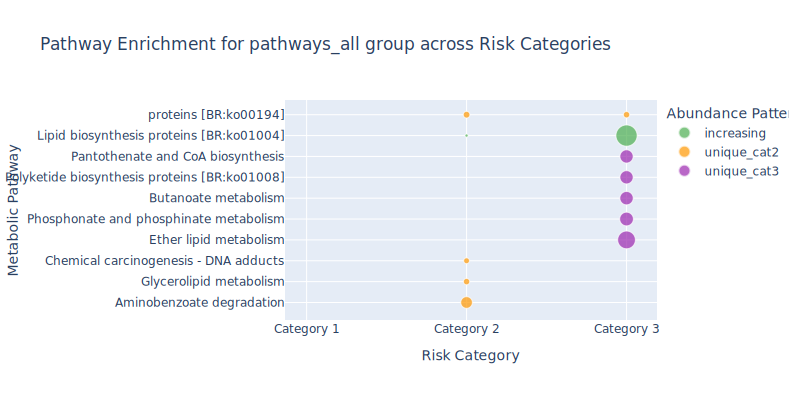

In [ ]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(pathways_all , "pathways_all")
Pathway_enrichment.show(renderer="svg")
output_path = shared_dir/"30_enrich.png"
Pathway_enrichment.write_image(output_path)

The significant markers is a group filtered drastically and hence the proceses seen here are more specific. The metabolism of valina, leucine and isoleucine degradation increase with risk label. The Alanine, spartate and glutamate metabolim seems to be only on cat3, also cyanoamino acid mettabolism, nitrotoluen degradation lipid byosinstesis and other carbon pathways, which are only specific to category 3 system failure. On the early warning cat2 we found also specific process to that category such as exosome, other glycan degradation, sphingolipid degradation and metabolism, fructuosa and manosa as well as flavonoids degradation. The metabolites on the system failure are more toxic ones as the early warning, there are no category 1 metabolism because these are filtered markers and it is no expected aromatics are propose to be the most enriched pathways on this function, whith the motility andand oter carbon fixations pathways, which is interesting to see the penicilin being anotated there, it might be noticed that the anotations here visualised come from different databases anotaated on the EC numbers reported by the picrust alogrithm and are no direct measures. The cunction for enrichement has been done on two groups first

##  6.2. Sunburns KO representation of pathways for a specific risk category.
This function creates hierarchical visualization of enzyme classifications. Parses enzyme_class column by splitting on delimiters (';', '.', or '-') to create parent-child relationships. Uses mean abundance values from selected category as sector sizes. Colors sectors by dominant risk category. Generates nested structure where outer rings show more specific enzyme subclasses.

In [91]:
def create_sunburst_chart(data_frame, name, top_n=None, category=3):
    """
    Create a sunburst chart with enzyme classification grouped to avoid repetition
    """
    sig_df = data_frame.sort_values(by='combined_score', ascending=False).head(top_n)
    
    # GROUP BY ENZYME_CLASS to avoid repetition
    grouped_df = sig_df.groupby('enzyme_class').agg({
        'Genus': lambda x: list(x),
        'protein_name': lambda x: list(x),
        f'mean_cat{category}': 'sum',  # Sum abundances for grouped enzymes
        'mean_cat1': 'mean',
        'mean_cat2': 'mean', 
        'mean_cat3': 'mean',
        'combined_score': 'mean'
    }).reset_index()
    
    # Prepare data for sunburst chart
    sunburst_data = []
    
    for idx, row in grouped_df.iterrows():
        # Get enzyme class
        enzyme_class = row['enzyme_class']
        if pd.isna(enzyme_class) or not isinstance(enzyme_class, str) or not enzyme_class:
            enzyme_class = 'Other Enzymes'
        
        # Split enzyme class into levels
        if ';' in enzyme_class:
            enzyme_levels = enzyme_class.split(';')[:3]
        elif '.' in enzyme_class:
            enzyme_levels = enzyme_class.split('.')[:3]
        elif '-' in enzyme_class:
            enzyme_levels = enzyme_class.split('-')[:3]
        else:
            enzyme_levels = [enzyme_class]
        
        # Clean each level
        enzyme_levels = [level.strip() for level in enzyme_levels if level.strip()]
        
        if not enzyme_levels:
            enzyme_levels = ['Other Enzymes']
        
        # Use summed abundance for grouped entries
        abundance = row[f'mean_cat{category}']
        
        # Get dominant category
        cat_values = [row['mean_cat1'], row['mean_cat2'], row['mean_cat3']]
        dominant_cat = cat_values.index(max(cat_values)) + 1
        
        # Create description showing all grouped items
        genera_list = row['Genus'] if isinstance(row['Genus'], list) else [row['Genus']]
        proteins_list = row['protein_name'] if isinstance(row['protein_name'], list) else [row['protein_name']]
        
        simple_description = "<br>".join([ 
            f"<b>Enzyme Class</b>: {enzyme_class}",
            f"<b>Number of entries</b>: {len(genera_list)}",
            f"<b>Genera</b>: {', '.join(genera_list[:5])}{'...' if len(genera_list) > 5 else ''}",
            f"<b>Proteins</b>: {', '.join(proteins_list[:3])}{'...' if len(proteins_list) > 3 else ''}"
        ])
        
        # Create unique ID for grouped entry
        unique_id = f"{'/'.join(enzyme_levels)}__{idx}"
        
        # Add the data point (leaf node)
        sunburst_data.append({
            'id': unique_id,
            'parent': '/'.join(enzyme_levels[:-1]) if len(enzyme_levels) > 1 else '',
            'labels': enzyme_levels[-1] if len(enzyme_levels[-1]) < 30 else enzyme_levels[-1][:27] + '...',
            'values': abundance,
            'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
            'simplified_info': simple_description
        })
        
        # Add parent paths (without duplication)
        for i in range(len(enzyme_levels)-1, 0, -1):
            parent_path = '/'.join(enzyme_levels[:i-1]) if i > 1 else ''
            path = '/'.join(enzyme_levels[:i])
            
            if not any(d['id'] == path for d in sunburst_data):
                label_text = enzyme_levels[i-1]
                if len(label_text) > 40:
                    label_text = label_text[:37] + '...'
                    
                sunburst_data.append({
                    'id': path,
                    'parent': parent_path,
                    'labels': label_text,
                    'values': 0,  # Parent nodes don't need values
                    'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                    'simplified_info': f"<b>Enzyme Group</b>: {path}"
                })
    
    # Convert to DataFrame
    sunburst_df = pd.DataFrame(sunburst_data)
    
    # Category color mapping
    color_map = {
        'Normal Operation':'#008800',
        'Early Warning': '#FF8C00',
        'System Failure': '#FF0000'
    }
    
    # Create the sunburst chart
    fig = px.sunburst(
        sunburst_df,
        ids='id',
        parents='parent',
        names='labels',
        values='values',
        color='dominant_category',
        color_discrete_map=color_map,
        title=f'Group {name} Enzyme Classification by Category {category} (Grouped)',
        custom_data=['simplified_info']
    )
    
    # Update hover template and enable text where it fits
    fig.update_traces(
        hovertemplate='%{customdata[0]}',
        textinfo='label',
        insidetextorientation='radial',
        branchvalues='total'
    )
    
    # Add white separator lines
    fig.update_traces(
        marker=dict(
            line=dict(color='white', width=1.5)
        )
    )
    
    # Update layout
    fig.update_layout(
        width=800,
        height=600,
        margin=dict(t=50, l=10, r=10, b=10),
        legend_title="System Status",
        font=dict(size=12),
        hoverlabel=dict(
            font_size=12,
            bgcolor="white"
        )
    )
    
    print(f"\nGrouped {len(sig_df)} entries into {len(grouped_df)} unique enzyme classes")
   
    return fig, sunburst_df

In [93]:

fig,  sunburst_data  = create_sunburst_chart(corrosion_critical, "corrosion_critical", top_n=200, category=3)
# Save as static image
output_path= shared_dir/"31_sunburn.png"
fig.write_image(output_path, scale=3)

# Show in notebook/browser
fig.show()


Grouped 200 entries into 3 unique enzyme classes


Iron-sulfur proteins (55%) agrees with the electron transfer proteins crucial for EET and with the proteins associated ferrixodin, enoyl, and rub that were discussed earlier. 
Alkyl/aryl transferases (15%) modify organic compounds, potentially breaking down protective coatings
CH-CH group donors (30%) are involved in organic matter degradation
Notice that the mechanism seein earlier on the sangey diagrams show much more participation of direct eet, H2 consumption and Nitrogen played an important role, however when looking at the enzymes classes appear no to be in agreement. The problem may be that enzyme annotations focus on biochemical function whiles corrosion mechanisms describe the electrochemical outcome.
An iron-sulfur protein can participate in H2 consumption OR direct EET depending on environmental conditions

For organic matter degradation in MIC:
Biofilms produce organic acids (acetate, lactate) that acidify the surface, these transferases and CH-CH enzymes break down complex organics into simpler acids. The acids then chelate metal ions and create localized corrosion cells
This explains why H2 consumption and EET dominate despite iron-sulfur enzyme prevalence - the enzymes enable multiple corrosion pathways!

In [98]:
def create_sunburst_chart_with_details(data_frame, name, top_n=None, category=3):
    """
    Create a sunburst chart showing enzyme classes with genus-protein pairs as outer ring
    FIXED version to ensure consistent percentages
    """
    sig_df = data_frame.sort_values(by='combined_score', ascending=False).head(top_n)
    
    # Debug: Let's see what we're working with
    print(f"\nTotal entries: {len(sig_df)}")
    enzyme_counts = sig_df['enzyme_class'].value_counts()
    print("\nEnzyme class distribution:")
    for enzyme, count in enzyme_counts.head(10).items():
        print(f"  {enzyme}: {count} entries")
    
    # Calculate total abundance for percentage calculation
    total_abundance = sig_df[f'mean_cat{category}'].sum()
    print(f"\nTotal abundance (mean_cat{category}): {total_abundance}")
    
    sunburst_data = []
    
    # Group by enzyme class first to get correct totals
    enzyme_totals = sig_df.groupby('enzyme_class').agg({
        f'mean_cat{category}': 'sum'
    }).to_dict()[f'mean_cat{category}']
    
    # Process each enzyme class
    for enzyme_class in sig_df['enzyme_class'].unique():
        if pd.isna(enzyme_class) or not enzyme_class:
            enzyme_class = 'Other Enzymes'
        
        # Get all entries for this enzyme class
        class_entries = sig_df[sig_df['enzyme_class'] == enzyme_class]
        
        # Parse enzyme class levels
        if ';' in enzyme_class:
            enzyme_levels = enzyme_class.split(';')[:2]
        elif '.' in enzyme_class:
            enzyme_levels = enzyme_class.split('.')[:2]
        elif '-' in enzyme_class:
            enzyme_levels = enzyme_class.split('-')[:2]
        else:
            enzyme_levels = [enzyme_class]
        
        enzyme_levels = [level.strip() for level in enzyme_levels if level.strip()]
        if not enzyme_levels:
            enzyme_levels = ['Other Enzymes']
        
        class_path = '/'.join(enzyme_levels)
        
        # Add root level if needed
        if len(enzyme_levels) > 1 and not any(d['id'] == enzyme_levels[0] for d in sunburst_data):
            sunburst_data.append({
                'id': enzyme_levels[0],
                'parent': '',
                'labels': enzyme_levels[0][:40] + '...' if len(enzyme_levels[0]) > 40 else enzyme_levels[0],
                'values': 0,  # Parent nodes get 0, values come from leaves
                'info_type': 'enzyme_root',
                'simplified_info': f"<b>Enzyme Class</b>: {enzyme_levels[0]}"
            })
        
        # Add enzyme class node
        if not any(d['id'] == class_path for d in sunburst_data):
            class_abundance = enzyme_totals.get(enzyme_class, 0)
            percentage = (class_abundance / total_abundance * 100) if total_abundance > 0 else 0
            
            sunburst_data.append({
                'id': class_path,
                'parent': enzyme_levels[0] if len(enzyme_levels) > 1 else '',
                'labels': enzyme_levels[-1][:30] + '...' if len(enzyme_levels[-1]) > 30 else enzyme_levels[-1],
                'values': 0,  # Parent nodes get 0
                'info_type': 'enzyme_class',
                'simplified_info': f"<b>Enzyme</b>: {enzyme_class}<br>" + 
                                  f"<b>Entries</b>: {len(class_entries)}<br>" +
                                  f"<b>Total Abundance</b>: {class_abundance:.2f}<br>" +
                                  f"<b>Percentage</b>: {percentage:.1f}%"
            })
        
        # Add individual entries
        for idx, (_, row) in enumerate(class_entries.iterrows()):
            pair_id = f"{class_path}||{row['Genus']}_{row['protein_name'][:15]}_{idx}"
            
            # Determine dominant category
            cat_values = [row['mean_cat1'], row['mean_cat2'], row['mean_cat3']]
            dominant_cat = cat_values.index(max(cat_values)) + 1
            
            label = f"{row['Genus']} - {row['protein_name'][:20]}{'...' if len(row['protein_name']) > 20 else ''}"
            
            sunburst_data.append({
                'id': pair_id,
                'parent': class_path,
                'labels': label,
                'values': row[f'mean_cat{category}'],  # Actual abundance value
                'info_type': 'genus_protein',
                'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                'simplified_info': f"<b>Genus</b>: {row['Genus']}<br>" +
                                  f"<b>Protein</b>: {row['protein_name']}<br>" +
                                  f"<b>Abundance</b>: {row[f'mean_cat{category}']:.3f}"
            })
    
    # Convert to DataFrame
    sunburst_df = pd.DataFrame(sunburst_data)
    
    # Debug: Check the values
    print("\nSunburst data check:")
    leaf_nodes = sunburst_df[sunburst_df['info_type'] == 'genus_protein']
    print(f"Total leaf nodes: {len(leaf_nodes)}")
    print(f"Sum of leaf values: {leaf_nodes['values'].sum()}")
    
    # Group by parent to verify percentages
    parent_sums = leaf_nodes.groupby('parent')['values'].sum().sort_values(ascending=False)
    print("\nValues by enzyme class:")
    for parent, total in parent_sums.head(5).items():
        pct = (total / leaf_nodes['values'].sum() * 100) if leaf_nodes['values'].sum() > 0 else 0
        print(f"  {parent}: {total:.2f} ({pct:.1f}%)")
    
    # Color function
    def get_color(row):
        if row['info_type'] in ['enzyme_root', 'enzyme_class']:
            return '#E0E0E0'
        else:
            return {
                'Normal Operation': '#008800',
                'Early Warning': '#FF8C00',
                'System Failure': '#FF0000'
            }.get(row.get('dominant_category', ''), '#666666')
    
    sunburst_df['color'] = sunburst_df.apply(get_color, axis=1)
    
    # Create sunburst
    fig = px.sunburst(
        sunburst_df,
        ids='id',
        parents='parent',
        names='labels',
        values='values',
        color='color',
        color_discrete_map={color: color for color in sunburst_df['color'].unique()},
        title=f'{name}: Enzyme Classes with Details (Category {category})',
        custom_data=['simplified_info']
    )
    
    fig.update_traces(
        hovertemplate='%{customdata[0]}',
        textinfo='label+percent parent',
        insidetextorientation='radial',
        branchvalues='total'  # Important: use total for correct percentages
    )
    
    fig.update_layout(
        width=900,
        height=700,
        margin=dict(t=50, l=10, r=10, b=10)
    )
    
    return fig, sunburst_df

# Additional function to analyze the disconnect
def analyze_enzyme_mechanism_disconnect(df):
    """
    Analyze the relationship between enzyme classifications and mechanisms
    """
    # Create cross-tabulation
    enzyme_mechanism_pairs = []
    
    for _, row in df.iterrows():
        enzyme_class = row.get('enzyme_class', 'Unknown')
        mechanisms = row.get('corrosion_mechanisms', '')
        
        if mechanisms:
            for mech in mechanisms.split(';'):
                mech = mech.strip()
                if mech:
                    enzyme_mechanism_pairs.append({
                        'enzyme_class': enzyme_class,
                        'mechanism': mech,
                        'count': 1
                    })
    
    pairs_df = pd.DataFrame(enzyme_mechanism_pairs)
    crosstab = pd.crosstab(pairs_df['enzyme_class'], pairs_df['mechanism'])
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(crosstab, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Count'})
    plt.title('Enzyme Class vs Corrosion Mechanism Cross-Reference')
    plt.xlabel('Corrosion Mechanism')
    plt.ylabel('Enzyme Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return crosstab


Total entries: 200

Enzyme class distribution:
  Acting on the CH-CH group of donors.: 147 entries
  Acting on iron-sulfur proteins as donors.: 39 entries
  Transferring alkyl or aryl groups, other than methyl groups.: 14 entries

Total abundance (mean_cat3): 34.6079313927692

Sunburst data check:
Total leaf nodes: 200
Sum of leaf values: 34.6079313927692



Values by enzyme class:
  Acting on the CH-CH group of donors: 24.06 (69.5%)
  Acting on iron-sulfur proteins as donors: 9.73 (28.1%)
  Transferring alkyl or aryl groups, other than methyl groups: 0.81 (2.4%)


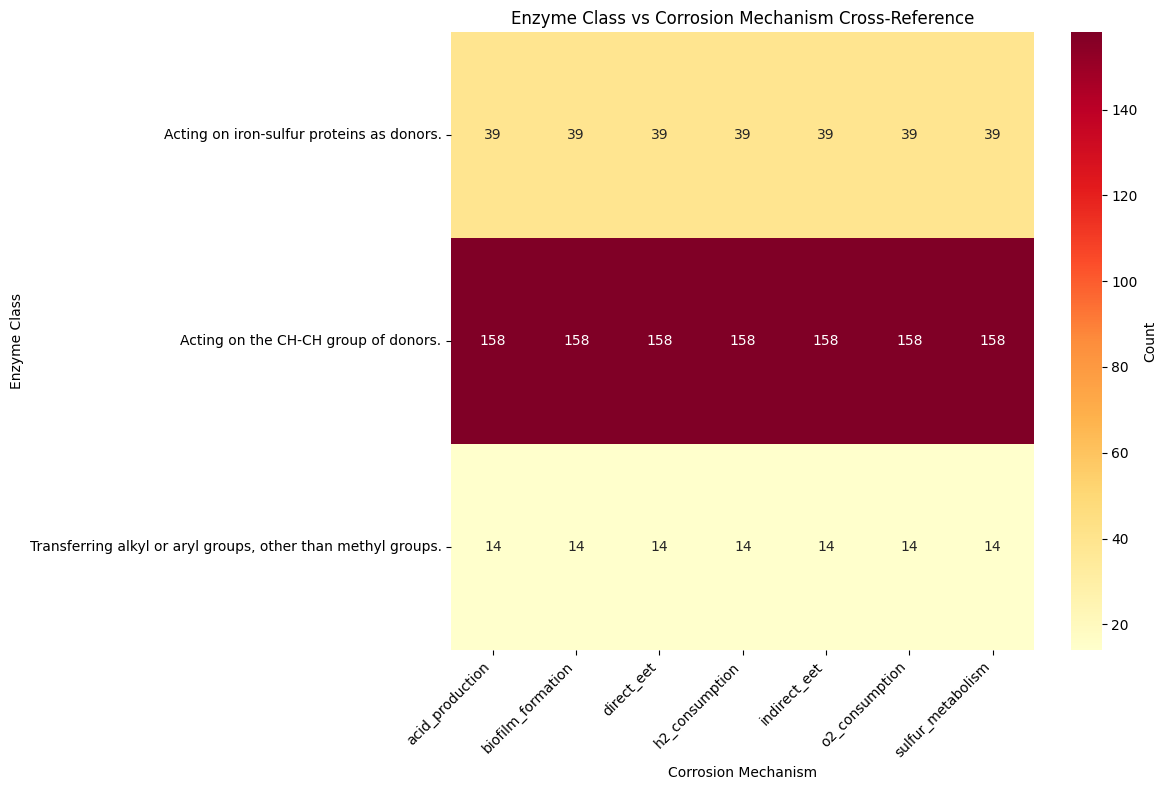

mechanism                                           acid_production  \
enzyme_class                                                          
Acting on iron-sulfur proteins as donors.                        39   
Acting on the CH-CH group of donors.                            158   
Transferring alkyl or aryl groups, other than m...               14   

mechanism                                           biofilm_formation  \
enzyme_class                                                            
Acting on iron-sulfur proteins as donors.                          39   
Acting on the CH-CH group of donors.                              158   
Transferring alkyl or aryl groups, other than m...                 14   

mechanism                                           direct_eet  \
enzyme_class                                                     
Acting on iron-sulfur proteins as donors.                   39   
Acting on the CH-CH group of donors.                       158   
Transferring alkyl or aryl groups, other than m...          14   

mechanism                                           h2_consumption  \
enzyme_class                                                         
Acting on iron-sulfur proteins as donors.                       39   
Acting on the CH-CH group of donors.                           158   
Transferring alkyl or aryl groups, other than m...              14   

mechanism                                           indirect_eet  \
enzyme_class                                                       
Acting on iron-sulfur proteins as donors.                     39   
Acting on the CH-CH group of donors.                         158   
Transferring alkyl or aryl groups, other than m...            14   

mechanism                                           o2_consumption  \
enzyme_class                                                         
Acting on iron-sulfur proteins as donors.                       39   
Acting on the CH-CH group of donors.                           158   
Transferring alkyl or aryl groups, other than m...              14   

mechanism                                           sulfur_metabolism  
enzyme_class                                                           
Acting on iron-sulfur proteins as donors.                          39  
Acting on the CH-CH group of donors.                              158  
Transferring alkyl or aryl groups, other than m...                 14

In [99]:
fig,  sunburst_data  = create_sunburst_chart_with_details(corrosion_critical, "corrosion_critical", top_n=200, category=3)
# Save as static image
output_path= shared_dir/"31_sunburn.png"
fig.write_image(output_path, scale=3)
# Show in notebook/browser
fig.show()
analyze_enzyme_mechanism_disconnect(corrosion_critical)

## 6.3. Corrosion Relevant Pathways
Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to our acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation

In [ ]:
def plot_pathway_analysis(df, name, num_items=25):
    """
    Create visualizations for pathway analysis - optimized version with only the most informative plots
    Parameters:
    df: DataFrame containing pathway analysis results
    name: Name of the original DataFrame (for labeling purposes)
    num_items: Number of items to show in plots (default: 25)
    """
    from matplotlib.lines import Line2D
    
    # Category colors
    category_colors = {1: '#008800', 2: '#FFA500', 3: '#FF0000'} # Green, Orange, Red
    categories_labels = {1: 'Category 1', 2: 'Category 2', 3: 'Category 3'}
    
    # Get top N entries based on combined_score
    top_data = df.sort_values('combined_score', ascending=False).head(num_items).copy()
    
    # Create proper labels with genus and protein name - no truncation
    top_data['label'] = top_data.apply(lambda x: f"{x['Genus']} - {x['protein_name']}", axis=1)
    
    # ====== PLOT 1: Fold Change and Mean Abundance ======
    fig, ax1 = plt.subplots(figsize=(10, min(9, max(5, len(top_data)*0.2))))
    ax2 = ax1.twinx()
    
    # Plot fold change
    bars = ax1.barh(range(len(top_data)), top_data['fold_change_3vs1'], color='skyblue')
    
    # Plot mean abundance on secondary axis
    line = ax2.plot(top_data['mean_cat3'], range(len(top_data)),
                    marker='o', color='red', linestyle='--')
    
    # Set labels and titles
    ax1.set_yticks(range(len(top_data)))
    ax1.set_yticklabels(top_data['label'])
    ax1.set_title(f'{name}: Pathways', fontsize=12)
    ax1.set_xlabel('Fold Change (Cat3/Cat1)', fontsize=10)
    ax1.set_ylabel('Protein', fontsize=10)
    ax2.set_xlabel('Mean Abundance in Cat3', fontsize=10)
    
    # Add a legend
    legend_elements = [
        Line2D([0], [0], color='skyblue', lw=4, label='Fold Change (Cat3/Cat1)'),
        Line2D([0], [0], marker='o', color='red', label='Mean Abundance Cat3',
               markersize=6, linestyle='--')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')  # Changed to upper right
    
    plt.tight_layout()
    plt.show()
    
    # ====== PLOT 2: Enhanced Category Comparison ======
    fig, ax = plt.subplots(figsize=(10, min(8, max(7, len(top_data)*0.1))))

    # Create indices for plotting  
    indices = np.arange(len(top_data))

    # Calculate height based on number of items
    bar_height = min(0.8, 0.25 * (20 / len(top_data)))  

    # Sort data by fold change for better visualization
    sorted_data = top_data.sort_values('fold_change_3vs1', ascending=True)  # Changed to ascending

    # Plot each category with specified colors - using barh for horizontal bars
    bars1 = ax.barh(indices - bar_height, sorted_data['mean_cat1'], height=bar_height,
                color=category_colors[1], label=categories_labels[1])
    bars2 = ax.barh(indices, sorted_data['mean_cat2'], height=bar_height,
                color=category_colors[2], label=categories_labels[2])
    bars3 = ax.barh(indices + bar_height, sorted_data['mean_cat3'], height=bar_height,
                color=category_colors[3], label=categories_labels[3])

    # Create a second x-axis for fold change (top axis)
    ax2 = ax.twiny()
    line = ax2.plot(sorted_data['fold_change_3vs1'], indices, 'ko-', linewidth=2,
                    marker='D', markersize=6, label='Fold Change (Cat3/Cat1)')

    # Set labels and titles
    ax.set_ylabel('Proteins', fontsize=14)
    ax.set_xlabel('Mean Abundance', fontsize=12)
    #ax2.set_xlabel('Fold Change (Cat3/Cat1)', fontsize=12)
    plt.title(f'{name}: Abundance & Fold Change (Cat3/Cat1)', fontsize=14, pad=40)

    # Set y-ticks with protein labels
    ax.set_yticks(indices)
    ax.set_yticklabels(sorted_data['label'], fontsize=8)

    # Create a single legend for both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

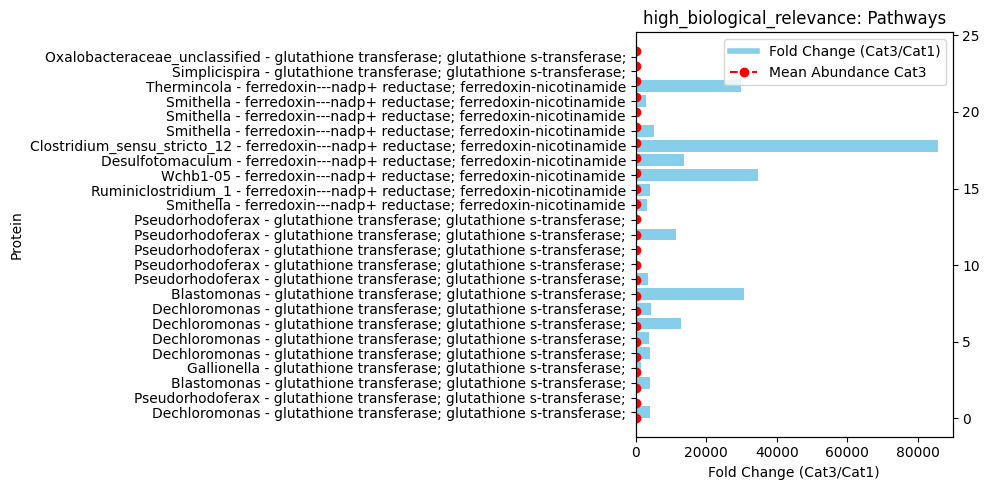

/tmp/ipykernel_8974/179414936.py:73: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko-" (-> marker='o'). The keyword argument will take precedence.



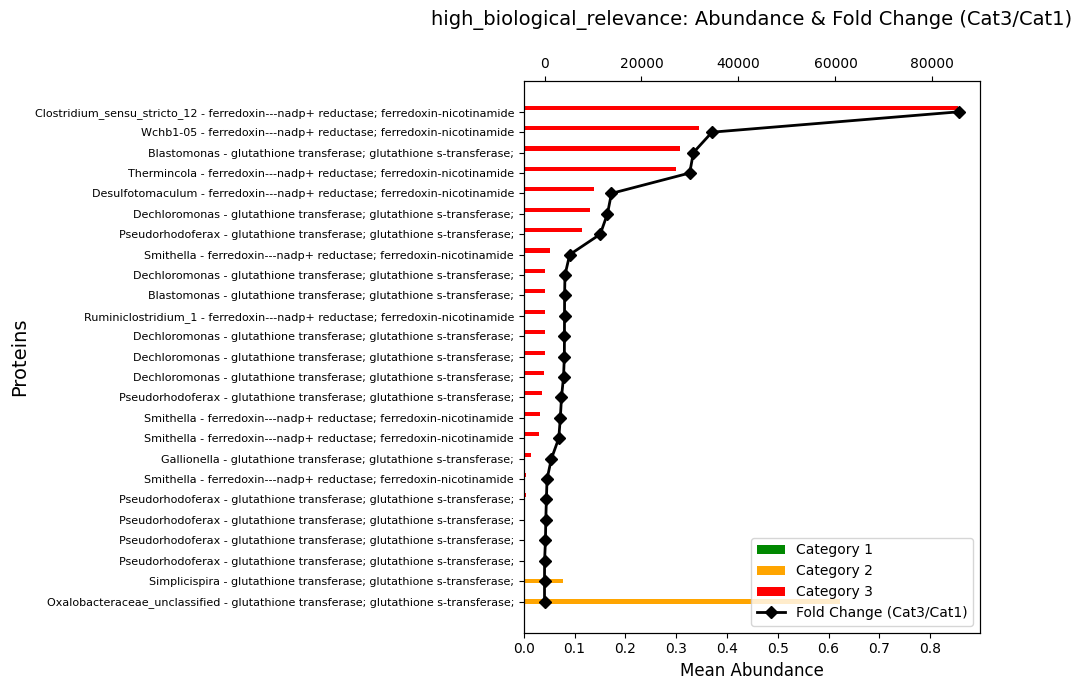

In [ ]:
plot_pathway_analysis(high_biological_relevance , "high_biological_relevance", num_items=25)
output_share = shared_dir/"31_pathways"
fig.write_image(output_share, scale=3)

## 6.4 Pathway Categories Mirror comparison
plot_mirrored_pathway_comparison filters dataframe for two pathway categories using term matching against cs.pathway_categories dictionary. Groups entries by protein name to consolidate multiple bacteria. Then creates side-by-side horizontal bar charts showing the same metric for both pathways, with left chart inverted for mirror effect. Prints bacteria associations separately.

In [66]:
def plot_mirrored_pathway_comparison(df, pathway_categories, cat1='organic_acid_metabolism', cat2='iron_sulfur_redox', 
                                   metric='log2fc_3vs1'):
    """
    Creates mirrored bar plots comparing two pathway categories using the SAME metric,
    grouped by protein with bacteria lists printed outside
    """
    category_terms = {k: v for k, v in cs.pathway_categories.items()}
    
    def match_pathways(row, terms):
        return any(term.lower() in str(row['pathways']).lower() for term in terms)
    
    # Filter rows
    df_cat1 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat1, [])), axis=1)].copy()
    df_cat2 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat2, [])), axis=1)].copy()
    
    # GROUP BY PROTEIN
    df_cat1_grouped = df_cat1.groupby('protein_name').agg({
        'Genus': lambda x: sorted(set(x)),  # Keep as list for printing
        metric: 'mean',
        'Category': lambda x: x.mode()[0] if len(x) > 0 else x.iloc[0]
    }).reset_index()
    
    df_cat2_grouped = df_cat2.groupby('protein_name').agg({
        'Genus': lambda x: sorted(set(x)),
        metric: 'mean',
        'Category': lambda x: x.mode()[0] if len(x) > 0 else x.iloc[0]
    }).reset_index()
    
    # Trim protein names if too long
    df_cat1_grouped['label'] = df_cat1_grouped['protein_name'].apply(
        lambda x: x[:27] + "..." if len(x) > 30 else x
    )
    df_cat2_grouped['label'] = df_cat2_grouped['protein_name'].apply(
        lambda x: x[:27] + "..." if len(x) > 30 else x
    )
    
    # Sort by metric value
    df_cat1_grouped = df_cat1_grouped.sort_values(metric, ascending=True)
    df_cat2_grouped = df_cat2_grouped.sort_values(metric, ascending=True)
    
    # Create figure
    max_proteins = max(len(df_cat1_grouped), len(df_cat2_grouped))
    fig_height = max(8, max_proteins * 0.4)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, fig_height))
    
    # Left plot - ONLY PROTEIN NAMES
    if len(df_cat1_grouped) > 0:
        ax1.barh(df_cat1_grouped['label'], df_cat1_grouped[metric],
                color=df_cat1_grouped['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
        ax1.set_title(cat1.replace('_', ' ').title())
        ax1.set_xlabel(metric)
        ax1.invert_xaxis()
    
    # Right plot - ONLY PROTEIN NAMES
    if len(df_cat2_grouped) > 0:
        ax2.barh(df_cat2_grouped['label'], df_cat2_grouped[metric],
                color=df_cat2_grouped['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
        ax2.set_title(cat2.replace('_', ' ').title())
        ax2.set_xlabel(metric)
    
    plt.tight_layout()
    plt.show()
    
    # Print bacteria lists OUTSIDE the plot
    print("\n" + "="*80)
    print(f"{cat1.upper()} PROTEINS AND ASSOCIATED BACTERIA")
    print("="*80)
    for _, row in df_cat1_grouped.iterrows():
        print(f"\n{row['protein_name']} ({metric}: {row[metric]:.3f})")
        print(f"  Bacteria ({len(row['Genus'])}): {', '.join(row['Genus'])}")
    
    print("\n" + "="*80)
    print(f"{cat2.upper()} PROTEINS AND ASSOCIATED BACTERIA")
    print("="*80)
    for _, row in df_cat2_grouped.iterrows():
        print(f"\n{row['protein_name']} ({metric}: {row[metric]:.3f})")
        print(f"  Bacteria ({len(row['Genus'])}): {', '.join(row['Genus'])}")
    
    print("\n" + "="*80)
    print(f"Summary: {cat1}: {len(df_cat1_grouped)} proteins | {cat2}: {len(df_cat2_grouped)} proteins")
    
    return fig

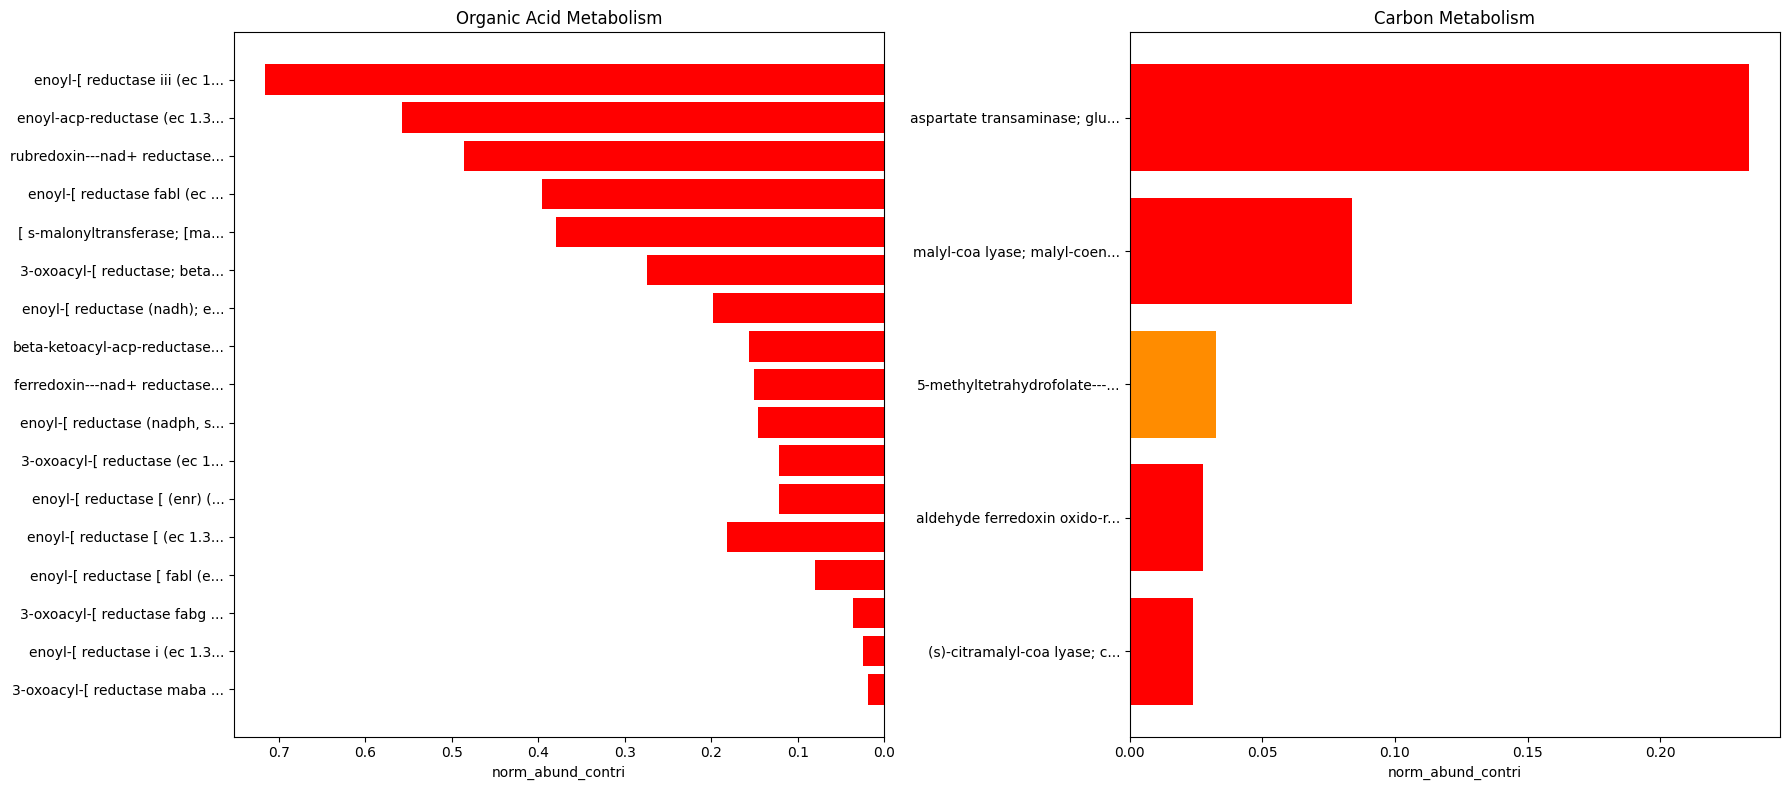


ORGANIC_ACID_METABOLISM PROTEINS AND ASSOCIATED BACTERIA

3-oxoacyl-[ reductase maba (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.019)
  Bacteria (1): Mycobacterium

enoyl-[ reductase i (ec 1.3.1.10, ec 1.3.1.9) (norm_abund_contri: 0.024)
  Bacteria (1): Sphingomonas

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (norm_abund_contri: 0.030)
  Bacteria (1): Micrococcus

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.036)
  Bacteria (1): Staphylococcus

enoyl-[ reductase [ fabl (ec 1.3.1.10) (norm_abund_contri: 0.080)
  Bacteria (1): Legionella

enoyl-[ reductase [ (ec 1.3.1.9) (norm_abund_contri: 0.119)
  Bacteria (35): Acidisoma, Acidovorax, Anoxybacillus, Azospira, Bacillus, Blastomonas, Caulobacter, Clostridium, Cutibacterium, Dechloromonas, Desulfobulbus, Desulfomicrobium, Desulfovibrio, Enhydrobacter, Flavisolibacter, Gallionella, Geothrix, Herbaspirillum, Legionella, Methylocystis, Mycoplana, Nitrospira, Novosphingobium, Paracoccus, Phreatobacter, Porp

<Figure size 640x480 with 0 Axes>

In [71]:
# pathway_categories = {    'hydrogen_metabolism',    'oxygen_metabolism',    'nitrogen_metabolism',    'manganese_processes',    'iron_sulfur_redox',
#'ocre_formation',    'sulfur_metabolism',    'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',    'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(organic_metal_synergy, cs.pathway_categories, cat1='organic_acid_metabolism',
                                  cat2='carbon_metabolism', metric='norm_abund_contri')
mirror_path = shared_dir/"32_mirror.png"
plt.savefig(mirror_path, dpi=300, bbox_inches='tight')

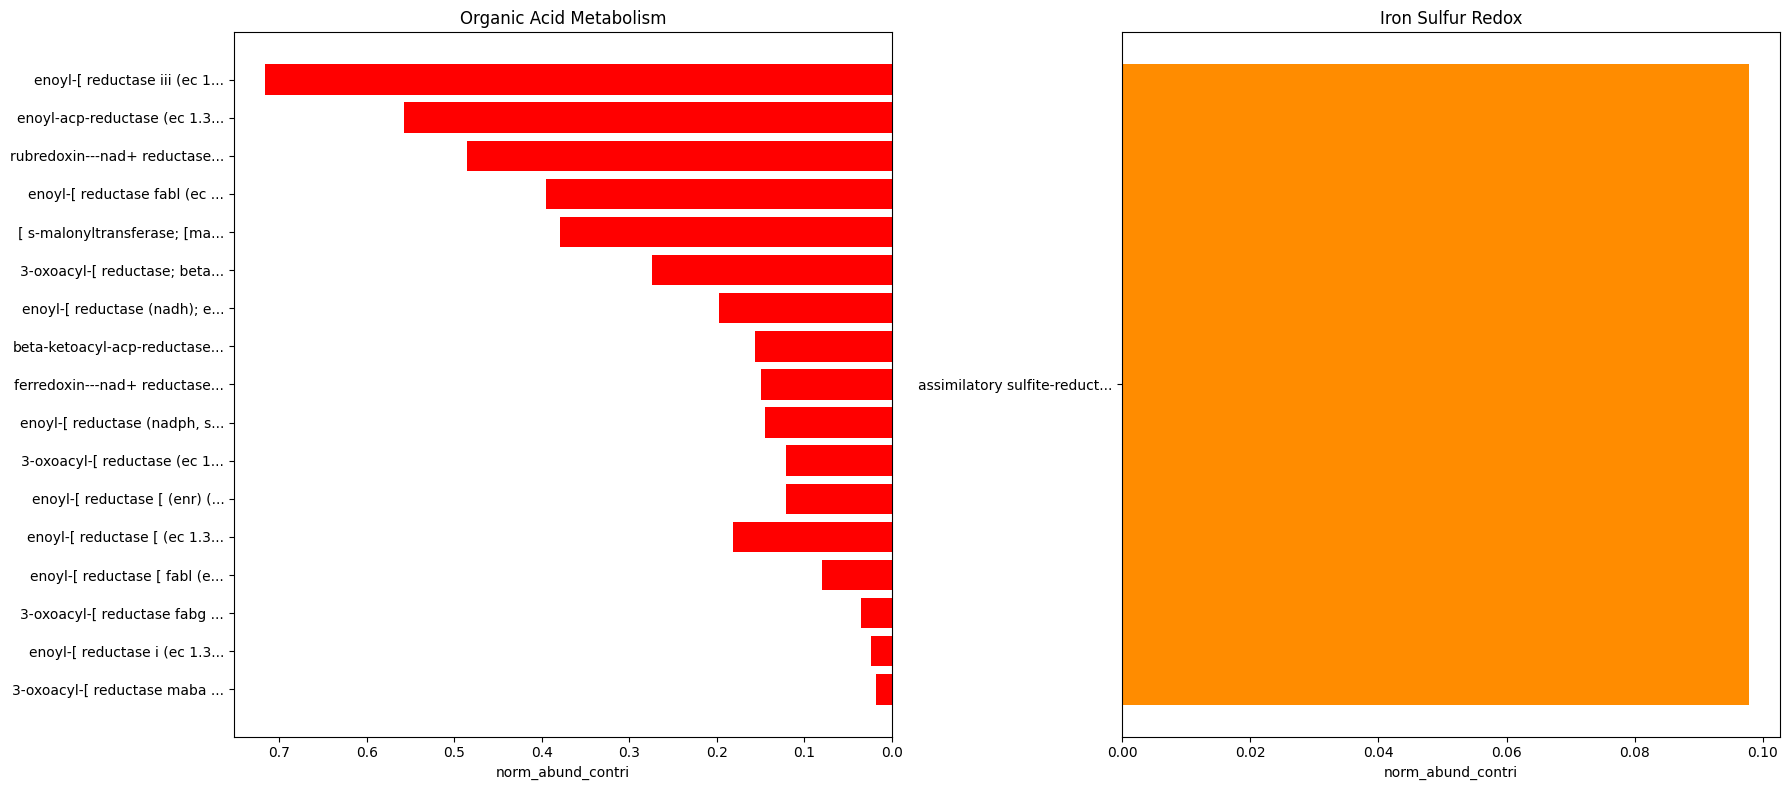


ORGANIC_ACID_METABOLISM PROTEINS AND ASSOCIATED BACTERIA

3-oxoacyl-[ reductase maba (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.019)
  Bacteria (1): Mycobacterium

enoyl-[ reductase i (ec 1.3.1.10, ec 1.3.1.9) (norm_abund_contri: 0.024)
  Bacteria (1): Sphingomonas

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (norm_abund_contri: 0.030)
  Bacteria (1): Micrococcus

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.036)
  Bacteria (1): Staphylococcus

enoyl-[ reductase [ fabl (ec 1.3.1.10) (norm_abund_contri: 0.080)
  Bacteria (1): Legionella

enoyl-[ reductase [ (ec 1.3.1.9) (norm_abund_contri: 0.119)
  Bacteria (35): Acidisoma, Acidovorax, Anoxybacillus, Azospira, Bacillus, Blastomonas, Caulobacter, Clostridium, Cutibacterium, Dechloromonas, Desulfobulbus, Desulfomicrobium, Desulfovibrio, Enhydrobacter, Flavisolibacter, Gallionella, Geothrix, Herbaspirillum, Legionella, Methylocystis, Mycoplana, Nitrospira, Novosphingobium, Paracoccus, Phreatobacter, Porp

<Figure size 640x480 with 0 Axes>

In [75]:
plot_mirrored_pathway_comparison(organic_metal_synergy, cs.pathway_categories, cat1='organic_acid_metabolism', cat2='iron_sulfur_redox', 
                                   metric='norm_abund_contri')
mirror_path = shared_dir/"33_mirror.png"
plt.savefig(mirror_path, dpi=300, bbox_inches='tight')

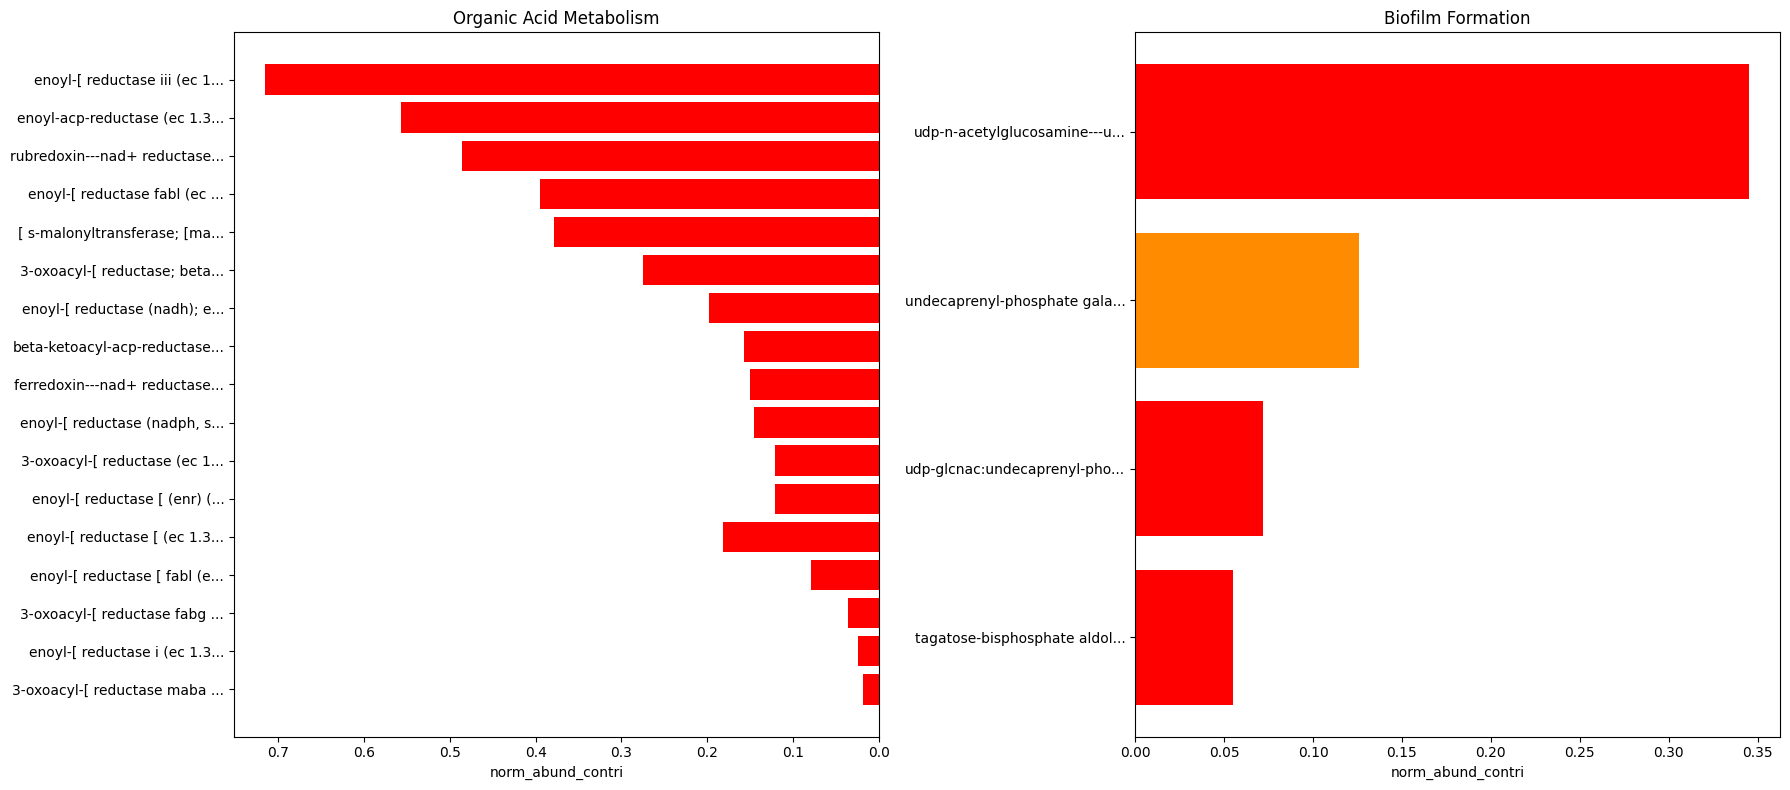


ORGANIC_ACID_METABOLISM PROTEINS AND ASSOCIATED BACTERIA

3-oxoacyl-[ reductase maba (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.019)
  Bacteria (1): Mycobacterium

enoyl-[ reductase i (ec 1.3.1.10, ec 1.3.1.9) (norm_abund_contri: 0.024)
  Bacteria (1): Sphingomonas

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (norm_abund_contri: 0.030)
  Bacteria (1): Micrococcus

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.036)
  Bacteria (1): Staphylococcus

enoyl-[ reductase [ fabl (ec 1.3.1.10) (norm_abund_contri: 0.080)
  Bacteria (1): Legionella

enoyl-[ reductase [ (ec 1.3.1.9) (norm_abund_contri: 0.119)
  Bacteria (35): Acidisoma, Acidovorax, Anoxybacillus, Azospira, Bacillus, Blastomonas, Caulobacter, Clostridium, Cutibacterium, Dechloromonas, Desulfobulbus, Desulfomicrobium, Desulfovibrio, Enhydrobacter, Flavisolibacter, Gallionella, Geothrix, Herbaspirillum, Legionella, Methylocystis, Mycoplana, Nitrospira, Novosphingobium, Paracoccus, Phreatobacter, Porp

<Figure size 640x480 with 0 Axes>

In [77]:
# pathway_categories = {    'hydrogen_metabolism',    'oxygen_metabolism',    'nitrogen_metabolism',    'manganese_processes',    'iron_sulfur_redox',
#'ocre_formation',    'sulfur_metabolism',    'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',    'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(organic_metal_synergy, cs.pathway_categories, cat1='organic_acid_metabolism', cat2='biofilm_formation', 
                metric='norm_abund_contri')
mirror_path = shared_dir/"34_mirror.png"
plt.savefig(mirror_path, dpi=300, bbox_inches='tight') 

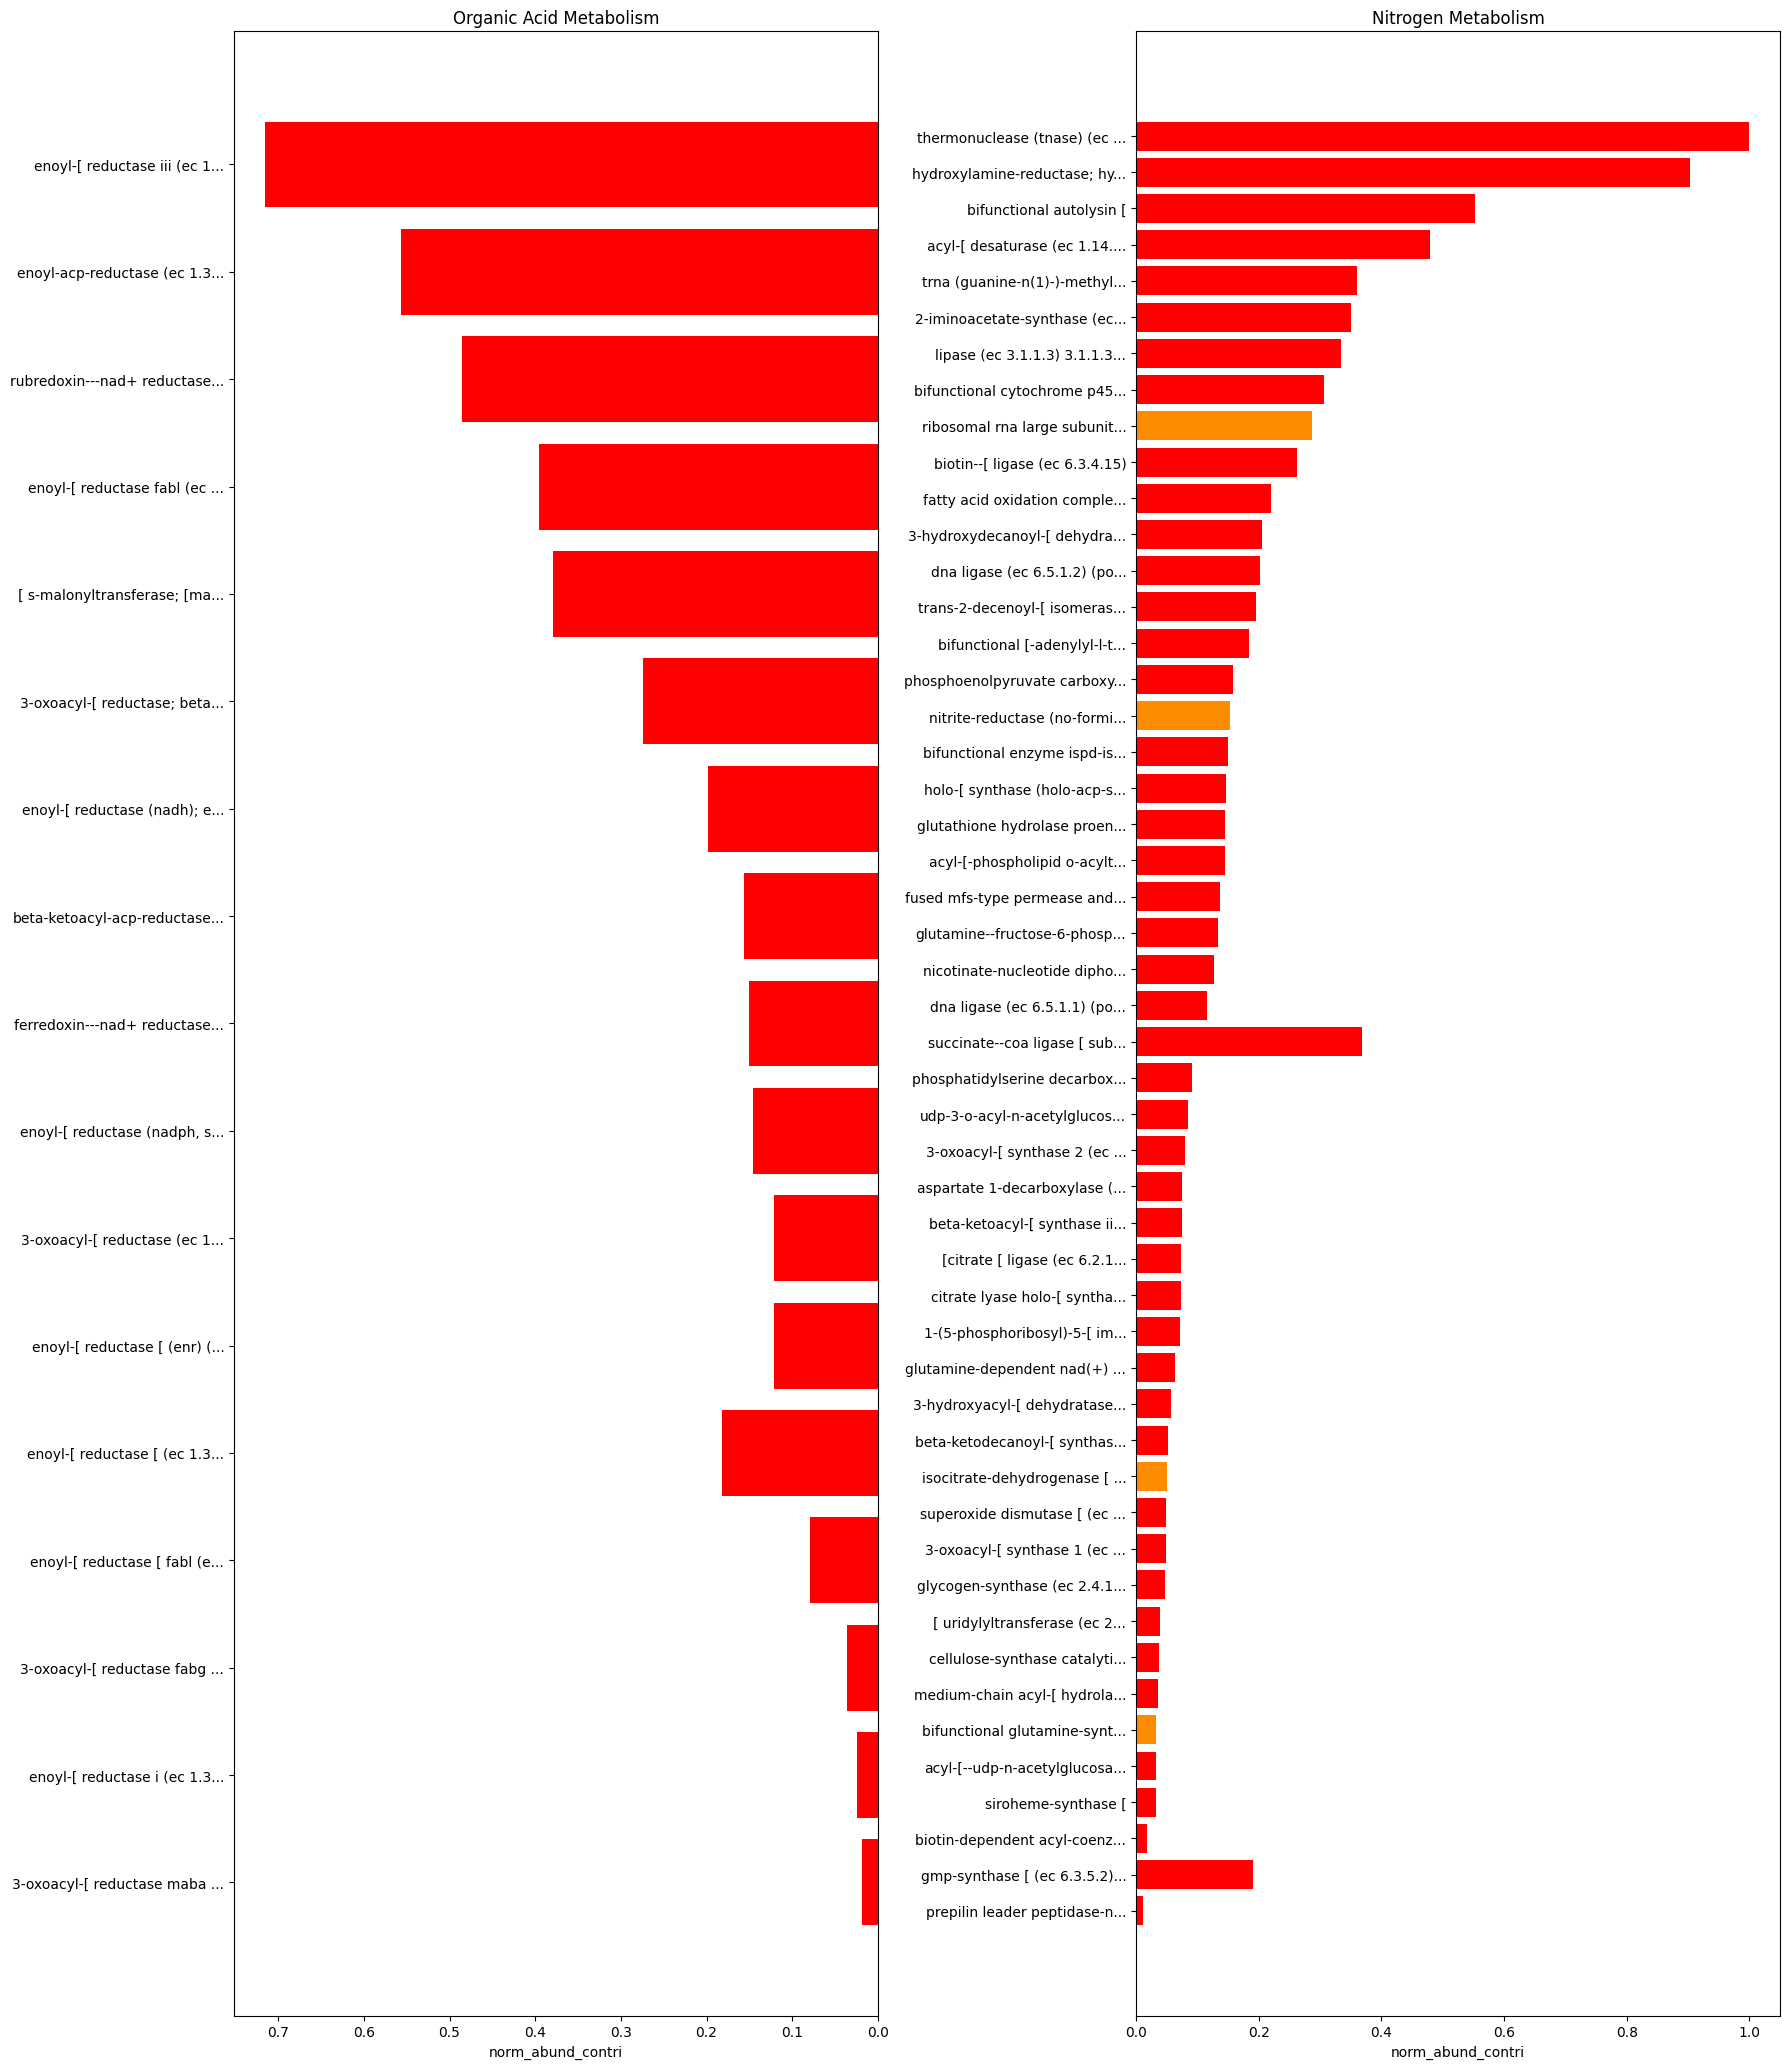


ORGANIC_ACID_METABOLISM PROTEINS AND ASSOCIATED BACTERIA

3-oxoacyl-[ reductase maba (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.019)
  Bacteria (1): Mycobacterium

enoyl-[ reductase i (ec 1.3.1.10, ec 1.3.1.9) (norm_abund_contri: 0.024)
  Bacteria (1): Sphingomonas

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (norm_abund_contri: 0.030)
  Bacteria (1): Micrococcus

3-oxoacyl-[ reductase fabg (ec 1.1.1.100) (3-ketoacyl (norm_abund_contri: 0.036)
  Bacteria (1): Staphylococcus

enoyl-[ reductase [ fabl (ec 1.3.1.10) (norm_abund_contri: 0.080)
  Bacteria (1): Legionella

enoyl-[ reductase [ (ec 1.3.1.9) (norm_abund_contri: 0.119)
  Bacteria (35): Acidisoma, Acidovorax, Anoxybacillus, Azospira, Bacillus, Blastomonas, Caulobacter, Clostridium, Cutibacterium, Dechloromonas, Desulfobulbus, Desulfomicrobium, Desulfovibrio, Enhydrobacter, Flavisolibacter, Gallionella, Geothrix, Herbaspirillum, Legionella, Methylocystis, Mycoplana, Nitrospira, Novosphingobium, Paracoccus, Phreatobacter, Porp

<Figure size 640x480 with 0 Axes>

In [81]:
# pathway_categories = {    'hydrogen_metabolism',    'oxygen_metabolism',    'nitrogen_metabolism',    'manganese_processes',    'iron_sulfur_redox',
#'ocre_formation',    'sulfur_metabolism',    'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',    'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(organic_metal_synergy,  cs.pathway_categories, cat1='organic_acid_metabolism', cat2='nitrogen_metabolism', 
                metric='norm_abund_contri')
mirror_path = shared_dir/"35_mirror.png"
plt.savefig(mirror_path, dpi=300, bbox_inches='tight') 

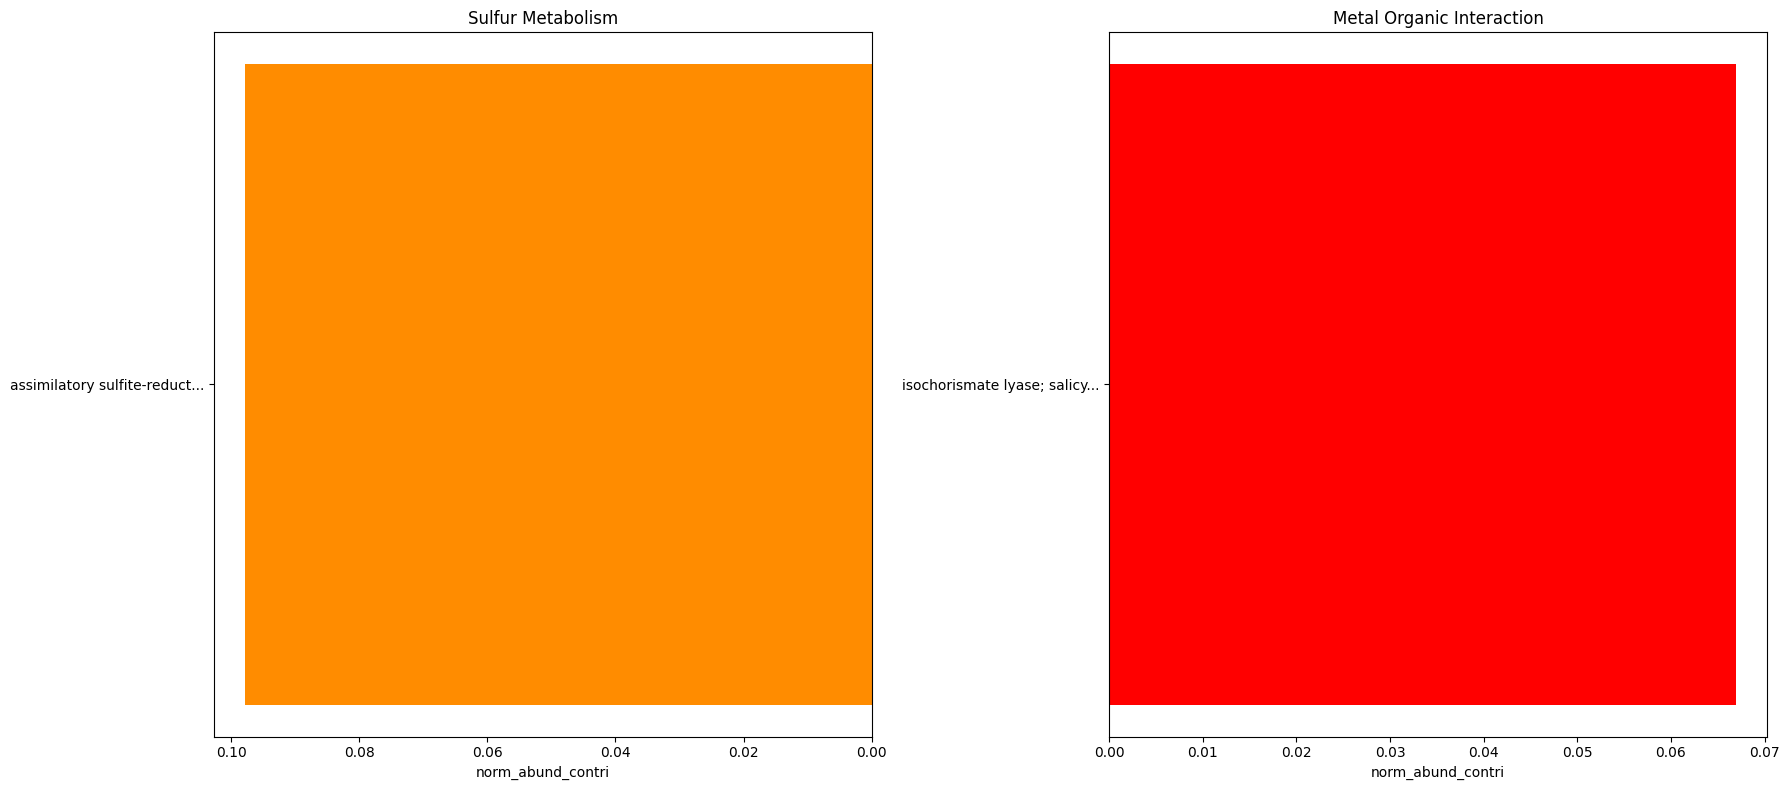


SULFUR_METABOLISM PROTEINS AND ASSOCIATED BACTERIA

assimilatory sulfite-reductase (nadph); sulfite-reductase (norm_abund_contri: 0.098)
  Bacteria (5): Flavisolibacter, Gallionella, Porphyrobacter, Tepidimonas, Thiobacillus

METAL_ORGANIC_INTERACTION PROTEINS AND ASSOCIATED BACTERIA

isochorismate lyase; salicylate biosynthesis protein (norm_abund_contri: 0.067)
  Bacteria (1): Sphingopyxis

Summary: sulfur_metabolism: 1 proteins | metal_organic_interaction: 1 proteins


<Figure size 640x480 with 0 Axes>

In [83]:
# pathway_categories = {    'hydrogen_metabolism',    'oxygen_metabolism',    'nitrogen_metabolism',    'manganese_processes',    'iron_sulfur_redox',
#'ocre_formation',    'sulfur_metabolism',    'electron_transfer',    'organic_acid_metabolism',  'metal_organic_interaction', 'biofilm_formation',  'carbon_metabolism', 'ph_modulation',     'temp_response',    'halogen_related',    'methanogenesis'}
plot_mirrored_pathway_comparison(organic_metal_synergy, cs.pathway_categories,  cat1='sulfur_metabolism', cat2='metal_organic_interaction',
                metric='norm_abund_contri')
mirror_path = shared_dir/"36_mirror.png"
plt.savefig(mirror_path, dpi=300, bbox_inches='tight') 

## 7. Functional Pathway Clustering Analysis
Hierarchical Clustering was done to groups pathways based on their abundance patterns creates a dendrogram to visualize relationships, however that clustering approach was no insightful and give very umbalanced clusters. So the following function analyses proteins better than genera since ultimately are the limiting factor on the microbial ecology suscess. 

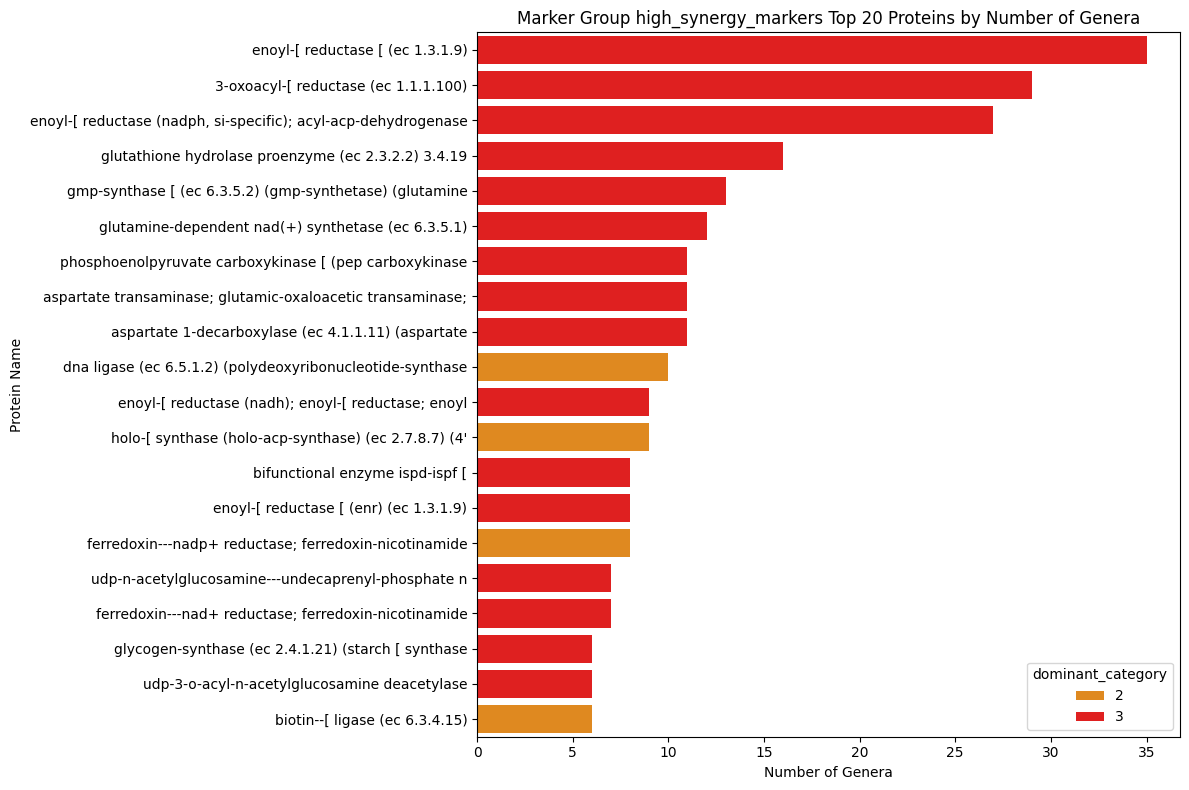

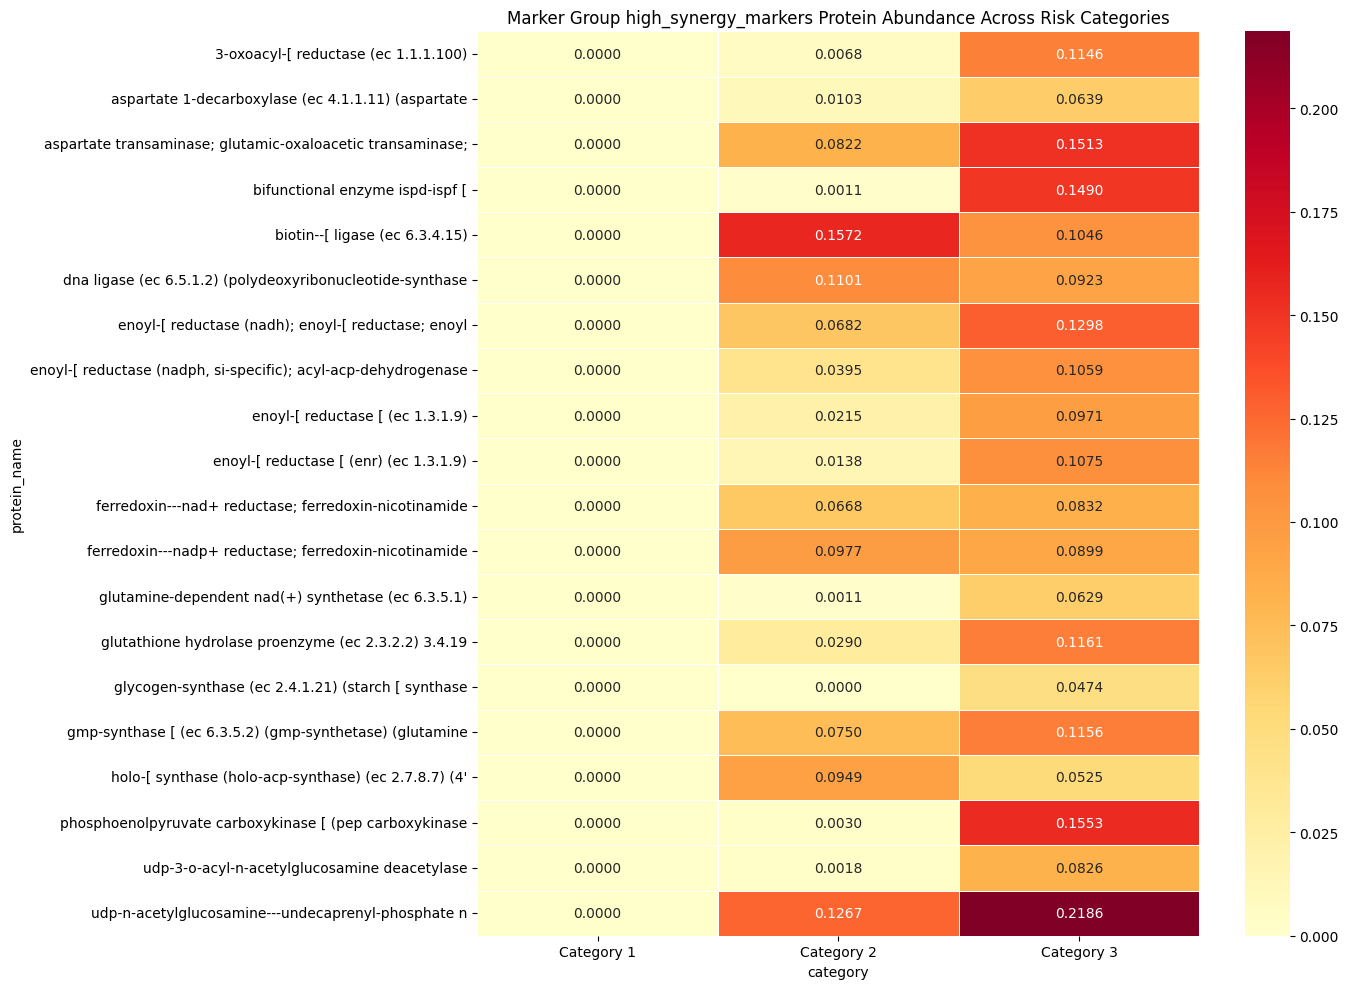

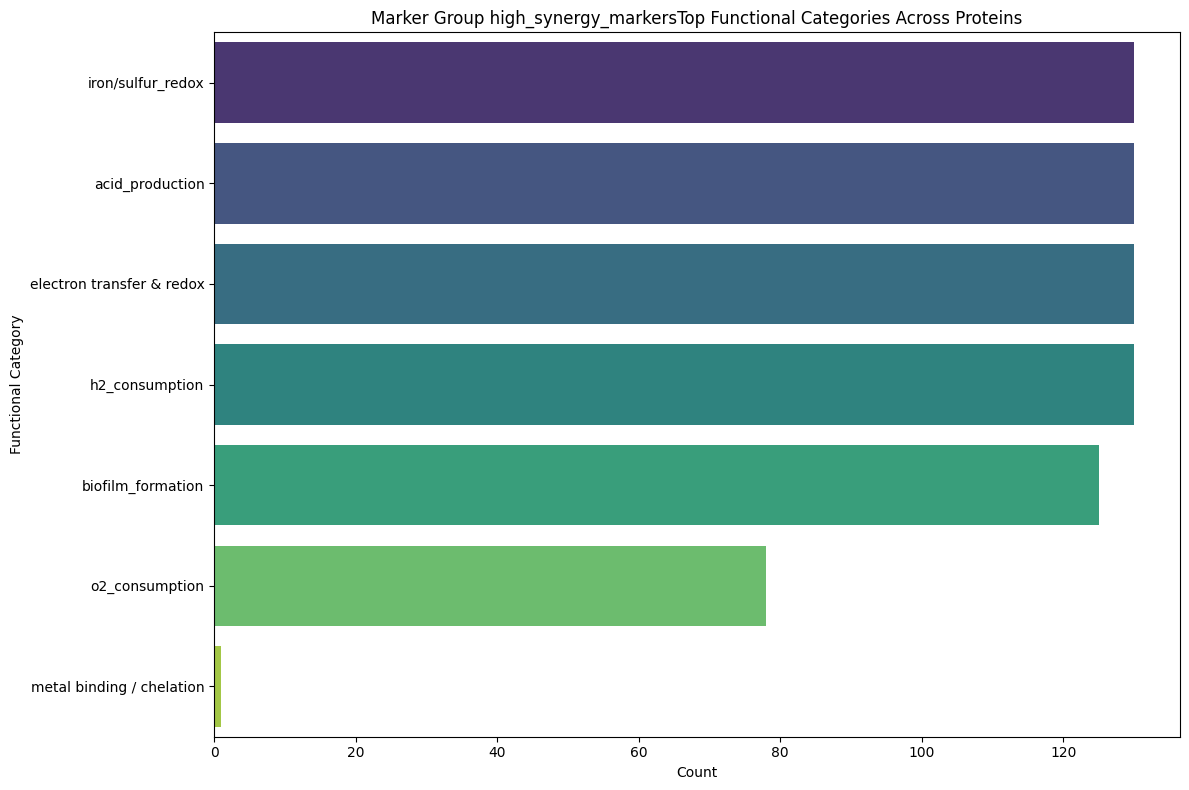

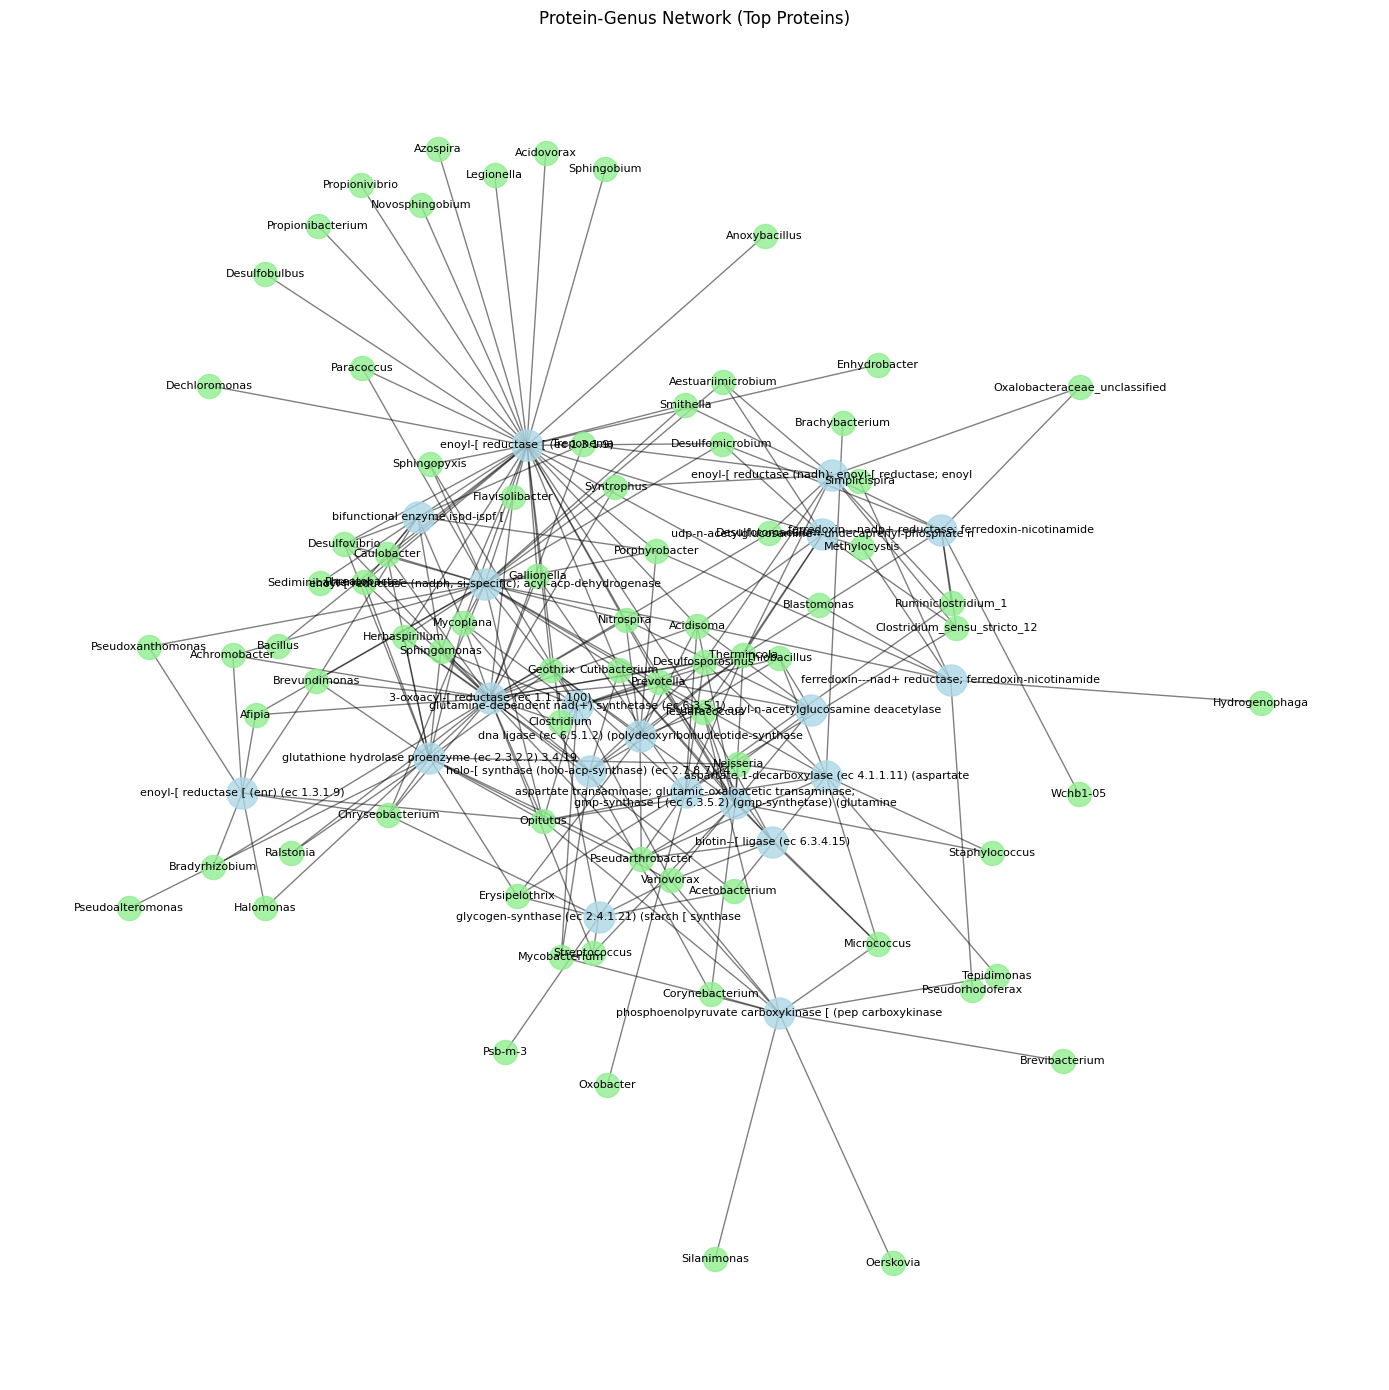

In [86]:
def analyze_key_proteins_across_genera(df, name, top_n =None):
    """
    Analyze key proteins across genera based on functional categories and expression patterns
        Parameters:df (pandas.DataFrame): DataFrame with protein-genus data
        Returns: tuple: Analysis results and visualizations
    """    
    # Get unique protein names
    unique_proteins = df['protein_name'].dropna().unique()
    # Create a summary dataframe for proteins
    protein_summary = []
    
    for protein in unique_proteins:
        # Filter rows for this protein
        protein_rows = df[df['protein_name'] == protein]
        
        # Skip if no rows
        if len(protein_rows) == 0:
            continue
        
        # Count genera
        genera_count = protein_rows['Genus'].nunique()
        genera_list = protein_rows['Genus'].unique().tolist()
        
        # Calculate average scores across risk categories
        avg_cat1 = protein_rows['mean_cat1'].mean()
        avg_cat2 = protein_rows['mean_cat2'].mean()
        avg_cat3 = protein_rows['mean_cat3'].mean()
        
        # Determine dominant category
        dominant_category = np.argmax([avg_cat1, avg_cat2, avg_cat3]) + 1
        
        # Calculate average fold changes
        avg_fold_3vs1 = protein_rows['fold_change_3vs1'].mean()
        
        # Get functional categories if available
        functional_cats = []
        if 'functional_categories_present' in protein_rows.columns:
            # Collect all functional categories
            all_cats = []
            for fc_str in protein_rows['functional_categories_present'].dropna():
                all_cats.extend([cat.strip() for cat in fc_str.split(';')])
            
            # Count occurrences
            from collections import Counter
            cat_counts = Counter(all_cats)
            functional_cats = [(cat, count) for cat, count in cat_counts.most_common() if cat]
        
        # Get enzyme class if available
        enzyme_class = protein_rows['enzyme_class'].iloc[0] if 'enzyme_class' in protein_rows.columns else None
        
        # Store summary
        protein_summary.append({
            'protein_name': protein,
            'genera_count': genera_count,
            'genera_list': genera_list,
            'avg_cat1': avg_cat1,
            'avg_cat2': avg_cat2,
            'avg_cat3': avg_cat3,
            'dominant_category': dominant_category,
            'avg_fold_3vs1': avg_fold_3vs1,
            'functional_categories': functional_cats,
            'enzyme_class': enzyme_class
        })
    
    # Convert to dataframe
    protein_df = pd.DataFrame(protein_summary)
    
    # Sort by number of genera (most common proteins first)
    protein_df = protein_df.sort_values('genera_count', ascending=False)
    
    # Create visualizations
    
    # 1. Top proteins by genera count
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(protein_df))
    top_proteins = protein_df.head(top_n)
    
    sns.barplot(
        x='genera_count', 
        y='protein_name', 
        hue= 'dominant_category',
        palette= category_colors ,#'viridis',
        data=top_proteins
    )
    plt.title(f"Marker Group {name} Top {top_n} Proteins by Number of Genera")
    plt.xlabel('Number of Genera')
    plt.ylabel('Protein Name')
    plt.tight_layout()
    
    # 2. Protein abundance across risk categories
    plt.figure(figsize=(14, 10))
    
    # Prepare data for plotting
    plot_data = []
    for _, row in top_proteins.iterrows():
        for cat in [1, 2, 3]:
            plot_data.append({
                'protein_name': row['protein_name'],
                'category': f'Category {cat}',
                'abundance': row[f'avg_cat{cat}']
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create heatmap
    pivot_df = plot_df.pivot(index='protein_name', columns='category', values='abundance')
    sns.heatmap(
        pivot_df, 
        cmap='YlOrRd', 
        annot=True, 
        fmt='.4f', 
        linewidths=0.5
    )
    plt.title(f"Marker Group {name} Protein Abundance Across Risk Categories")
    plt.tight_layout()
    
    # 3. Functional category distribution
    if 'functional_categories' in protein_df.columns and protein_df['functional_categories'].any():
        plt.figure(figsize=(12, 8))
        
        # Count functional categories
        all_cats = []
        for cats in protein_df['functional_categories']:
            if cats:
                all_cats.extend([cat for cat, _ in cats])
        
        cat_counts = Counter(all_cats)
        cat_df = pd.DataFrame(list(cat_counts.items()), columns=['Category', 'Count'])
        cat_df = cat_df.sort_values('Count', ascending=False)
        
        sns.barplot(
            x='Count', 
            y='Category', 
            palette='viridis',
            hue ='Category',
            data=cat_df.head(15)  # Top 15 categories
        )
        plt.title(f"Marker Group {name}Top Functional Categories Across Proteins")
        plt.xlabel('Count')
        plt.ylabel('Functional Category')
        plt.tight_layout()
    
    # 4. Network visualization of protein-genus relationships
    try:
        import networkx as nx
        
        plt.figure(figsize=(14, 14))
        
        # Create network
        G = nx.Graph()
        
        # Add protein nodes
        for protein in top_proteins['protein_name']:
            G.add_node(protein, node_type='protein')
        
        # Add genus nodes and edges
        all_genera = set()
        for _, row in top_proteins.iterrows():
            for genus in row['genera_list']:
                all_genera.add(genus)
                G.add_node(genus, node_type='genus')
                G.add_edge(row['protein_name'], genus)
        
        # Position nodes using spring layout
        pos = nx.spring_layout(G, k=0.3, iterations=50)
        
        # Draw protein nodes
        protein_nodes = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == 'protein']
        nx.draw_networkx_nodes(
            G, pos, 
            nodelist=protein_nodes,
            node_color='lightblue',
            node_size=500,
            alpha=0.8
        )
        
        # Draw genus nodes
        genus_nodes = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == 'genus']
        nx.draw_networkx_nodes(
            G, pos, 
            nodelist=genus_nodes,
            node_color='lightgreen',
            node_size=300,
            alpha=0.8
        )
        
        # Draw edges
        nx.draw_networkx_edges(
            G, pos, 
            width=1.0, 
            alpha=0.5
        )
        
        # Draw labels
        nx.draw_networkx_labels(
            G, pos, 
            font_size=8, 
            font_family='sans-serif'
        )
        
        plt.title('Protein-Genus Network (Top Proteins)')
        plt.axis('off')
        plt.tight_layout()
    except ImportError:
        print("NetworkX not available for network visualization")
    
    return protein_df, plt.gcf()
network_protein = analyze_key_proteins_across_genera(high_synergy_markers, "high_synergy_markers", top_n= 30)
output_path = shared_dir /"33_network_protein.png"

plt.savefig(output_path, dpi=300, bbox_inches='tight') 

### Making protein dataframe 
this is a join of the most relevant groups that have been done and comprises greoups with high corrosion relevance from the biological and numerical point of view.

In [87]:
#===================================== Joining Groups ======================================================================================
df_proteins = pd.concat([corrosion_critical, significant_markers,high_prevalence,
                        high_synergy_markers,  high_biological_relevance, high_corrosion_relevance])
df_proteins.drop_duplicates(subset=["protein_name", "Genus"], inplace=True)

Reverse Dictionary to Revert to the lost Columns

### Mapping back Genus to Sites for integration

In [88]:
# Create a mapping from genus to sites
genus_site_mapping = {}

# Iterate through each column
for col in Integrated_T.columns:
    # Skip the 'Category' column
    if col[0] == 'Category':
        continue
    
    # Get the genus from level 6
    genus = col[6]
    
    # Skip if genus is empty
    if genus == '':
        continue
    
    # Process each row (site) individually to safely handle non-numeric values
    sites_with_genus = []
    
    for site, value in Integrated_T[col].items():
        try:
            # Try to convert the value to float
            float_value = float(value)
            
            # If value is greater than 0, add this site
            if float_value > 0:
                sites_with_genus.append(site)
        except (ValueError, TypeError):
            # Skip this value if it can't be converted to float
            continue
    
    # Add to mapping if we found any sites
    if sites_with_genus:
        if genus not in genus_site_mapping:
            genus_site_mapping[genus] = sites_with_genus
        else:
            # Add new sites and ensure no duplicates
            genus_site_mapping[genus] = list(set(genus_site_mapping[genus] + sites_with_genus))

In [89]:
# Create an empty DataFrame with columns for Genus and Sites
df_genus_sites = pd.DataFrame(columns=["Genus", "Sites"])

# Populate the DataFrame with one row per genus-site pair
rows = []
for genus, sites_list in genus_site_mapping.items():
    for site in sites_list:
        rows.append({"Genus": genus, "Sites": site})

# Convert the list of dictionaries to a DataFrame
df_genus_sites = pd.DataFrame(rows)

## Saving the Data

In [90]:
with pd.ExcelWriter(combined_path, mode="w", engine='openpyxl') as writer:
    df_proteins.to_excel(writer, sheet_name= "df_proteins", index=True, freeze_panes=(1,0))
    df_genus_sites.to_excel(writer, sheet_name="genus_to_sites", index=False)
    balanced_markers.to_excel(writer, sheet_name="balanced_markers", index=False)